In [2]:
import sklearn
import numpy
import math

print('The scikit-learn verison is {}.'.format(sklearn.__version__))
print('The numpy versions i {}.'.format(numpy.__version__))
# lt. Paper: Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in 
# Machine Learning ist nur RandomOverSampler für den Multi-class-Fall anwendbar
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, KMeansSMOTE, SVMSMOTE

import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
#from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler


from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, balanced_accuracy_score 

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, precision_recall_curve

from sklearn.preprocessing import LabelBinarizer

from sklearn.utils import shuffle
from sklearn.utils.multiclass import unique_labels

from skimage import exposure, feature, transform
import pickle as pkl
from sklearn.decomposition import PCA

from itertools import product
from itertools import cycle

import seaborn as sns

import time
import timeit
from timeit import default_timer as timer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

import csv
import pandas as pd
# zum Visualisieren der Daten mithilfe von PCA
from mpl_toolkits.mplot3d import Axes3D

# jupyter notebooks als Module importieren
!pip install import-ipynb
import import_ipynb
import save_load
from save_load import load_hog_features, load_vgg16_features, load_labels, save_trained_model_as_pkl, load_trained_model_from_pkl, save_as_csv, read_csv, make_subsets_training_data_A
import tools
from tools import roc_auc_score_multiclass, roc_auc_score_single_class, scale_train_test_data, scale_train_test_data_without_std, scale_train_test_data_without_mean





def load_hog_features(path_train):
    X_hog = np.load(path_train)
    return X_hog

def load_labels(path_train):
    y_label = np.load(path_train)
    return y_label

'''
speichert trainierte Modelle bzw. Ergebnisse wiederholter Grid Search Anwendungen als Pickle-Datei.
Diese gespeicherten Modelle können mit Funktion   load_trained_model_from_pkl(name)
'''

def save_trained_model_as_pkl(model, filename):
    with open(filename, 'wb') as file:
        pkl.dump(model, file)  
        
'''
lädt bereits trainiertes, als Pickle-Datei gespeichertes Modell bzw. Ergebnisse wiederholter
Grid Search Anwendungen
'''
def load_trained_model_from_pkl(filename):
    with open(filename, 'rb') as file:
        new_model=pkl.load(file)
    return new_model

'''
speichern und lesen von CSV-Dateien
'''
def save_as_csv(list,path,name):
    path = path+name    
    with open(path, "w") as file:
        csv_wr = csv.writer(file)
        csv_wr.writerows(list)
        
def read_csv(path):
    read_file = []
    with open(path, "r") as file:
        csv_r = csv.reader(file)
        for row in csv_r:
            if row:
                read_file.append(row)
    return read_file




# in Anlehnung an:   https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659
def roc_auc_score_multiclass(y_test, y_pred, average='macro'):    
    labelBin = LabelBinarizer()
    labelBin.fit(y_test)    
    y_test = labelBin.transform(y_test)
    y_pred = labelBin.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)





'''
Roc_Auc_score für die einzelnen Klassen berechnen
'''
def roc_auc_score_single_class(y_test, y_pred, average = "macro"):
    # Menge der einzelnen Klassen erstellen
    single_classes = set(y_test)
    roc_aucs = {}
    for cl in single_classes:
        #Liste der restlichen Klassen erstellen
        remain_classes = [x for x in single_classes if x != cl]

        # aktuelle Klasse mit 1 markieren und alle anderen Klassen mit 0
        y_test_roc = [0 if x in remain_classes else 1 for x in y_test]
        y_pred_roc = [0 if x in remain_classes else 1 for x in y_pred]

        # roc_auc_score berechnen
        roc_auc = roc_auc_score(y_test_roc, y_pred_roc, average = average)
        roc_aucs[cl] = roc_auc

    return roc_aucs





def convert_string_to_int(y_true, y_pred):
    y_true_int = []
    y_pred_int = []
    for i in range(0, len(y_true)):
        y_true_int.append(int(y_true[i]))
        y_pred_int.append(int(y_pred[i]))
    return y_true_int, y_pred_int 




def plot_confusion_matrix_norm(y_test, y_pred, title):        
    classes = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18',
              '19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35',
              '36','37','38','39','40','41','42']  
    y_test_int, y_pred_int = convert_string_to_int(y_test, y_pred)
    cm = confusion_matrix(y_test_int, y_pred_int)    
    np.set_printoptions(precision=3)    
    #plt.figure(figsize=(4.5*2, 2.5*2))
    #plt.figure(figsize=(9*2, 5*2))
    #plt.figure(figsize=(13.5*2, 7.5*2))
    
    fig = plt.figure(figsize=(18*2, 10*2))
    #fig.suptitle('Confusion matrix ', fontsize=20, fontweight='medium')
    normalize=True    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix  '+title, fontsize=28)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):            
    #for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=24)
    plt.xlabel('Predicted label', fontsize=24)
    plt.tight_layout()
    plt.show()
    return fig


# Classification report ausgeben
def classif_report(y_te, y_pred):
    y_test_int, y_pred_int = convert_string_to_int(y_te, y_pred)
    print(classification_report(y_test_int, y_pred_int))   





'''
erstellen unterschiedlicher Trainingsmengen aus 39.209 Trainingsdaten
Datensätze werden zufällig aber reproduzierbar durch random_state=0
unter Berücksichtigung der prozentualen Anteile der Daten in den
einzelnen Klassen, erstellt.
Tracks werden nicht berücksichtigt
'''
def make_training_subsets_A(X_tr, y_tr):
    # Trainingsdaten mischen, da diese ursprünglich sortiert vorliegen
    X_tr, y_tr = shuffle(X_tr, y_tr, random_state=42)    
    # Trainingsmenge mit 20.000 Bilder erzeugen
    X_tr_20000, X_te_2, y_tr_20000, y_te_2 = train_test_split(
        X_tr, y_tr, random_state = 0, train_size=20000/39209, stratify=y_tr)
    # Trainingsmenge mit 10.000 Bilder erzeugen
    X_tr_10000, X_te_3, y_tr_10000, y_te_3 = train_test_split(
        X_tr_20000, y_tr_20000, random_state = 0, train_size=1/2, stratify=y_tr_20000)
    # Trainingsmenge mit 5.000 Bilder erzeugen   
    X_tr_5000, X_te_4, y_tr_5000, y_te_4 = train_test_split(
        X_tr_10000, y_tr_10000, random_state = 0, train_size=1/2, stratify=y_tr_10000)
     #Trainingsmenge mit 2.000 Bilder erzeugen   
    X_tr_2000, X_te_5, y_tr_2000, y_te_5 = train_test_split(
        X_tr_5000, y_tr_5000, random_state = 0, train_size=2/5, stratify=y_tr_5000)
     #Trainingsmenge mit 1.000 Bilder erzeugen   
    X_tr_1000, X_te_6, y_tr_1000, y_te_6 = train_test_split(
        X_tr_2000, y_tr_2000, random_state = 0, train_size=1/2, stratify=y_tr_2000)
    # Trainingsmenge mit 500 Bilder erzeugen   
    X_tr_500, X_te_7, y_tr_500, y_te_7 = train_test_split(
        X_tr_1000, y_tr_1000, random_state = 0, train_size=1/2, stratify=y_tr_1000)
    # Trainingsmenge mit 200 Bilder erzeugen   
    X_tr_200, X_te_8, y_tr_200, y_te_8 = train_test_split(
        X_tr_500, y_tr_500, random_state = 0, train_size=2/5, stratify=y_tr_500)
    return X_tr,y_tr,X_tr_20000,y_tr_20000,X_tr_10000,y_tr_10000,X_tr_5000,y_tr_5000,X_tr_2000,y_tr_2000,X_tr_1000,y_tr_1000,X_tr_500,y_tr_500,X_tr_200,y_tr_200




'''
Trainings- und Testdaten mit dem StandardScaler skalieren
'''
def scale_train_test_data(X_tr, X_te):
    scaler = StandardScaler()
    scaler.fit(X_tr)
    X_tr_trans = scaler.transform(X_tr)
    X_te_trans = scaler.transform(X_te)
    return X_tr_trans, X_te_trans
    
'''
Trainings- und Testdaten mit dem StandardScaler skalieren
ohne std
'''
def scale_train_test_data_without_std(X_tr, X_te):
    scaler = StandardScaler(with_std=False)
    scaler.fit(X_tr)
    X_tr_trans = scaler.transform(X_tr)
    X_te_trans = scaler.transform(X_te)
    return X_tr_trans, X_te_trans
    
'''
Trainings- und Testdaten mit dem StandardScaler skalieren
ohne std
'''
def scale_train_test_data_without_mean(X_tr, X_te):
    scaler = StandardScaler(with_mean=False)
    scaler.fit(X_tr)
    X_tr_trans = scaler.transform(X_tr)
    X_te_trans = scaler.transform(X_te)
    return X_tr_trans, X_te_trans
    
    
'''
Oversampling der Minderheitsklasse
'''
def make_smote_minority(X, y):
    smote = SMOTE('minority', k_neighbors=1, random_state=0)
    X_smote, y_smote = smote.fit_sample(X,y)
    return X_smote, y_smote 





'''
SVC mit RBG Kernel trainieren
seed = Saatpunkt für Numpy-Zufallsgenerator
number = Anzahl der Trainingsdaten
C = Wert des Parameters C
scale = Daten skalieren oder nicht, wenn scale=0 dann nicht skalieren
                                    wenn scale=1 dann skalieren ohne std
                                    wenn scale=2 dann skalieren mit std
                                    wenn scale=3 dann skalieren ohne mean
smote = 0, dann ohne SMOTE
smote = 1, dann mit SMOTE mit minority

class_weight:    class_weight='balanced', class_weight=None
'''
'''
SVC mit RBF-Kernel trainieren, mit StandardScaler
'''
def train_RBF_SVC(X_tr, X_te, y_tr, y_te, seed, number, C, gamma, scale, smote, decision_function, 
                  class_weight, front_path, end_path, feature):
    # Seed-Punkt setzen für Reproduzierbarkeit
    #seed = seed
    #np.random.seed(seed)
    # Pfad für speichern des Modells, Confusion matrix, Metriken
    #path = "SVM_Modelle_FM/Hog_default/rbf/"+number+"/NEU seed 7 random 0/1terDL/"
    #path = "SVM_Modelle_FM/Hog_default/rbf/"+number+"/NEU seed 7 random B/1terDL/"
    #path = "SVM_Modelle_FM/Hog_default/rbf/"+number+"/NEU seed 7 random C/1terDL/"
    path = front_path+"/"+number+"/"+end_path+"/"
    
    # Liste in welcher die berechneten Metriken gespeichert werden
    metrics = []
    # Liste für Trainingszeiten
    time_list = []
    #Liste für Testzeiten
    time_list_test = []
    
    if smote == 1:
        print("Smote minority")
        X_tr, y_tr = make_smote_minority(X_tr, y_tr)
    
     # Trainings- und Testdaten skalieren
    if scale == 1:
        print("Daten skalieren ohne std")
        X_tr, X_te = scale_train_test_data_without_std(X_tr, X_te)
    if scale == 2:
        print("Daten skalieren")
        X_tr, X_te = scale_train_test_data(X_tr, X_te)
    if scale == 3:
        print("Daten skalieren ohne mean")
        scale_train_test_data_without_mean(X_tr, X_te)
        
    #if smote == 1:
     #   print("Smote minority")
      #  X_tr, y_tr = make_smote_minority(X_tr, y_tr)
 
    # SVC mit den skalierten Daten trainieren und speichern
    start = time.time()
    start2 = time.process_time()
    start3 = time.perf_counter()
    
    #rbfSVC = SVC(C=C, gamma='auto_deprecated')
    rbfSVC = SVC(C=C, gamma=gamma, class_weight=class_weight, decision_function_shape= decision_function, random_state=seed)
    rbfSVC.fit(X_tr, y_tr)
    end = time.time()-start
    end2 = time.process_time()-start2
    end3 = time.perf_counter()-start3
                
    end_per_sample = end/int(number)
    end2_per_sample = end2/int(number)
    end3_per_sample = end3/int(number)
    # Trainingszeiten speichern
    time_list.append([end,end2,end3])    
    time_list.append([end_per_sample, end2_per_sample, end3_per_sample])
    save_as_csv(time_list, path, 'Trainingszeiten.csv')
    
    # trainiertes Modell speichern
    save_trained_model_as_pkl(rbfSVC, path+"RBF_SVC_"+number+"_"+feature)    
                              
    # Vorhersage machen und speichern
    y_pred = rbfSVC.predict(X_te)    
    np.save(path+"y_pred_label.npy", y_pred) 
    # zusätzlich Label der Testdaten speichern, auch wenn eigentlich überflüssig
    np.save(path+"y_test_label.npy", y_te)
                                  
    # Metriken berechnen und speichern                          
    acc = accuracy_score(y_te, y_pred)                  
    prec = precision_score(y_te, y_pred, average='macro')    
    rec = recall_score(y_te, y_pred, average='macro')   
    f1 = f1_score(y_te, y_pred, average='macro') 
    roc = roc_auc_score_multiclass(y_te, y_pred, average='macro')
    kappa = cohen_kappa_score(y_te, y_pred)
    metrics.append([acc,prec,rec,f1,roc,kappa])
    save_as_csv(metrics,path,'metrics.csv')  
    
    roc_single_class = roc_auc_score_single_class(y_te, y_pred, average='macro')
    np.save(path+"roc_auc_score_single_class.npy", roc_single_class)
    
    # Confusion Matrix erstellen und speichern
    title = '(SVC rbf '+number+' C='+str(C)+')'    
    cm = plot_confusion_matrix_norm(y_te, y_pred, title)       
    cm.savefig(path+"Confusion_matrix.png")    
    
    # Performanz mit Testdaten testen und Klassifikationszeit speichern
    start4 = time.time()
    start5 = time.process_time()
    start6 = time.perf_counter()
    test_acc = rbfSVC.score(X_te, y_te)
    end4 = time.time()-start4
    end5 = time.process_time()-start5
    end6 = time.perf_counter()-start6
    end4_per_sample = end4/int(number)
    end5_per_sample = end5/int(number)
    end6_per_sample = end6/int(number)
    # Klassifikationszeiten speichern
    time_list_test.append([end4,end5,end6])    
    time_list_test.append([end4_per_sample, end5_per_sample, end6_per_sample])
    save_as_csv(time_list_test, path, 'Testzeiten.csv')
    print("Test accuracy: ",test_acc,'\n')
    
    # Klassifikationsreport erstellen und speichern
    classif_report(y_te, y_pred)
    
    # precision, recall und f-Score pro Klasse speichern
    save_as_csv(precision_recall_fscore_support(y_te, y_pred), path, "precision_recall_fscore.csv")





'''
LinearSVC trainieren
seed = Saatpunkt für Numpy-Zufallsgenerator
number = Anzahl der Trainingsdaten
C = Wert des Parameters C
scale = Daten skalieren oder nicht, wenn scale=0 dann nicht skalieren
                                    wenn scale=1 dann skalieren ohne std
                                    wenn scale=2 dann skalieren mit std
smote = 0, dann ohne SMOTE
smote = 1, dann mit SMOTE

class_weight:    class_weight='balanced', class_weight=None
'''
def train_LinearSVC(X_tr, X_te, y_tr, y_te, seed, number, C, scale, smote, class_weight, front_path, end_path,feature):
    # Seed-Punkt setzen für Reproduzierbarkeit
    #seed = seed
    #np.random.seed(seed)
    # Pfad für speichern des Modells, Confusion matrix, Metriken
    #path = "SVM_Modelle_FM/Hog_default/LinearSVC/"+number+"/NEU seed 7 random 0/1terDL/"
    #path = "SVM_Modelle_FM/Hog_default/LinearSVC/"+number+"/NEU seed 7 random B/1terDL/"
    #path = "SVM_Modelle_FM/Hog_default/LinearSVC/"+number+"/NEU seed 7 random C/1terDL/"
    path = front_path+"/"+number+"/"+end_path+"/"
    # Liste in welcher die berechneten Metriken gespeichert werden
    metrics = []
    # Liste für Trainingszeiten
    time_list = []
    #Liste für Testzeiten
    time_list_test = []
    
    if smote == 1:
        print("Smote minority")
        X_tr, y_tr = make_smote_minority(X_tr, y_tr)
       
    if scale == 1:
        print("Daten skalieren ohne std")
        X_tr, X_te = scale_train_test_data_without_std(X_tr, X_te)
    if scale == 2:
        print("Daten skalieren")
        X_tr, X_te = scale_train_test_data(X_tr, X_te)
        
    # LinearSVC mit den Daten trainieren und speichern
    start = time.time()
    start2 = time.process_time()
    start3 = time.perf_counter()
    
    linSVC = LinearSVC(C=C, loss='hinge', class_weight=class_weight, random_state=seed)
    linSVC.fit(X_tr, y_tr)
    end = time.time()-start
    end2 = time.process_time()-start2
    end3 = time.perf_counter()-start3
            
    end_per_sample = end/int(number)
    end2_per_sample = end2/int(number)
    end3_per_sample = end3/int(number)
    # Trainingszeiten speichern
    time_list.append([end,end2,end3])    
    time_list.append([end_per_sample, end2_per_sample, end3_per_sample])
    save_as_csv(time_list, path, 'Trainingszeiten.csv')
    
    # trainiertes Modell speichern
    save_trained_model_as_pkl(linSVC, path+"LinearSVC_"+number+"_"+feature)      
                              
    # Vorhersage machen und speichern
    y_pred = linSVC.predict(X_te)    
    np.save(path+"y_pred_label.npy", y_pred) 
    # zusätzlich Label der Testdaten speichern, auch wenn eigentlich überflüssig
    np.save(path+"y_test_label.npy", y_te)
                                  
    # Metriken berechnen und speichern                          
    acc = accuracy_score(y_te, y_pred)                  
    prec = precision_score(y_te, y_pred, average='macro')    
    rec = recall_score(y_te, y_pred, average='macro')   
    f1 = f1_score(y_te, y_pred, average='macro')
    roc = roc_auc_score_multiclass(y_te, y_pred, average='macro')
    kappa = cohen_kappa_score(y_te, y_pred)
    metrics.append([acc,prec,rec,f1,roc,kappa])
    save_as_csv(metrics,path,'metrics.csv')  
    
    roc_single_class = roc_auc_score_single_class(y_te, y_pred, average='macro')
    np.save(path+"roc_auc_score_single_class.npy", roc_single_class)
    
    # Confusion Matrix erstellen und speichern
    title = '(LinearSVC '+number+' C='+str(C)+')'
    cm = plot_confusion_matrix_norm(y_te, y_pred, title)     
    cm.savefig(path+"Confusion_matrix.png")    
    
    # Performanz mit Testdaten testen und Klassifikationszeit speichern
    start4 = time.time()
    start5 = time.process_time()
    start6 = time.perf_counter()
    test_acc = linSVC.score(X_te, y_te)
    end4 = time.time()-start4
    end5 = time.process_time()-start5
    end6 = time.perf_counter()-start6
    end4_per_sample = end4/int(number)
    end5_per_sample = end5/int(number)
    end6_per_sample = end6/int(number)
    # Klassifikationszeiten speichern
    time_list_test.append([end4,end5,end6])    
    time_list_test.append([end4_per_sample, end5_per_sample, end6_per_sample])
    save_as_csv(time_list_test, path, 'Testzeiten.csv')
    print("Test accuracy: ",test_acc,'\n')
    
    # Klassifikationsreport erstellen und speichern
    classif_report(y_te, y_pred)
        
    # precision, recall und f-Score pro Klasse speichern
    save_as_csv(precision_recall_fscore_support(y_te, y_pred), path, 'precision_recall_fscore.csv')    




'''
LinearSVC trainieren
seed = Saatpunkt für Numpy-Zufallsgenerator
number = Anzahl der Trainingsdaten
C = Wert des Parameters C
scale = Daten skalieren oder nicht, wenn scale=0 dann nicht skalieren
                                    wenn scale=1 dann skalieren ohne std
                                    wenn scale=2 dann skalieren mit std
smote = 0, dann ohne SMOTE
smote = 1, dann mit SMOTE

class_weight:    class_weight='balanced', class_weight=None
'''
def train_LinearSVC_sq(X_tr, X_te, y_tr, y_te, seed, number, C, scale, smote, class_weight, front_path, end_path,feature):
    # Seed-Punkt setzen für Reproduzierbarkeit
    #seed = seed
    #np.random.seed(seed)
    # Pfad für speichern des Modells, Confusion matrix, Metriken
    #path = "SVM_Modelle_FM/Hog_default/LinearSVC/"+number+"/NEU seed 7 random 0/1terDL/"
    #path = "SVM_Modelle_FM/Hog_default/LinearSVC/"+number+"/NEU seed 7 random B/1terDL/"
    #path = "SVM_Modelle_FM/Hog_default/LinearSVC/"+number+"/NEU seed 7 random C/1terDL/"
    path = front_path+"/"+number+"/"+end_path+"/"
    # Liste in welcher die berechneten Metriken gespeichert werden
    metrics = []
    # Liste für Trainingszeiten
    time_list = []
    #Liste für Testzeiten
    time_list_test = []
    
    if smote == 1:
        print("Smote minority")
        X_tr, y_tr = make_smote_minority(X_tr, y_tr)
       
    if scale == 1:
        print("Daten skalieren ohne std")
        X_tr, X_te = scale_train_test_data_without_std(X_tr, X_te)
    if scale == 2:
        print("Daten skalieren")
        X_tr, X_te = scale_train_test_data(X_tr, X_te)
        
    # LinearSVC mit den Daten trainieren und speichern
    start = time.time()
    start2 = time.process_time()
    start3 = time.perf_counter()
    
    linSVC = LinearSVC(C=C, penalty='l2', loss='squared_hinge', class_weight=class_weight, random_state=seed)
    linSVC.fit(X_tr, y_tr)
    end = time.time()-start
    end2 = time.process_time()-start2
    end3 = time.perf_counter()-start3
            
    end_per_sample = end/int(number)
    end2_per_sample = end2/int(number)
    end3_per_sample = end3/int(number)
    # Trainingszeiten speichern
    time_list.append([end,end2,end3])    
    time_list.append([end_per_sample, end2_per_sample, end3_per_sample])
    save_as_csv(time_list, path, 'Trainingszeiten.csv')
    
    # trainiertes Modell speichern
    save_trained_model_as_pkl(linSVC, path+"LinearSVC_"+number+"_"+feature)      
                              
    # Vorhersage machen und speichern
    y_pred = linSVC.predict(X_te)    
    np.save(path+"y_pred_label.npy", y_pred) 
    # zusätzlich Label der Testdaten speichern, auch wenn eigentlich überflüssig
    np.save(path+"y_test_label.npy", y_te)
                                  
    # Metriken berechnen und speichern                          
    acc = accuracy_score(y_te, y_pred)                  
    prec = precision_score(y_te, y_pred, average='macro')    
    rec = recall_score(y_te, y_pred, average='macro')   
    f1 = f1_score(y_te, y_pred, average='macro')
    roc = roc_auc_score_multiclass(y_te, y_pred, average='macro')
    kappa = cohen_kappa_score(y_te, y_pred)
    metrics.append([acc,prec,rec,f1,roc,kappa])
    save_as_csv(metrics,path,'metrics.csv')  
    
    roc_single_class = roc_auc_score_single_class(y_te, y_pred, average='macro')
    np.save(path+"roc_auc_score_single_class.npy", roc_single_class)
    
    # Confusion Matrix erstellen und speichern
    title = '(LinearSVC '+number+' C='+str(C)+')'
    cm = plot_confusion_matrix_norm(y_te, y_pred, title)     
    cm.savefig(path+"Confusion_matrix.png")    
    
    # Performanz mit Testdaten testen und Klassifikationszeit speichern
    start4 = time.time()
    start5 = time.process_time()
    start6 = time.perf_counter()
    test_acc = linSVC.score(X_te, y_te)
    end4 = time.time()-start4
    end5 = time.process_time()-start5
    end6 = time.perf_counter()-start6
    end4_per_sample = end4/int(number)
    end5_per_sample = end5/int(number)
    end6_per_sample = end6/int(number)
    # Klassifikationszeiten speichern
    time_list_test.append([end4,end5,end6])    
    time_list_test.append([end4_per_sample, end5_per_sample, end6_per_sample])
    save_as_csv(time_list_test, path, 'Testzeiten.csv')
    print("Test accuracy: ",test_acc,'\n')
    
    # Klassifikationsreport erstellen und speichern
    classif_report(y_te, y_pred)
        
    # precision, recall und f-Score pro Klasse speichern
    save_as_csv(precision_recall_fscore_support(y_te, y_pred), path, 'precision_recall_fscore.csv')  





'''
Tuning der Hyperparameter mit GridSearchCV 

Mit refit=True (Standardeinstellung) wird der beste Estimator, welcher über 
die Kreuzvalidierung gefunden wurde, zusätzlich mit dem gesamten
Trainingsdatensatz trainiert 
'''
def tuning_hyper_params(X, y, X_test, y_test, kernel='LinearSVC', cv=3,
                        scaler=0, pca=0,
                        c_range=np.logspace(-16,10,14, base=2), 
                        gamma_range=np.logspace(-16,4,11, base=2),  
                        penalty='l2', loss='squared_hinge',
                        seed=1):
    # extra nochmal seed für np.random setzen, z.B. auch StratifiedKFold ein
    # random_state verwendet wird
    seed = seed
    np.random.seed(seed)    
    start=time.time()
    start2 = time.process_time()
    start3 = time.perf_counter()
    time_list = [] # Zeit für GridSearch
    
    scoring = {'Precision': make_scorer(precision_score, average='macro'),
               'Recall': make_scorer(recall_score, average='macro'),
               'F1': make_scorer(f1_score, average='macro'),
               'acc': make_scorer(accuracy_score),
               'roc': make_scorer(roc_auc_score_multiclass, average='macro')} 
                  
    if kernel == 'LinearSVC':
        if scaler == 0:
            pipeline = Pipeline([
                ("svm", LinearSVC(penalty=penalty, loss=loss, class_weight='balanced', random_state=seed))])
        if scaler == 1:
            pipeline = Pipeline([
                ("scaler", StandardScaler(with_std=False)),
                ("svm", LinearSVC(penalty=penalty, loss=loss, class_weight='balanced', random_state=seed))
            ])
        if scaler == 2:
            pipeline = Pipeline([
                ("scaler", StandardScaler()),
                ("svm", LinearSVC(penalty=penalty, loss=loss, class_weight='balanced', random_state=seed))
            ])          
                        
        param_grid=[{'svm__C': c_range}]
                        
        clf = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit='F1', n_jobs=-1)
        clf.fit(X,y)                
                               
        print('\n C_range:', c_range)
        print('\n Bester Score: ',clf.best_score_)
        print('\n Besten Parameter: ', clf.best_params_)            
                        
    elif kernel == 'rbf':
        if scaler == 2:
            pipeline = Pipeline([
                ("scaler", StandardScaler()),
                ("svm", SVC(decision_function_shape='ovo', class_weight="balanced", random_state=seed))])
                              
        param_grid=[{'svm__C': c_range, 'svm__gamma': gamma_range}]
        clf = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit='F1', n_jobs=-1)
        clf.fit(X,y)        
        print('\n C_range: ', c_range)
        print('\n gamma_range:', gamma_range)
        print('\n Beste Score: ',clf.best_score_)
        print('\n Besten Parameter: ', clf.best_params_)   

    end = time.time()-start
    end2 = time.process_time()-start2
    end3 = time.perf_counter()-start3
    time_list.append([end,end2,end3])
    
    #Nur korrekt, wenn kein StandardScaler verwendet wurde
    if scaler == 0:
        print("Bester Estimator score: ",clf.best_estimator_.score(X_test, y_test))            
       
    for mean, stdev, param in zip(clf.cv_results_['mean_test_Precision'],
                              clf.cv_results_['std_test_Precision'],
                              clf.cv_results_['params']):
        print("Precision-Score: %f (%f) mit Parameter: %r" % (mean, stdev, param))
        
    for mean, stdev, param in zip(clf.cv_results_['mean_test_Recall'], 
                              clf.cv_results_['std_test_Recall'],clf.cv_results_['params']):
        print("Recall-Score: %f (%f) mit Parameter: %r" % (mean, stdev, param))
        
    for mean, stdev, param in zip(clf.cv_results_['mean_test_F1'], 
                              clf.cv_results_['std_test_F1'],clf.cv_results_['params']):
        print("F1-Score: %f (%f) mit Parameter: %r" % (mean, stdev, param))
        
    for mean, stdev, param in zip(clf.cv_results_['mean_test_acc'], clf.cv_results_['std_test_acc'],
                              clf.cv_results_['params']):
        print("Accuracy-Score: %f (%f) mit Parameter: %r" % (mean, stdev, param))  
                
    for mean, stdev, param in zip(clf.cv_results_['mean_test_roc'],clf.cv_results_['std_test_roc'],
                              clf.cv_results_['params']):
        print("Roc-Score: %f (%f) mit Parameter: %r" % (mean, stdev, param))    
    return clf, time_list


'''
Verfeinerten Suchbereich für gefundenen Parameter bestimmen
Schrittweite 1/4 im Exponenten, d.h. wenn z.B. 8 der gefundene Parameter ist,
np.log2(8) = 3    ---> np.logspace(1,5,17,base=2)
'''
def get_finer_range(number):
    exp = np.log2(number) #Exponent bestimmen, Basis 2
    range = np.logspace(exp-2, exp+2, 17, base=2)
    return range


The scikit-learn verison is 0.21.3.
The numpy versions i 1.15.4.


Using TensorFlow backend.


importing Jupyter notebook from save_load.ipynb
Hallo angekommen
importing Jupyter notebook from tools.ipynb


In [3]:
# Trainingsdaten, Bounding Box laden
X_train_9_4_2 = load_hog_features("GTSRB_Data/GTSRB_HOG_Features_BB_skimage_9_4_2_l2_hys.npy")
X_test_9_4_2 = load_hog_features("GTSRB_Data/GTSRB_HOG_Features_Test_BB_skimage_9_4_2_l2_hys.npy")
# Label laden
y_train = load_labels("GTSRB_Data/GTSRB_training_label.npy")
y_test = load_labels("GTSRB_Data/GTSRB_test_label.npy")


In [4]:
X_tr,y_tr,X_tr_20000,y_tr_20000,X_tr_10000,y_tr_10000,X_tr_5000,y_tr_5000,X_tr_2000,y_tr_2000,X_tr_1000,y_tr_1000,X_tr_500,y_tr_500,X_tr_200,y_tr_200 = make_training_subsets_A(X_train_9_4_2, y_train)

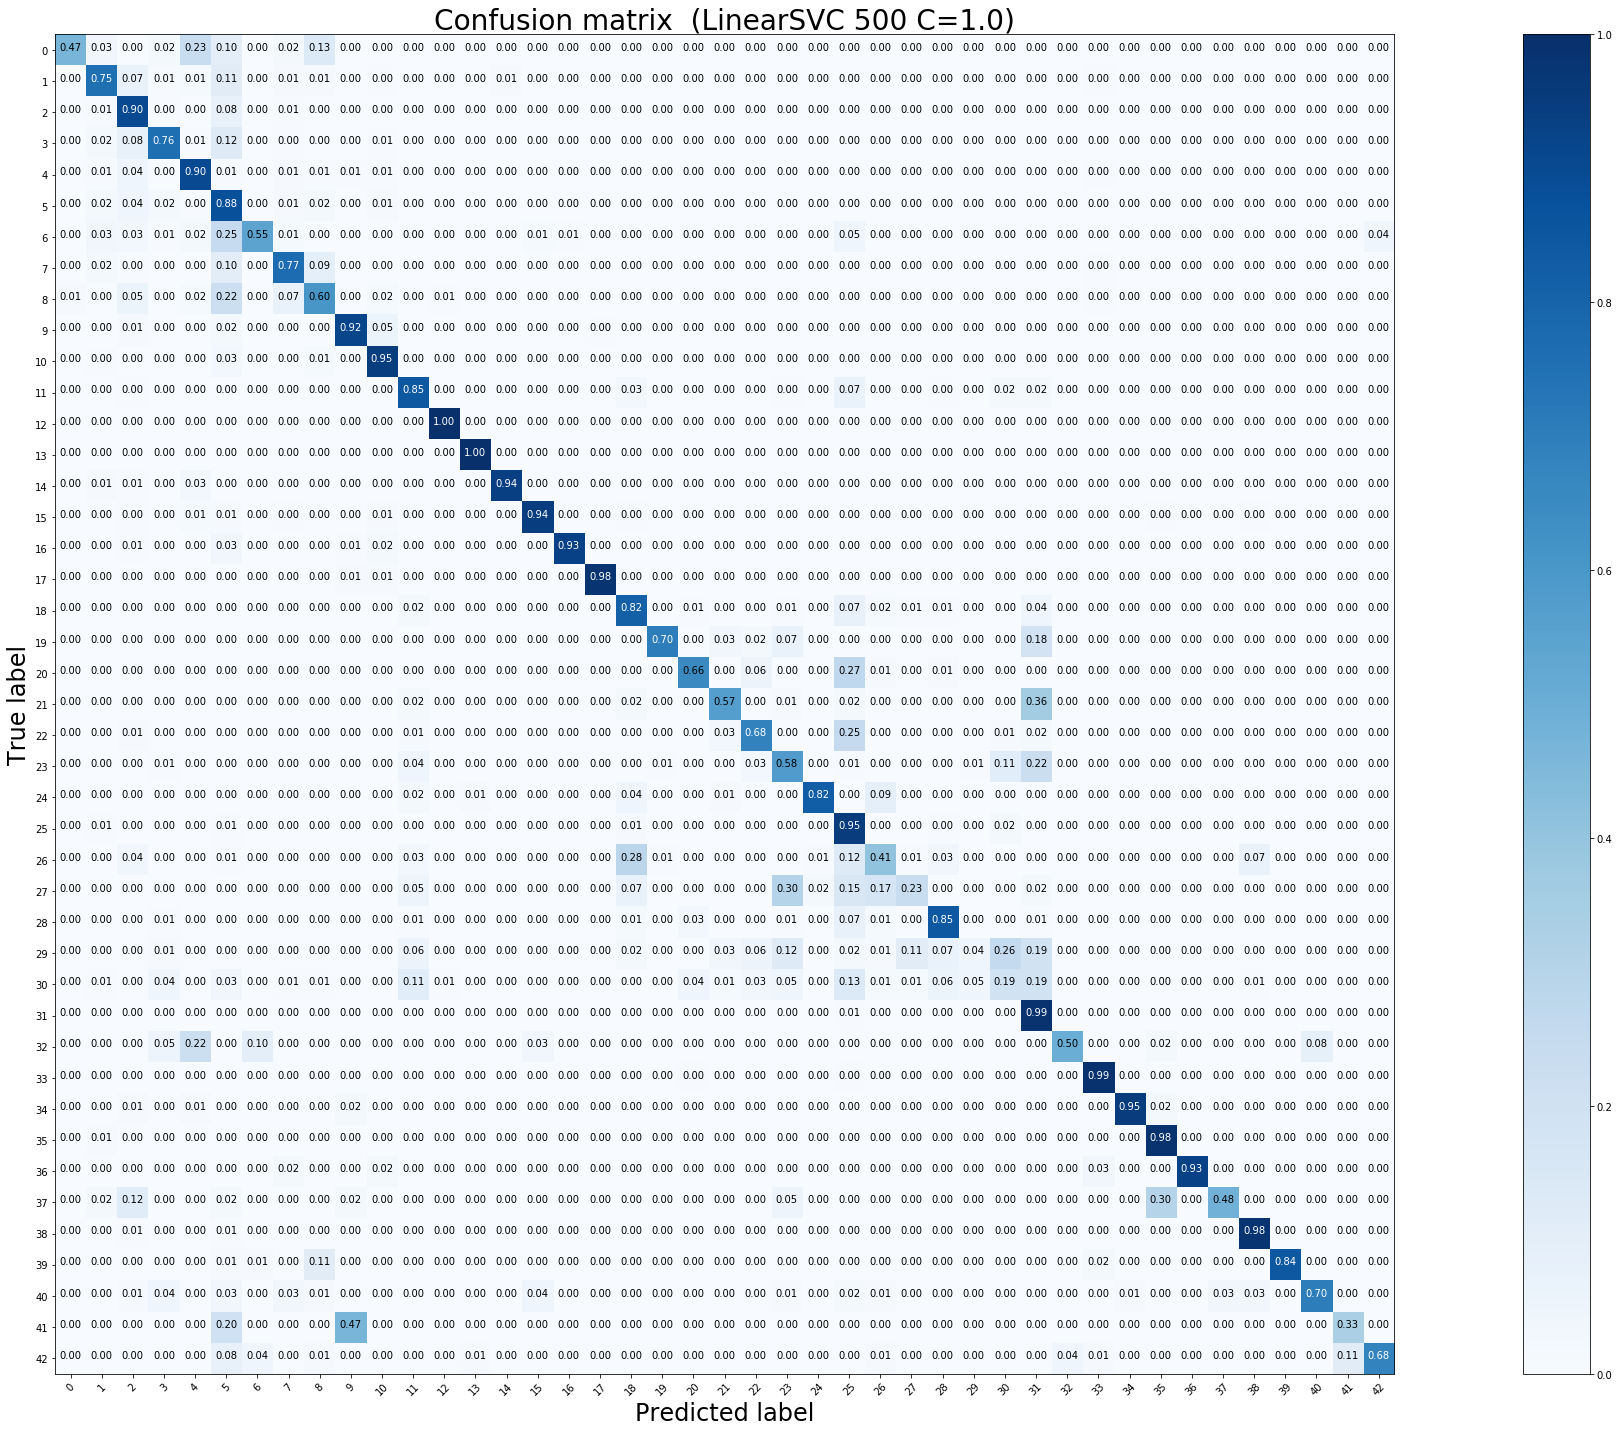

Test accuracy:  0.8445764053840064 

              precision    recall  f1-score   support

           0       0.85      0.47      0.60        60
           1       0.90      0.75      0.82       720
           2       0.77      0.90      0.83       750
           3       0.90      0.76      0.83       450
           4       0.90      0.90      0.90       660
           5       0.55      0.88      0.67       630
           6       0.88      0.55      0.67       150
           7       0.83      0.77      0.80       450
           8       0.74      0.60      0.66       450
           9       0.91      0.92      0.91       480
          10       0.91      0.95      0.93       660
          11       0.88      0.85      0.86       420
          12       0.99      1.00      0.99       690
          13       0.99      1.00      1.00       720
          14       0.98      0.94      0.96       270
          15       0.95      0.94      0.95       210
          16       0.99      0.93      0.96 

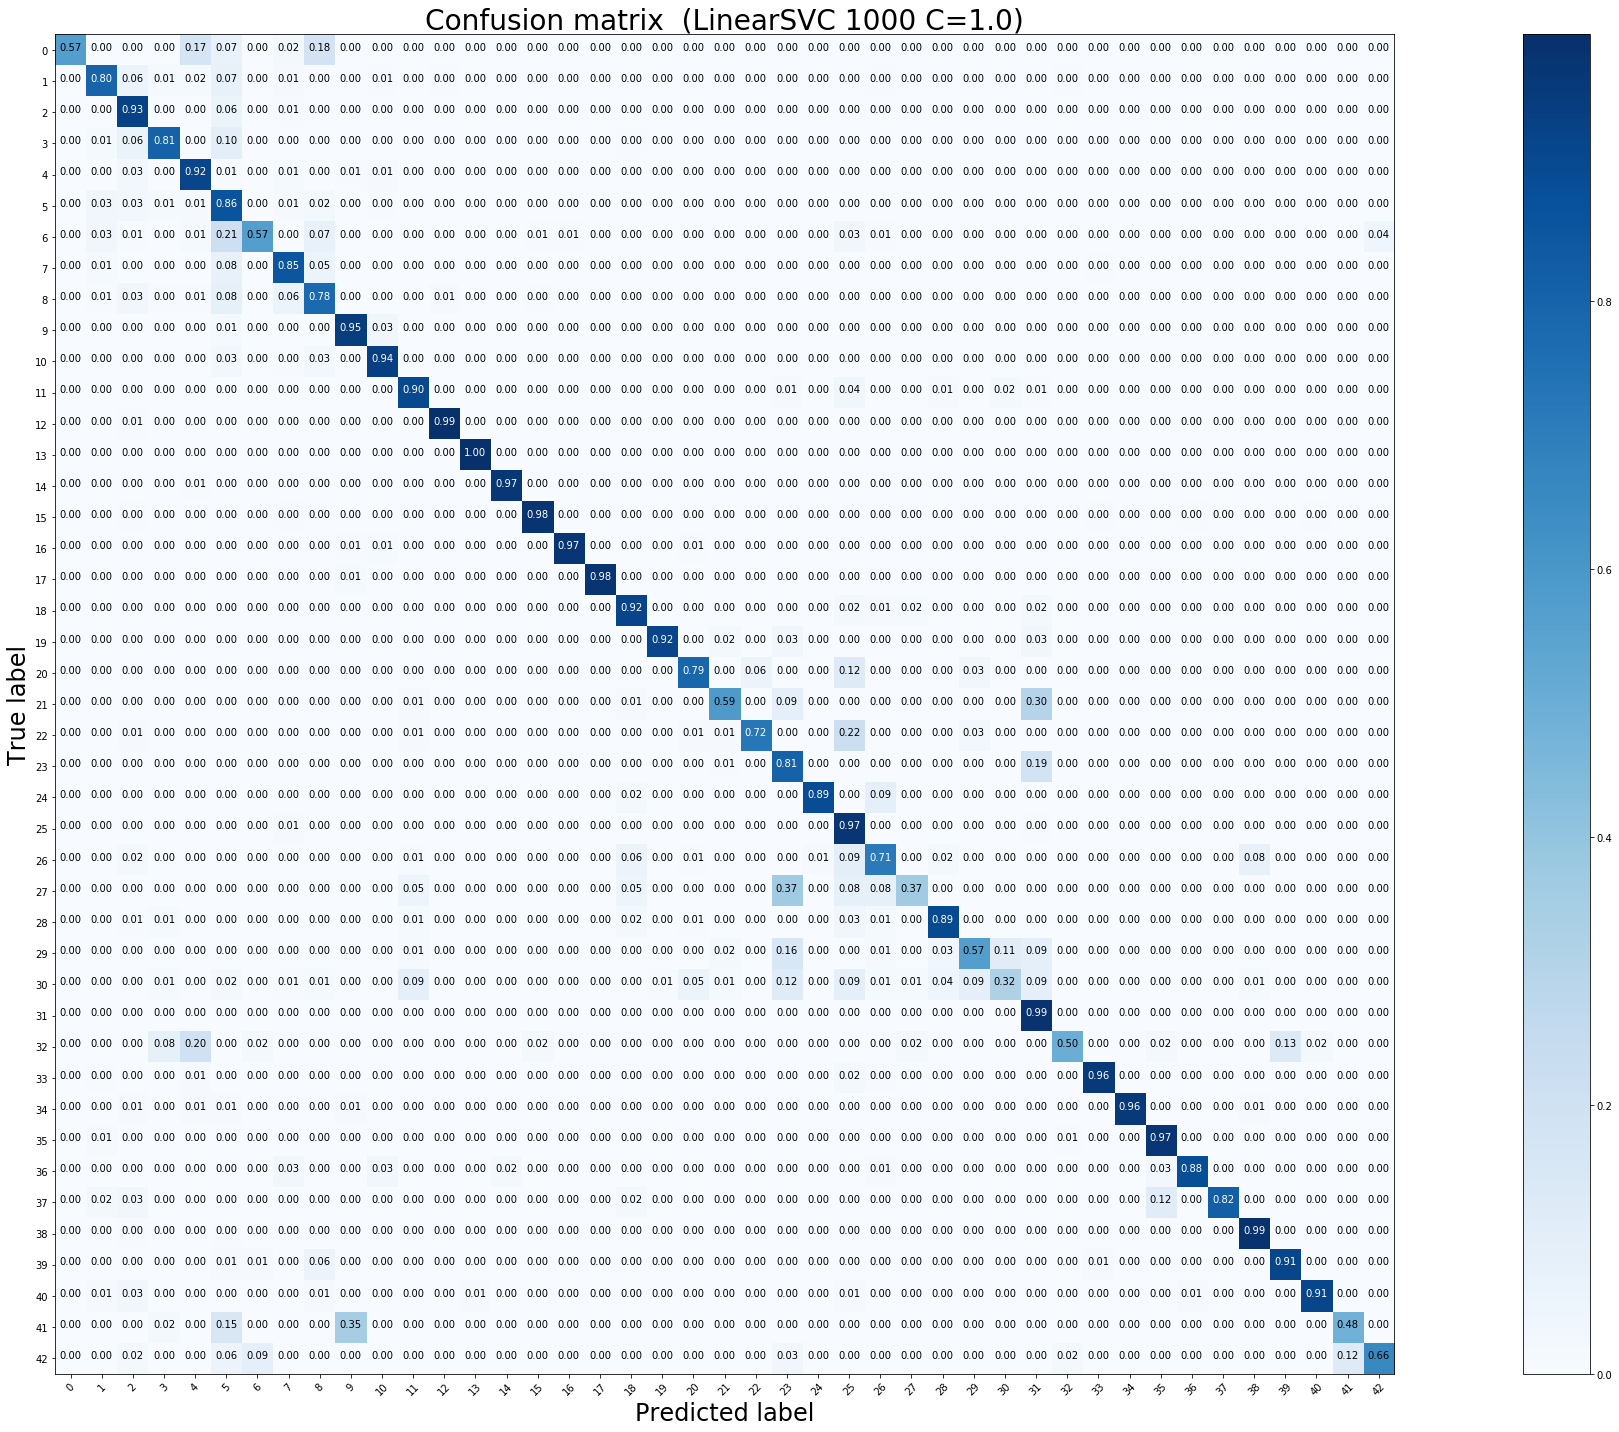

Test accuracy:  0.8874901029295329 

              precision    recall  f1-score   support

           0       0.97      0.57      0.72        60
           1       0.92      0.80      0.85       720
           2       0.82      0.93      0.87       750
           3       0.91      0.81      0.86       450
           4       0.92      0.92      0.92       660
           5       0.64      0.86      0.74       630
           6       0.87      0.57      0.69       150
           7       0.84      0.85      0.85       450
           8       0.79      0.78      0.78       450
           9       0.93      0.95      0.94       480
          10       0.94      0.94      0.94       660
          11       0.94      0.90      0.92       420
          12       0.98      0.99      0.99       690
          13       0.99      1.00      1.00       720
          14       0.98      0.97      0.98       270
          15       0.97      0.98      0.97       210
          16       0.97      0.97      0.97 

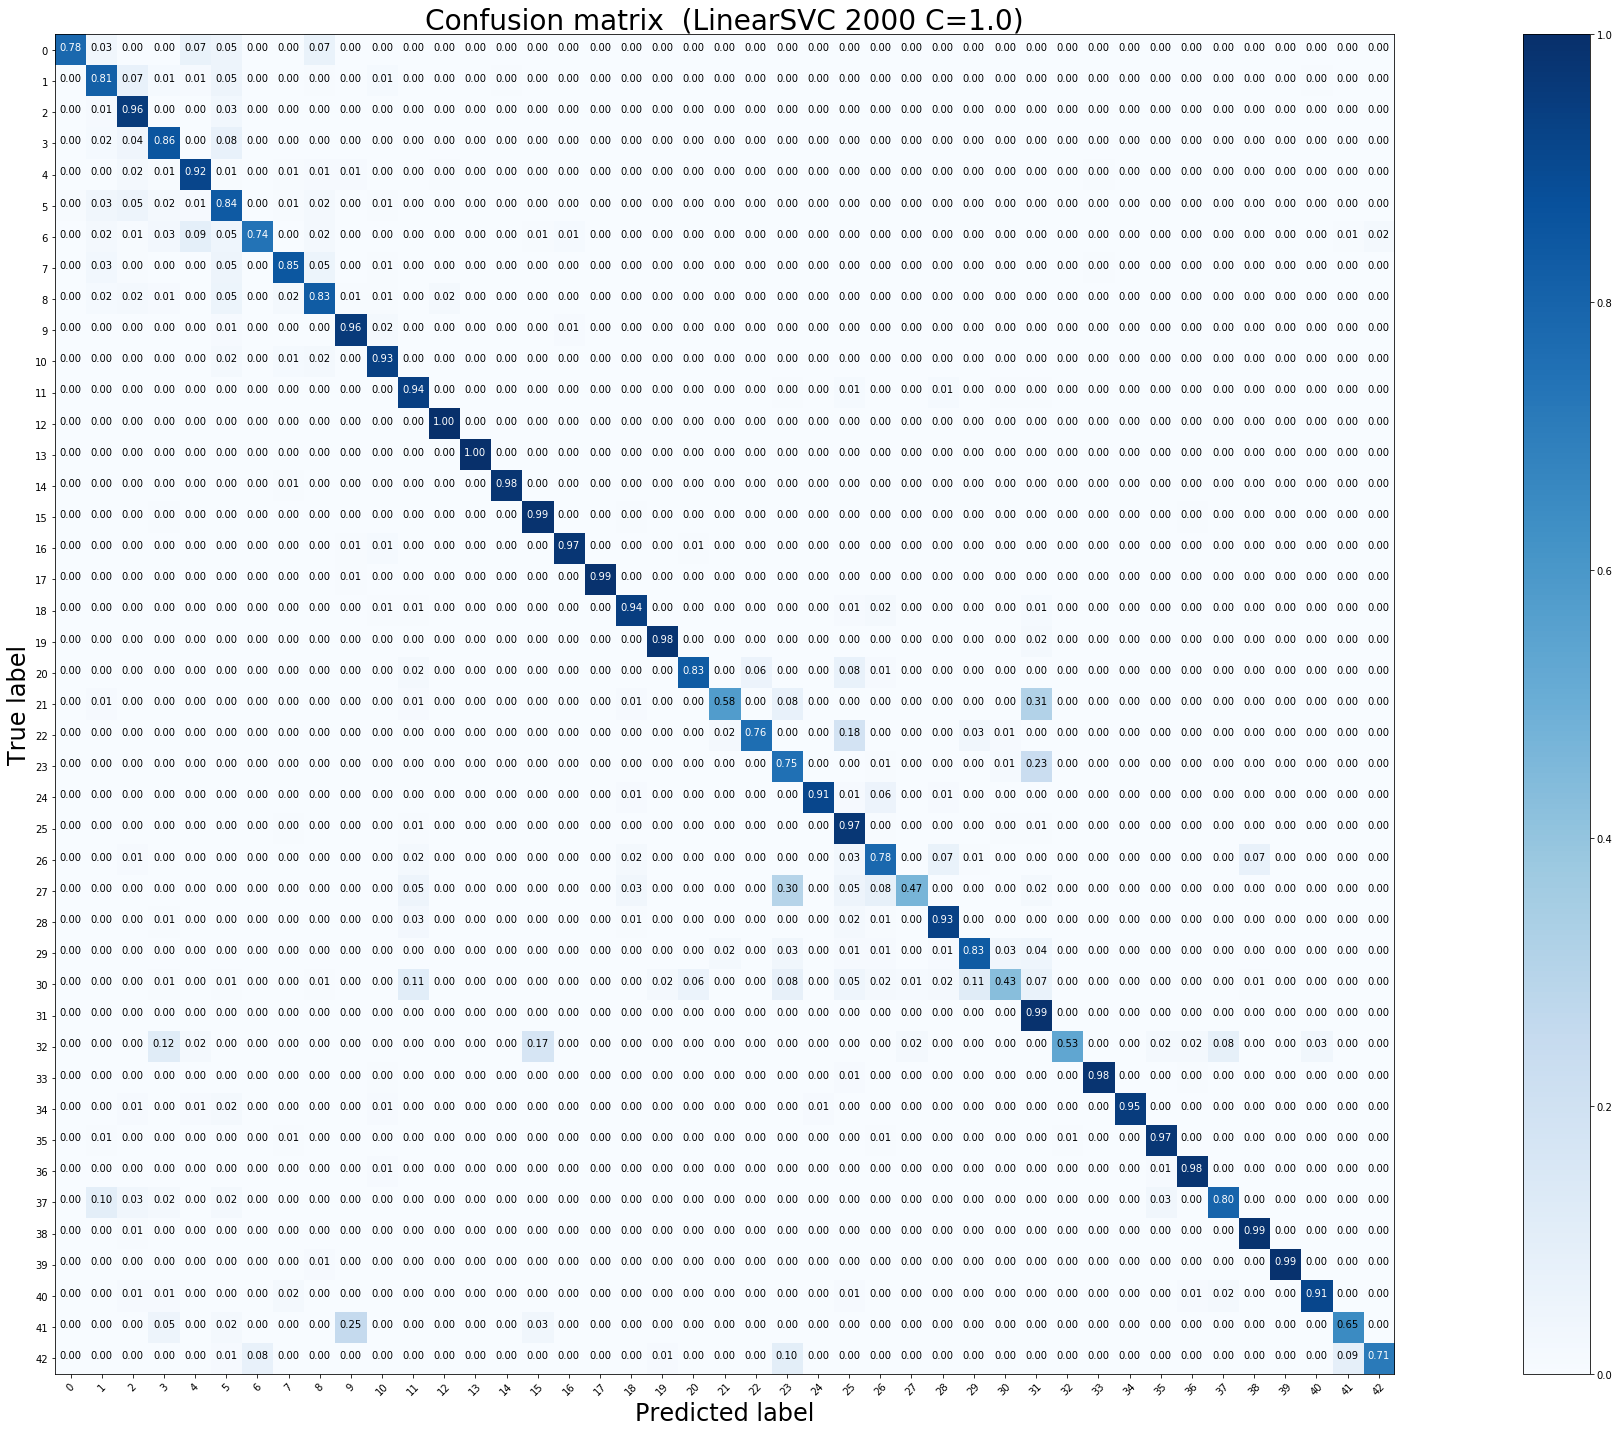

Test accuracy:  0.9073634204275535 

              precision    recall  f1-score   support

           0       0.90      0.78      0.84        60
           1       0.89      0.81      0.85       720
           2       0.84      0.96      0.89       750
           3       0.88      0.86      0.87       450
           4       0.94      0.92      0.93       660
           5       0.75      0.84      0.79       630
           6       0.93      0.74      0.82       150
           7       0.91      0.85      0.88       450
           8       0.85      0.83      0.84       450
           9       0.93      0.96      0.94       480
          10       0.93      0.93      0.93       660
          11       0.92      0.94      0.93       420
          12       0.98      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.98      0.98      0.98       270
          15       0.92      0.99      0.95       210
          16       0.94      0.97      0.96 

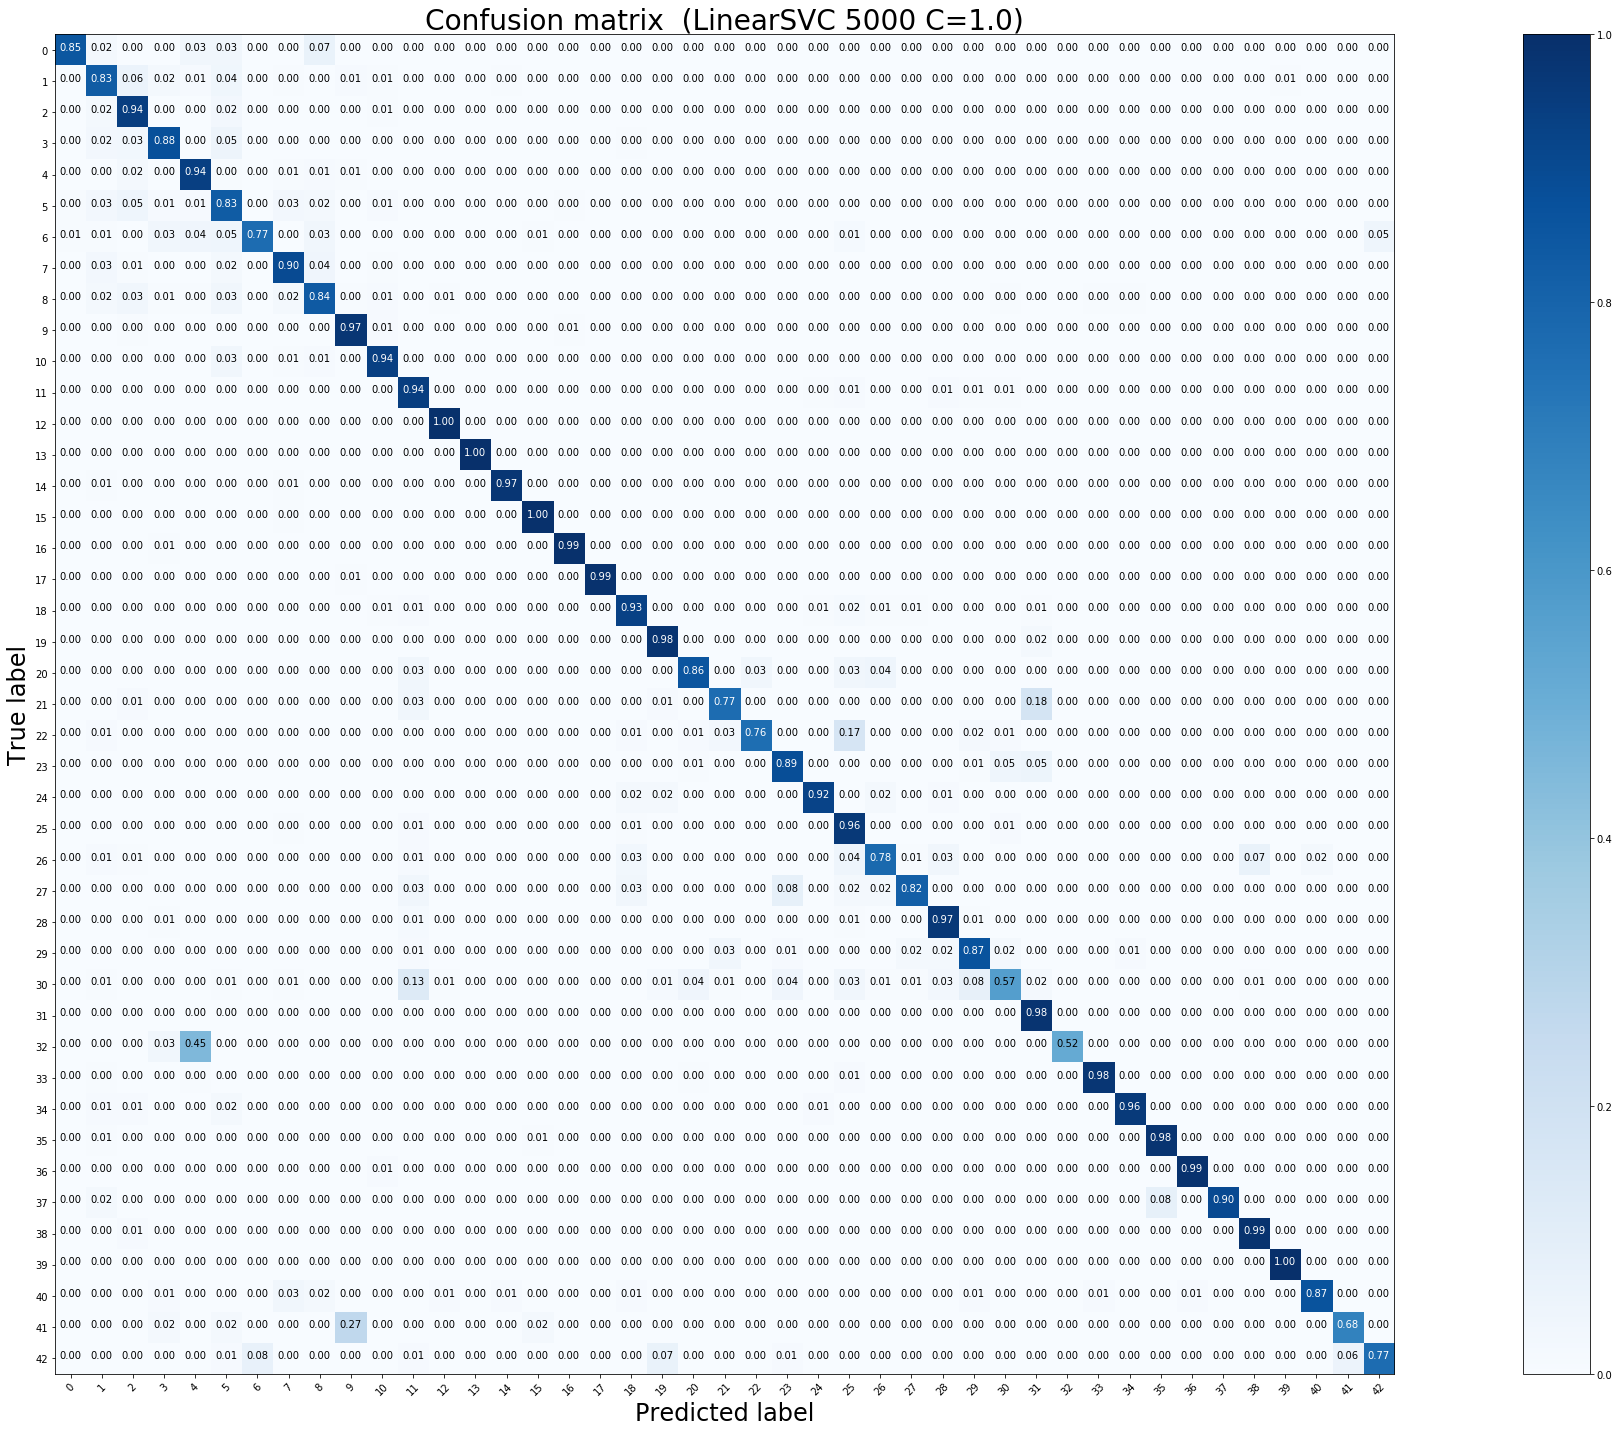

Test accuracy:  0.9197149643705463 

              precision    recall  f1-score   support

           0       0.89      0.85      0.87        60
           1       0.88      0.83      0.85       720
           2       0.84      0.94      0.89       750
           3       0.91      0.88      0.89       450
           4       0.92      0.94      0.93       660
           5       0.80      0.83      0.81       630
           6       0.93      0.77      0.84       150
           7       0.89      0.90      0.89       450
           8       0.87      0.84      0.85       450
           9       0.93      0.97      0.95       480
          10       0.95      0.94      0.94       660
          11       0.89      0.94      0.92       420
          12       0.99      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.98      0.97      0.98       270
          15       0.96      1.00      0.98       210
          16       0.96      0.99      0.97 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


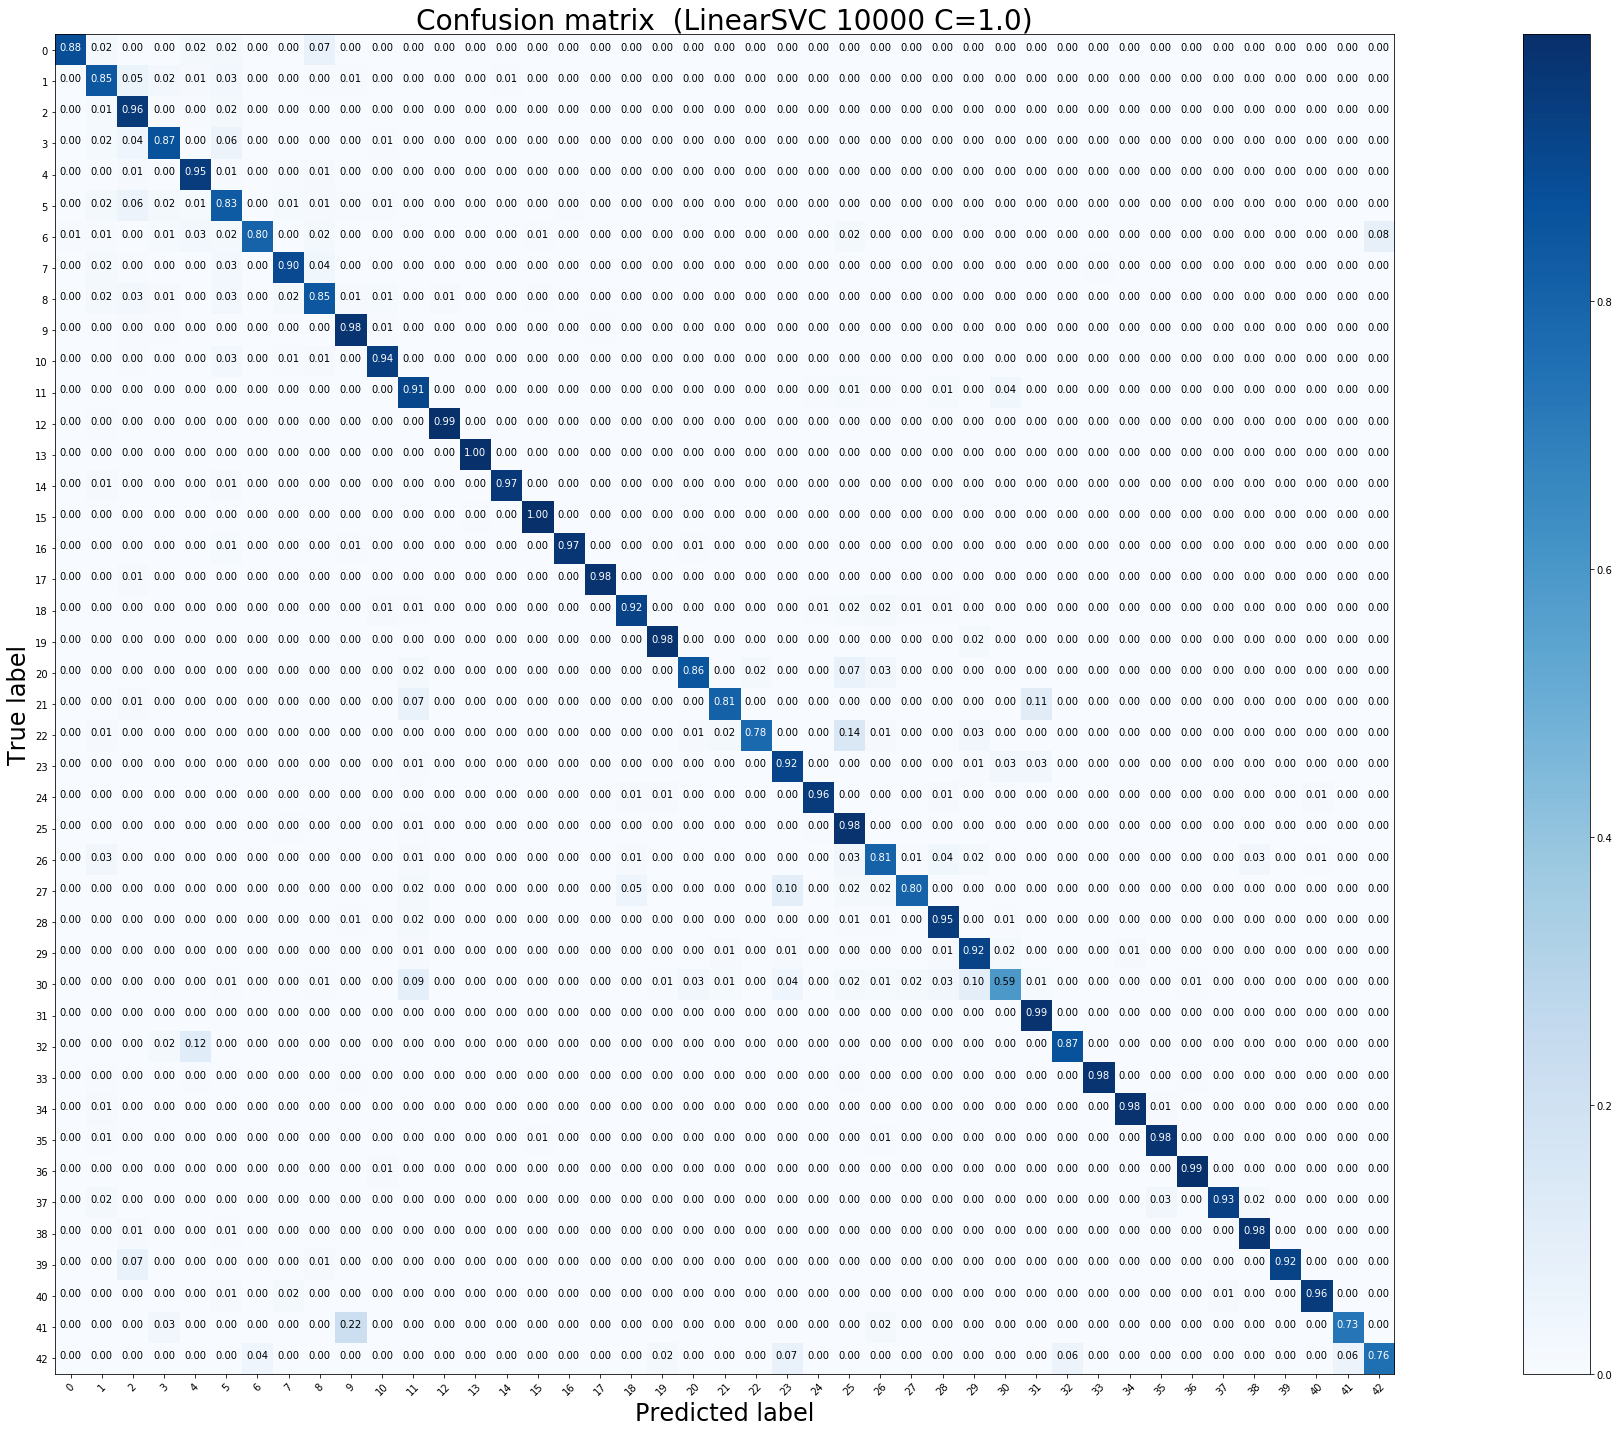

Test accuracy:  0.9265241488519398 

              precision    recall  f1-score   support

           0       0.91      0.88      0.90        60
           1       0.90      0.85      0.87       720
           2       0.84      0.96      0.89       750
           3       0.89      0.87      0.88       450
           4       0.94      0.95      0.95       660
           5       0.81      0.83      0.82       630
           6       0.96      0.80      0.87       150
           7       0.93      0.90      0.91       450
           8       0.89      0.85      0.87       450
           9       0.93      0.98      0.95       480
          10       0.96      0.94      0.95       660
          11       0.91      0.91      0.91       420
          12       0.99      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       0.98      0.97      0.97       270
          15       0.96      1.00      0.98       210
          16       0.98      0.97      0.98 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


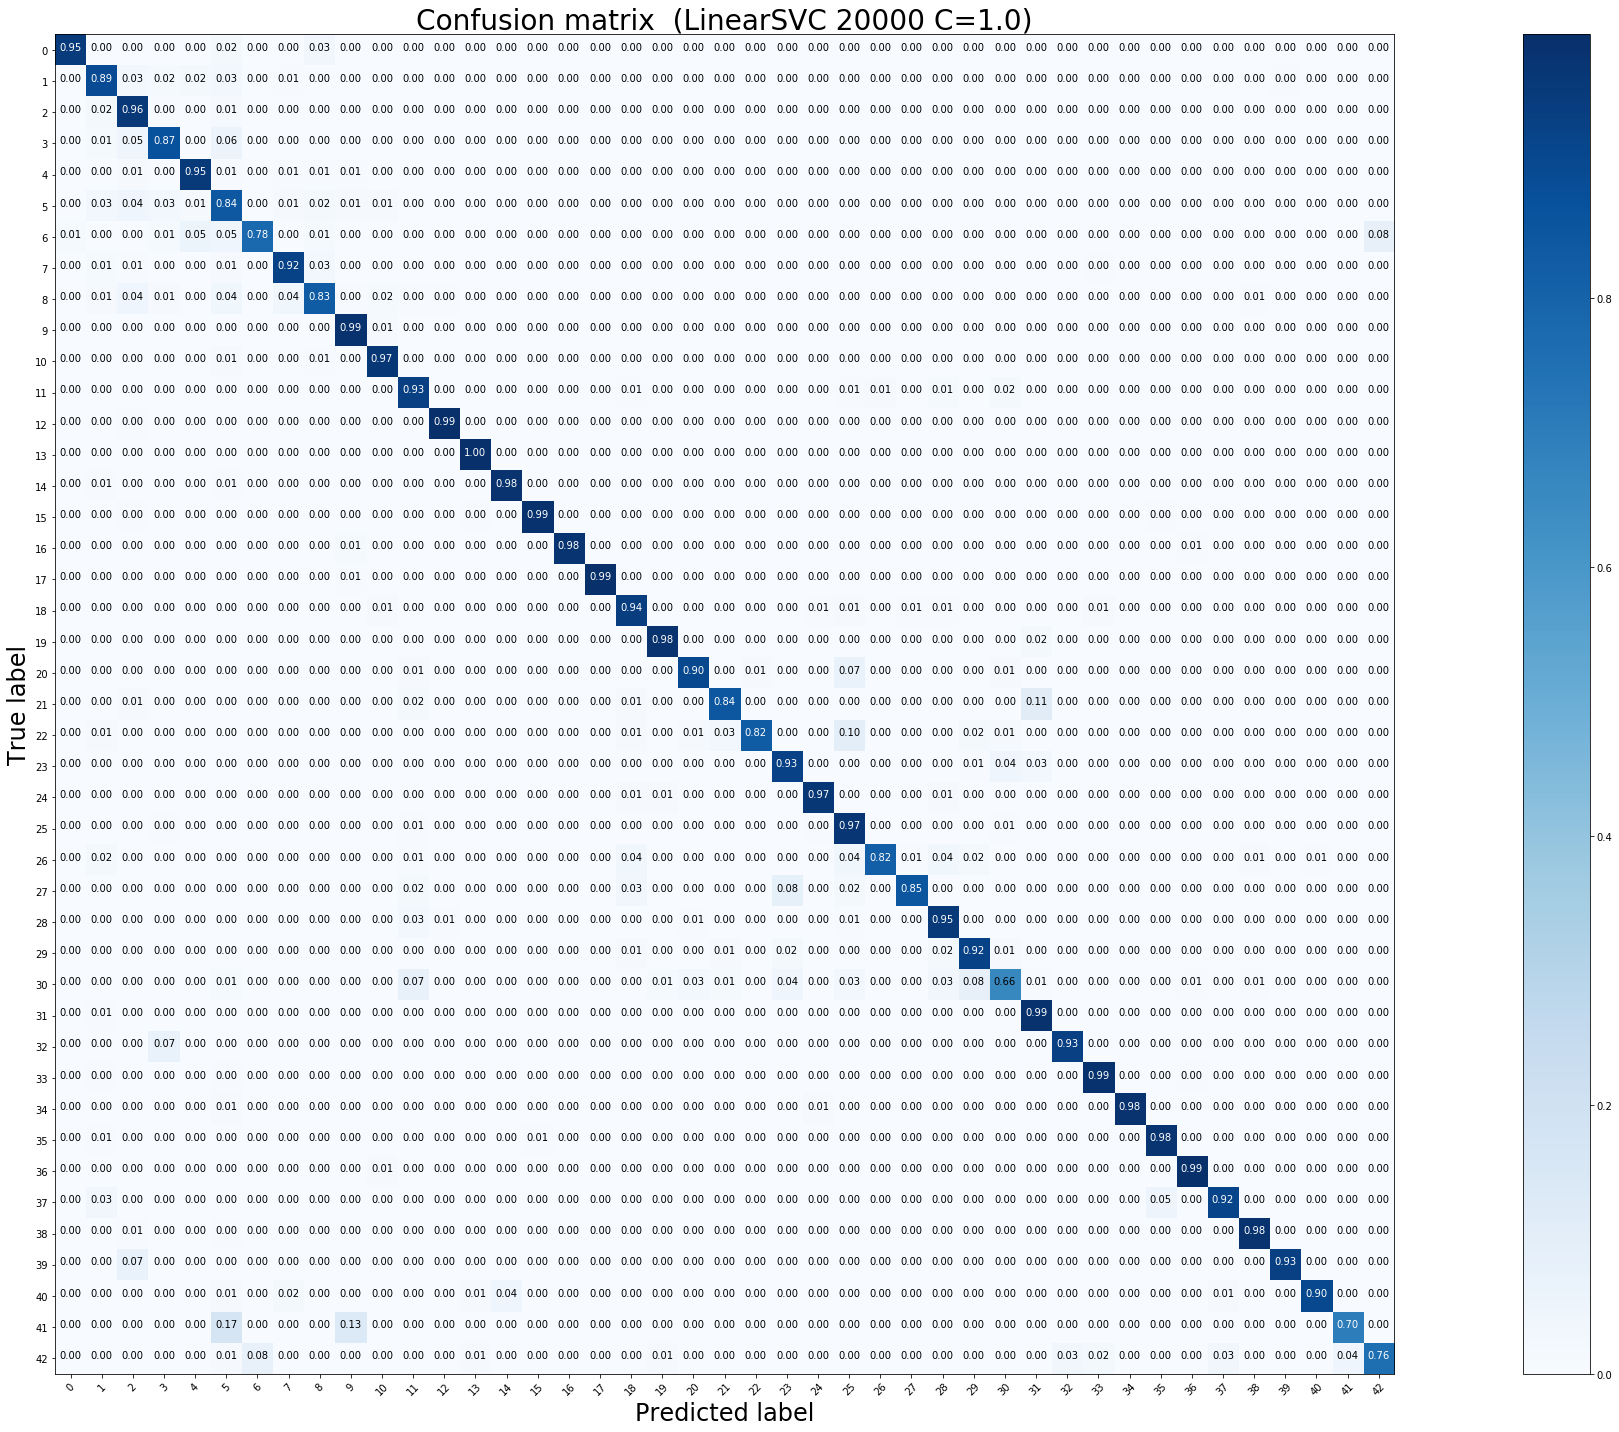

Test accuracy:  0.9348376880443389 

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        60
           1       0.91      0.89      0.90       720
           2       0.86      0.96      0.91       750
           3       0.89      0.87      0.88       450
           4       0.95      0.95      0.95       660
           5       0.82      0.84      0.83       630
           6       0.94      0.78      0.85       150
           7       0.91      0.92      0.92       450
           8       0.91      0.83      0.87       450
           9       0.95      0.99      0.97       480
          10       0.96      0.97      0.97       660
          11       0.93      0.93      0.93       420
          12       0.99      0.99      0.99       690
          13       0.99      1.00      1.00       720
          14       0.97      0.98      0.97       270
          15       0.98      0.99      0.98       210
          16       0.99      0.98      0.98 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


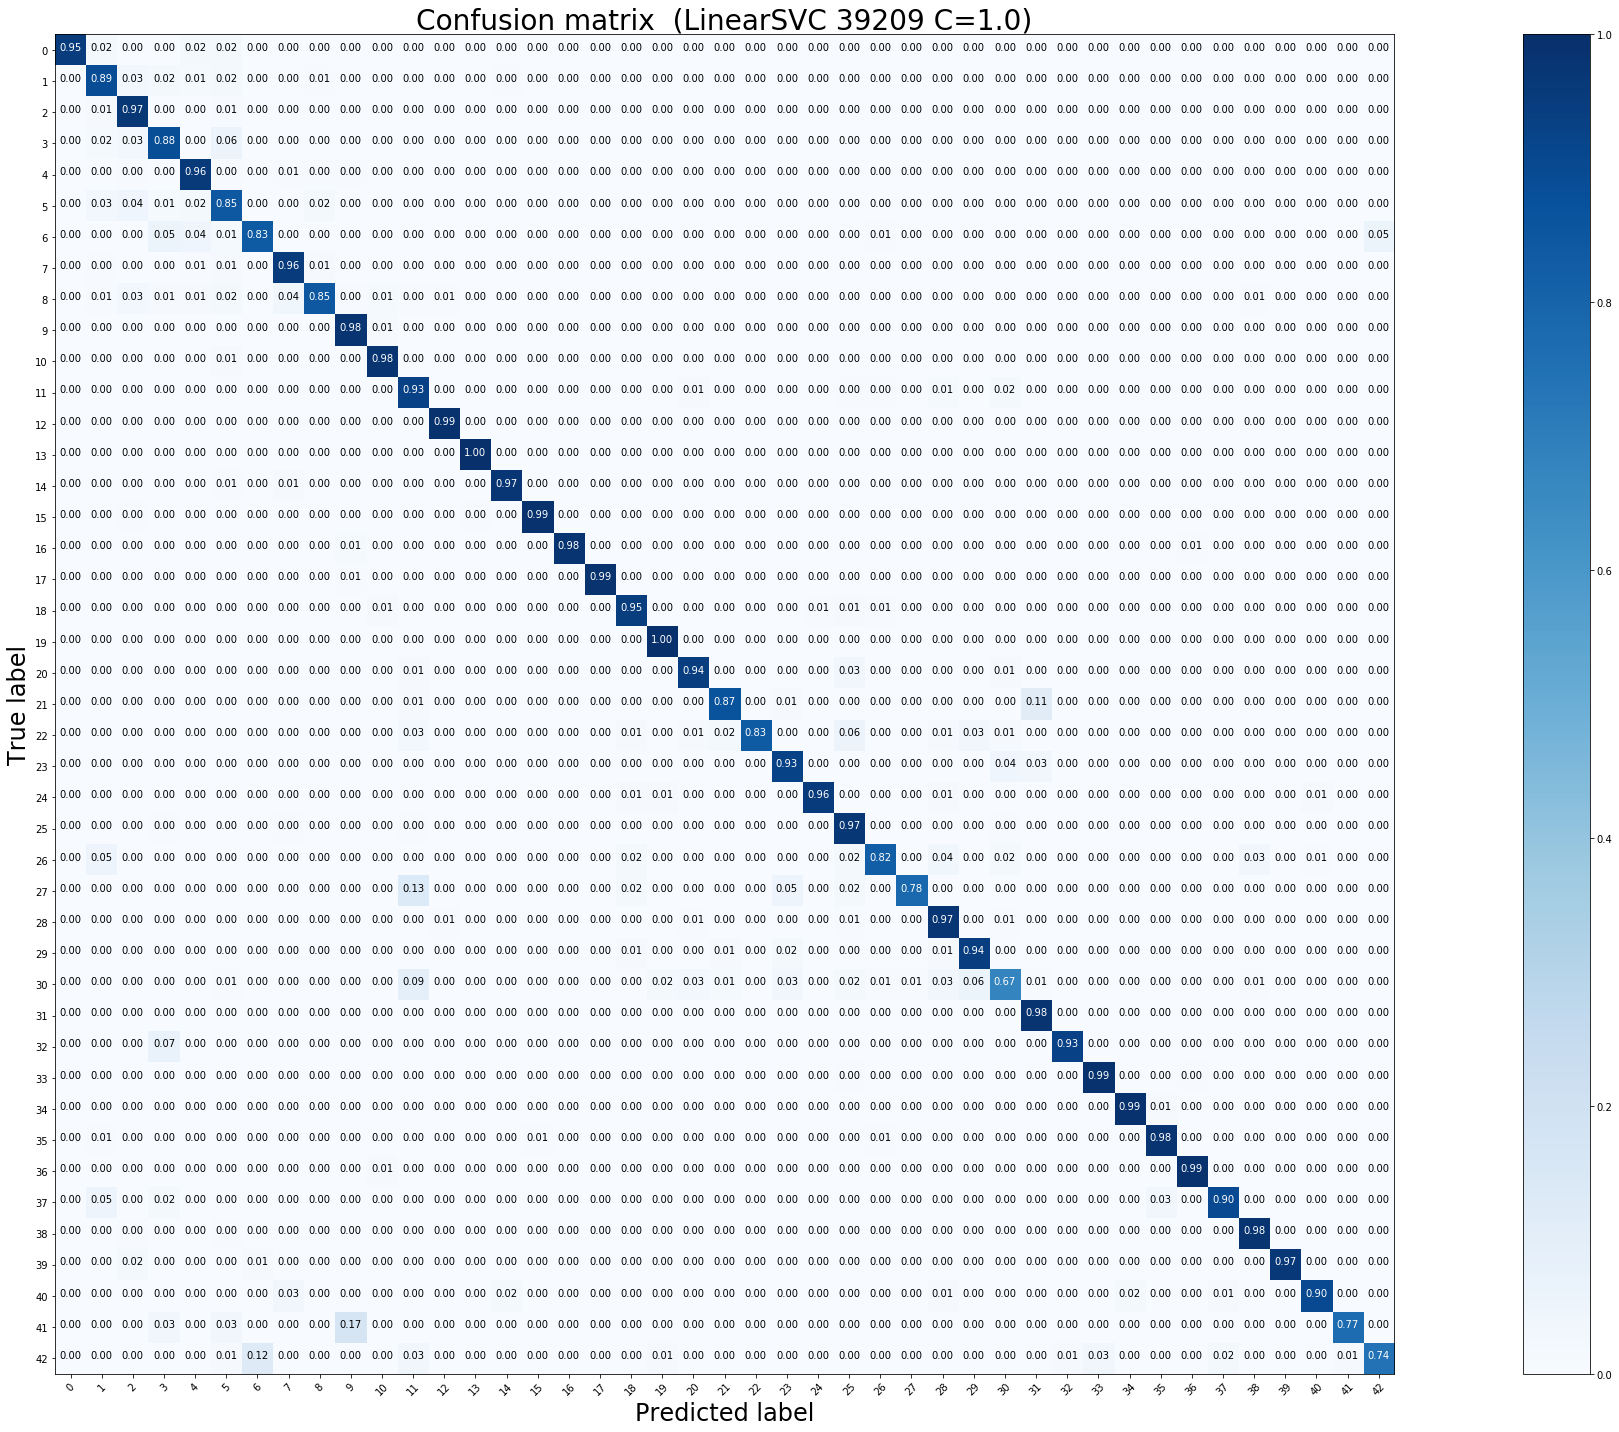

Test accuracy:  0.9409342834520982 

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        60
           1       0.91      0.89      0.90       720
           2       0.90      0.97      0.94       750
           3       0.89      0.88      0.89       450
           4       0.94      0.96      0.95       660
           5       0.87      0.85      0.86       630
           6       0.91      0.83      0.87       150
           7       0.93      0.96      0.94       450
           8       0.93      0.85      0.89       450
           9       0.95      0.98      0.97       480
          10       0.97      0.98      0.98       660
          11       0.92      0.93      0.93       420
          12       0.99      0.99      0.99       690
          13       0.99      1.00      1.00       720
          14       0.96      0.97      0.97       270
          15       0.97      0.99      0.98       210
          16       0.99      0.98      0.98 

In [5]:
##############################################################################
###########   LinearSVC, HOG, hinge, seed=1, random_A, without_scaler ########
###########   Defaultwerte   #################################################
##############################################################################

train_LinearSVC(X_tr_500, X_test_9_4_2, y_tr_500, y_test, 1, '500',1.0, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "HOG_942_balanced.pkl")
train_LinearSVC(X_tr_1000, X_test_9_4_2, y_tr_1000, y_test, 1, '1000',1.0, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "HOG_942_balanced.pkl")
train_LinearSVC(X_tr_2000, X_test_9_4_2, y_tr_2000, y_test, 1, '2000',1.0, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "HOG_942_balanced.pkl")
train_LinearSVC(X_tr_5000, X_test_9_4_2, y_tr_5000, y_test, 1, '5000',1.0, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "HOG_942_balanced.pkl")
train_LinearSVC(X_tr_10000, X_test_9_4_2, y_tr_10000, y_test, 1, '10000',1.0, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "HOG_942_balanced.pkl")
train_LinearSVC(X_tr_20000, X_test_9_4_2, y_tr_20000, y_test, 1, '20000',1.0, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "HOG_942_balanced.pkl")
train_LinearSVC(X_tr, X_test_9_4_2, y_tr, y_test, 1, '39209',1.0, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "HOG_942_balanced.pkl")

In [4]:
#########################################################################
#### GridSearch, LinearSVC, hinge  ######################################
#### 1. Durchlauf  ######################################################
#########################################################################
print('********************************************************************************')
print(' GridSearch 500 1. DL: ')
clf_500_lin, time_500_lin = tuning_hyper_params(X_tr_500, y_tr_500, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2), 'l2', 'hinge', 1)
save_trained_model_as_pkl(clf_500_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/500/seed_1_random_A_without_scaler/GridSearch_1DL.pkl")
save_as_csv(time_500_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/500/seed_1_random_A_without_scaler/", 'Suchzeiten_GridSearch_1_DL.csv')
print('********************************************************************************')
print(' GridSearch 1000 1. DL: ')
clf_1000_lin, time_1000_lin = tuning_hyper_params(X_tr_1000, y_tr_1000, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'hinge', 1)
save_trained_model_as_pkl(clf_1000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/1000/seed_1_random_A_without_scaler/GridSearch_1DL.pkl")
save_as_csv(time_1000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/1000/seed_1_random_A_without_scaler/", 'Suchzeiten_GridSearch_1_DL.csv')
print('********************************************************************************')
print(' GridSearch 2000 1. DL: ')
clf_2000_lin, time_2000_lin = tuning_hyper_params(X_tr_2000, y_tr_2000, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'hinge', 1)
save_trained_model_as_pkl(clf_2000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/2000/seed_1_random_A_without_scaler/GridSearch_1DL.pkl")
save_as_csv(time_2000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/2000/seed_1_random_A_without_scaler/", 'Suchzeiten_GridSearch_1_DL.csv')
print('********************************************************************************')
print(' GridSearch 5000 1. DL: ')
clf_5000_lin, time_5000_lin = tuning_hyper_params(X_tr_5000, y_tr_5000, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'hinge', 1)
save_trained_model_as_pkl(clf_5000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/5000/seed_1_random_A_without_scaler/GridSearch_1DL.pkl")
save_as_csv(time_5000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/5000/seed_1_random_A_without_scaler/", 'Suchzeiten_GridSearch_1_DL.csv')

print('********************************************************************************')
print(' GridSearch 10000 1. DL: ')
print('')
clf_10000_lin, time_10000_lin = tuning_hyper_params(X_tr_10000, y_tr_10000, X_test_9_4_2, y_test, 'LinearSVC', 5, 0, 0, 
                                                np.logspace(-16,6,12, base=2), np.logspace(-16,4,11, base=2),'l2', 'hinge',1)
save_trained_model_as_pkl(clf_10000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/10000/seed_1_random_A_without_scaler/GridSearch_1DL.pkl")
save_as_csv(time_10000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/10000/seed_1_random_A_without_scaler/", 'Suchzeiten_GridSearch_1_DL.csv')

print('********************************************************************************')
print(' GridSearch 20000 1. DL: ')
print('')
clf_20000_lin, time_20000_lin = tuning_hyper_params(X_tr_20000, y_tr_20000, X_test_9_4_2, y_test, 'LinearSVC', 3, 0, 0, 
                                                np.logspace(-16,6,12, base=2), np.logspace(-16,4,11, base=2),'l2', 'hinge',1)
save_trained_model_as_pkl(clf_20000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/20000/seed_1_random_A_without_scaler/GridSearch_1DL.pkl")
save_as_csv(time_20000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/20000/seed_1_random_A_without_scaler/", 'Suchzeiten_GridSearch_1_DL.csv')

print('********************************************************************************')
print(' GridSearch 39209 1. DL: ')
print('')
clf_39209_lin, time_39209_lin = tuning_hyper_params(X_train_9_4_2, y_train, X_test_9_4_2, y_test, 'LinearSVC', 3, 0, 0, 
                                                np.logspace(-16,6,12, base=2), np.logspace(-16,4,11, base=2),'l2', 'hinge',1)
save_trained_model_as_pkl(clf_39209_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/39209/seed_1_random_A_without_scaler/GridSearch_1DL.pkl")
save_as_csv(time_39209_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/39209/seed_1_random_A_without_scaler/", 'Suchzeiten_GridSearch_1_DL.csv')

********************************************************************************
 GridSearch 500 1. DL: 


C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range: [1.52587891e-05 6.10351562e-05 2.44140625e-04 9.76562500e-04
 3.90625000e-03 1.56250000e-02 6.25000000e-02 2.50000000e-01
 1.00000000e+00 4.00000000e+00 1.60000000e+01 6.40000000e+01
 2.56000000e+02 1.02400000e+03]

 Bester Score:  0.784938574159119

 Besten Parameter:  {'svm__C': 0.25}
Bester Estimator score:  0.844338875692795
Precision-Score: 0.179319 (0.066756) mit Parameter: {'svm__C': 1.52587890625e-05}
Precision-Score: 0.371439 (0.130169) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.535574 (0.073493) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.669858 (0.091336) mit Parameter: {'svm__C': 0.0009765625}
Precision-Score: 0.723224 (0.064536) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.765071 (0.066059) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.782998 (0.104505) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.783312 (0.121532) mit Parameter: {'svm__C': 0.25}
Precision-Score: 0.782502 (0.120956) mit Parameter: 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range: [1.52587891e-05 6.10351562e-05 2.44140625e-04 9.76562500e-04
 3.90625000e-03 1.56250000e-02 6.25000000e-02 2.50000000e-01
 1.00000000e+00 4.00000000e+00 1.60000000e+01 6.40000000e+01
 2.56000000e+02 1.02400000e+03]

 Bester Score:  0.8970408067752464

 Besten Parameter:  {'svm__C': 0.0625}
Bester Estimator score:  0.8929532858273951
Precision-Score: 0.133828 (0.014286) mit Parameter: {'svm__C': 1.52587890625e-05}
Precision-Score: 0.445095 (0.070008) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.690008 (0.047477) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.780442 (0.047696) mit Parameter: {'svm__C': 0.0009765625}
Precision-Score: 0.821776 (0.058825) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.869272 (0.055235) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.897739 (0.044508) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.893948 (0.045077) mit Parameter: {'svm__C': 0.25}
Precision-Score: 0.890808 (0.041606) mit Paramet


 C_range: [1.52587891e-05 6.10351562e-05 2.44140625e-04 9.76562500e-04
 3.90625000e-03 1.56250000e-02 6.25000000e-02 2.50000000e-01
 1.00000000e+00 4.00000000e+00 1.60000000e+01 6.40000000e+01
 2.56000000e+02 1.02400000e+03]

 Bester Score:  0.9603704868002108

 Besten Parameter:  {'svm__C': 0.25}
Bester Estimator score:  0.9243072050673001
Precision-Score: 0.674544 (0.040292) mit Parameter: {'svm__C': 1.52587890625e-05}
Precision-Score: 0.859659 (0.020758) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.892854 (0.015902) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.901618 (0.013844) mit Parameter: {'svm__C': 0.0009765625}
Precision-Score: 0.924254 (0.012155) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.942809 (0.014288) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.959504 (0.014208) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.966254 (0.011037) mit Parameter: {'svm__C': 0.25}
Precision-Score: 0.965591 (0.009712) mit Parameter


 C_range: [1.52587891e-05 6.10351562e-05 2.44140625e-04 9.76562500e-04
 3.90625000e-03 1.56250000e-02 6.25000000e-02 2.50000000e-01
 1.00000000e+00 4.00000000e+00 1.60000000e+01 6.40000000e+01]

 Bester Score:  0.974461632027531

 Besten Parameter:  {'svm__C': 0.25}
Bester Estimator score:  0.9391132224861442
Precision-Score: 0.888251 (0.005973) mit Parameter: {'svm__C': 1.52587890625e-05}
Precision-Score: 0.900665 (0.005219) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.907486 (0.003780) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.917087 (0.001621) mit Parameter: {'svm__C': 0.0009765625}
Precision-Score: 0.938952 (0.002116) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.957453 (0.001058) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.968700 (0.002036) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.974841 (0.000786) mit Parameter: {'svm__C': 0.25}
Precision-Score: 0.974744 (0.000806) mit Parameter: {'svm__C': 1.0}
Precision-Scor

In [5]:
#########################################################################
#### GridSearch, LinearSVC, hinge  ######################################
#### 2. Durchlauf  ######################################################
#########################################################################
print('********************************************************************************')
print(' GridSearch 500 2. DL: ')
clf_500_lin, time_500_lin = tuning_hyper_params(X_tr_500, y_tr_500, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                get_finer_range(0.25), np.logspace(-16,4,11, base=2), 'l2', 'hinge', 1)
save_trained_model_as_pkl(clf_500_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/500/seed_1_random_A_without_scaler/GridSearch_2DL.pkl")
save_as_csv(time_500_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/500/seed_1_random_A_without_scaler/", 'Suchzeiten_GridSearch_2_DL.csv')
print('********************************************************************************')
print(' GridSearch 1000 2. DL: ')
clf_1000_lin, time_1000_lin = tuning_hyper_params(X_tr_1000, y_tr_1000, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                get_finer_range(0.0625), np.logspace(-16,4,11, base=2),'l2', 'hinge', 1)
save_trained_model_as_pkl(clf_1000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/1000/seed_1_random_A_without_scaler/GridSearch_2DL.pkl")
save_as_csv(time_1000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/1000/seed_1_random_A_without_scaler/", 'Suchzeiten_GridSearch_2_DL.csv')
print('********************************************************************************')
print(' GridSearch 2000 2. DL: ')
clf_2000_lin, time_2000_lin = tuning_hyper_params(X_tr_2000, y_tr_2000, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                get_finer_range(0.0625), np.logspace(-16,4,11, base=2),'l2', 'hinge', 1)
save_trained_model_as_pkl(clf_2000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/2000/seed_1_random_A_without_scaler/GridSearch_2DL.pkl")
save_as_csv(time_2000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/2000/seed_1_random_A_without_scaler/", 'Suchzeiten_GridSearch_2_DL.csv')
print('********************************************************************************')
print(' GridSearch 5000 2. DL: ')
clf_5000_lin, time_5000_lin = tuning_hyper_params(X_tr_5000, y_tr_5000, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                get_finer_range(0.25), np.logspace(-16,4,11, base=2),'l2', 'hinge', 1)
save_trained_model_as_pkl(clf_5000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/5000/seed_1_random_A_without_scaler/GridSearch_2DL.pkl")
save_as_csv(time_5000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/5000/seed_1_random_A_without_scaler/", 'Suchzeiten_GridSearch_2_DL.csv')

print('********************************************************************************')
print(' GridSearch 10000 2. DL: ')
print('')
clf_10000_lin, time_10000_lin = tuning_hyper_params(X_tr_10000, y_tr_10000, X_test_9_4_2, y_test, 'LinearSVC', 5, 0, 0, 
                                                get_finer_range(0.25), np.logspace(-16,4,11, base=2),'l2', 'hinge',1)
save_trained_model_as_pkl(clf_10000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/10000/seed_1_random_A_without_scaler/GridSearch_2DL.pkl")
save_as_csv(time_10000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/10000/seed_1_random_A_without_scaler/", 'Suchzeiten_GridSearch_2_DL.csv')

print('********************************************************************************')
print(' GridSearch 20000 2. DL: ')
print('')
clf_20000_lin, time_20000_lin = tuning_hyper_params(X_tr_20000, y_tr_20000, X_test_9_4_2, y_test, 'LinearSVC', 3, 0, 0, 
                                                get_finer_range(0.25), np.logspace(-16,4,11, base=2),'l2', 'hinge',1)
save_trained_model_as_pkl(clf_20000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/20000/seed_1_random_A_without_scaler/GridSearch_2DL.pkl")
save_as_csv(time_20000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/20000/seed_1_random_A_without_scaler/", 'Suchzeiten_GridSearch_2_DL.csv')

print('********************************************************************************')
print(' GridSearch 39209 2. DL: ')
print('')
clf_39209_lin, time_39209_lin = tuning_hyper_params(X_train_9_4_2, y_train, X_test_9_4_2, y_test, 'LinearSVC', 3, 0, 0, 
                                                get_finer_range(0.0625), np.logspace(-16,4,11, base=2),'l2', 'hinge',1)
save_trained_model_as_pkl(clf_39209_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/39209/seed_1_random_A_without_scaler/GridSearch_2DL.pkl")
save_as_csv(time_39209_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/39209/seed_1_random_A_without_scaler/", 'Suchzeiten_GridSearch_2_DL.csv')

********************************************************************************
 GridSearch 500 2. DL: 


C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range: [0.0625     0.07432544 0.08838835 0.10511205 0.125      0.14865089
 0.1767767  0.2102241  0.25       0.29730178 0.35355339 0.42044821
 0.5        0.59460356 0.70710678 0.84089642 1.        ]

 Bester Score:  0.784938574159119

 Besten Parameter:  {'svm__C': 0.21022410381342863}
Bester Estimator score:  0.844338875692795
Precision-Score: 0.782998 (0.104505) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.774844 (0.105949) mit Parameter: {'svm__C': 0.07432544468767006}
Precision-Score: 0.771934 (0.115245) mit Parameter: {'svm__C': 0.08838834764831845}
Precision-Score: 0.769772 (0.119243) mit Parameter: {'svm__C': 0.10511205190671431}
Precision-Score: 0.775544 (0.120847) mit Parameter: {'svm__C': 0.125}
Precision-Score: 0.775970 (0.118595) mit Parameter: {'svm__C': 0.14865088937534013}
Precision-Score: 0.779828 (0.120373) mit Parameter: {'svm__C': 0.1767766952966369}
Precision-Score: 0.783312 (0.121532) mit Parameter: {'svm__C': 0.21022410381342863}
Precision-Score: 0.7833

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range: [0.015625   0.01858136 0.02209709 0.02627801 0.03125    0.03716272
 0.04419417 0.05255603 0.0625     0.07432544 0.08838835 0.10511205
 0.125      0.14865089 0.1767767  0.2102241  0.25      ]

 Bester Score:  0.8970408067752464

 Besten Parameter:  {'svm__C': 0.0625}
Bester Estimator score:  0.8929532858273951
Precision-Score: 0.869272 (0.055235) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.878992 (0.046917) mit Parameter: {'svm__C': 0.018581361171917516}
Precision-Score: 0.887413 (0.046696) mit Parameter: {'svm__C': 0.02209708691207961}
Precision-Score: 0.888308 (0.049676) mit Parameter: {'svm__C': 0.026278012976678578}
Precision-Score: 0.894816 (0.051036) mit Parameter: {'svm__C': 0.03125}
Precision-Score: 0.895116 (0.046633) mit Parameter: {'svm__C': 0.03716272234383503}
Precision-Score: 0.896745 (0.045802) mit Parameter: {'svm__C': 0.04419417382415922}
Precision-Score: 0.896505 (0.043873) mit Parameter: {'svm__C': 0.052556025953357156}
Precision-Score: 0.897739 


 C_range: [0.0625     0.07432544 0.08838835 0.10511205 0.125      0.14865089
 0.1767767  0.2102241  0.25       0.29730178 0.35355339 0.42044821
 0.5        0.59460356 0.70710678 0.84089642 1.        ]

 Bester Score:  0.9610869296045872

 Besten Parameter:  {'svm__C': 0.1767766952966369}
Bester Estimator score:  0.9252573238321457
Precision-Score: 0.959504 (0.014208) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.962346 (0.014404) mit Parameter: {'svm__C': 0.07432544468767006}
Precision-Score: 0.964096 (0.013804) mit Parameter: {'svm__C': 0.08838834764831845}
Precision-Score: 0.963404 (0.013693) mit Parameter: {'svm__C': 0.10511205190671431}
Precision-Score: 0.964620 (0.013491) mit Parameter: {'svm__C': 0.125}
Precision-Score: 0.965858 (0.010530) mit Parameter: {'svm__C': 0.14865088937534013}
Precision-Score: 0.966396 (0.011157) mit Parameter: {'svm__C': 0.1767766952966369}
Precision-Score: 0.965855 (0.010970) mit Parameter: {'svm__C': 0.21022410381342863}
Precision-Score: 0.966

********************************************************************************
 GridSearch 20000 2. DL: 


 C_range: [0.0625     0.07432544 0.08838835 0.10511205 0.125      0.14865089
 0.1767767  0.2102241  0.25       0.29730178 0.35355339 0.42044821
 0.5        0.59460356 0.70710678 0.84089642 1.        ]

 Bester Score:  0.974461632027531

 Besten Parameter:  {'svm__C': 0.25}
Bester Estimator score:  0.9391132224861442
Precision-Score: 0.968700 (0.002036) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.969690 (0.002178) mit Parameter: {'svm__C': 0.07432544468767006}
Precision-Score: 0.969991 (0.001128) mit Parameter: {'svm__C': 0.08838834764831845}
Precision-Score: 0.970860 (0.000514) mit Parameter: {'svm__C': 0.10511205190671431}
Precision-Score: 0.971880 (0.000110) mit Parameter: {'svm__C': 0.125}
Precision-Score: 0.972704 (0.000459) mit Parameter: {'svm__C': 0.14865088937534013}
Precision-Score: 0.973074 (0.000693) mit Parameter: {'svm__C': 0.1767766952966369}
Precision-Sco

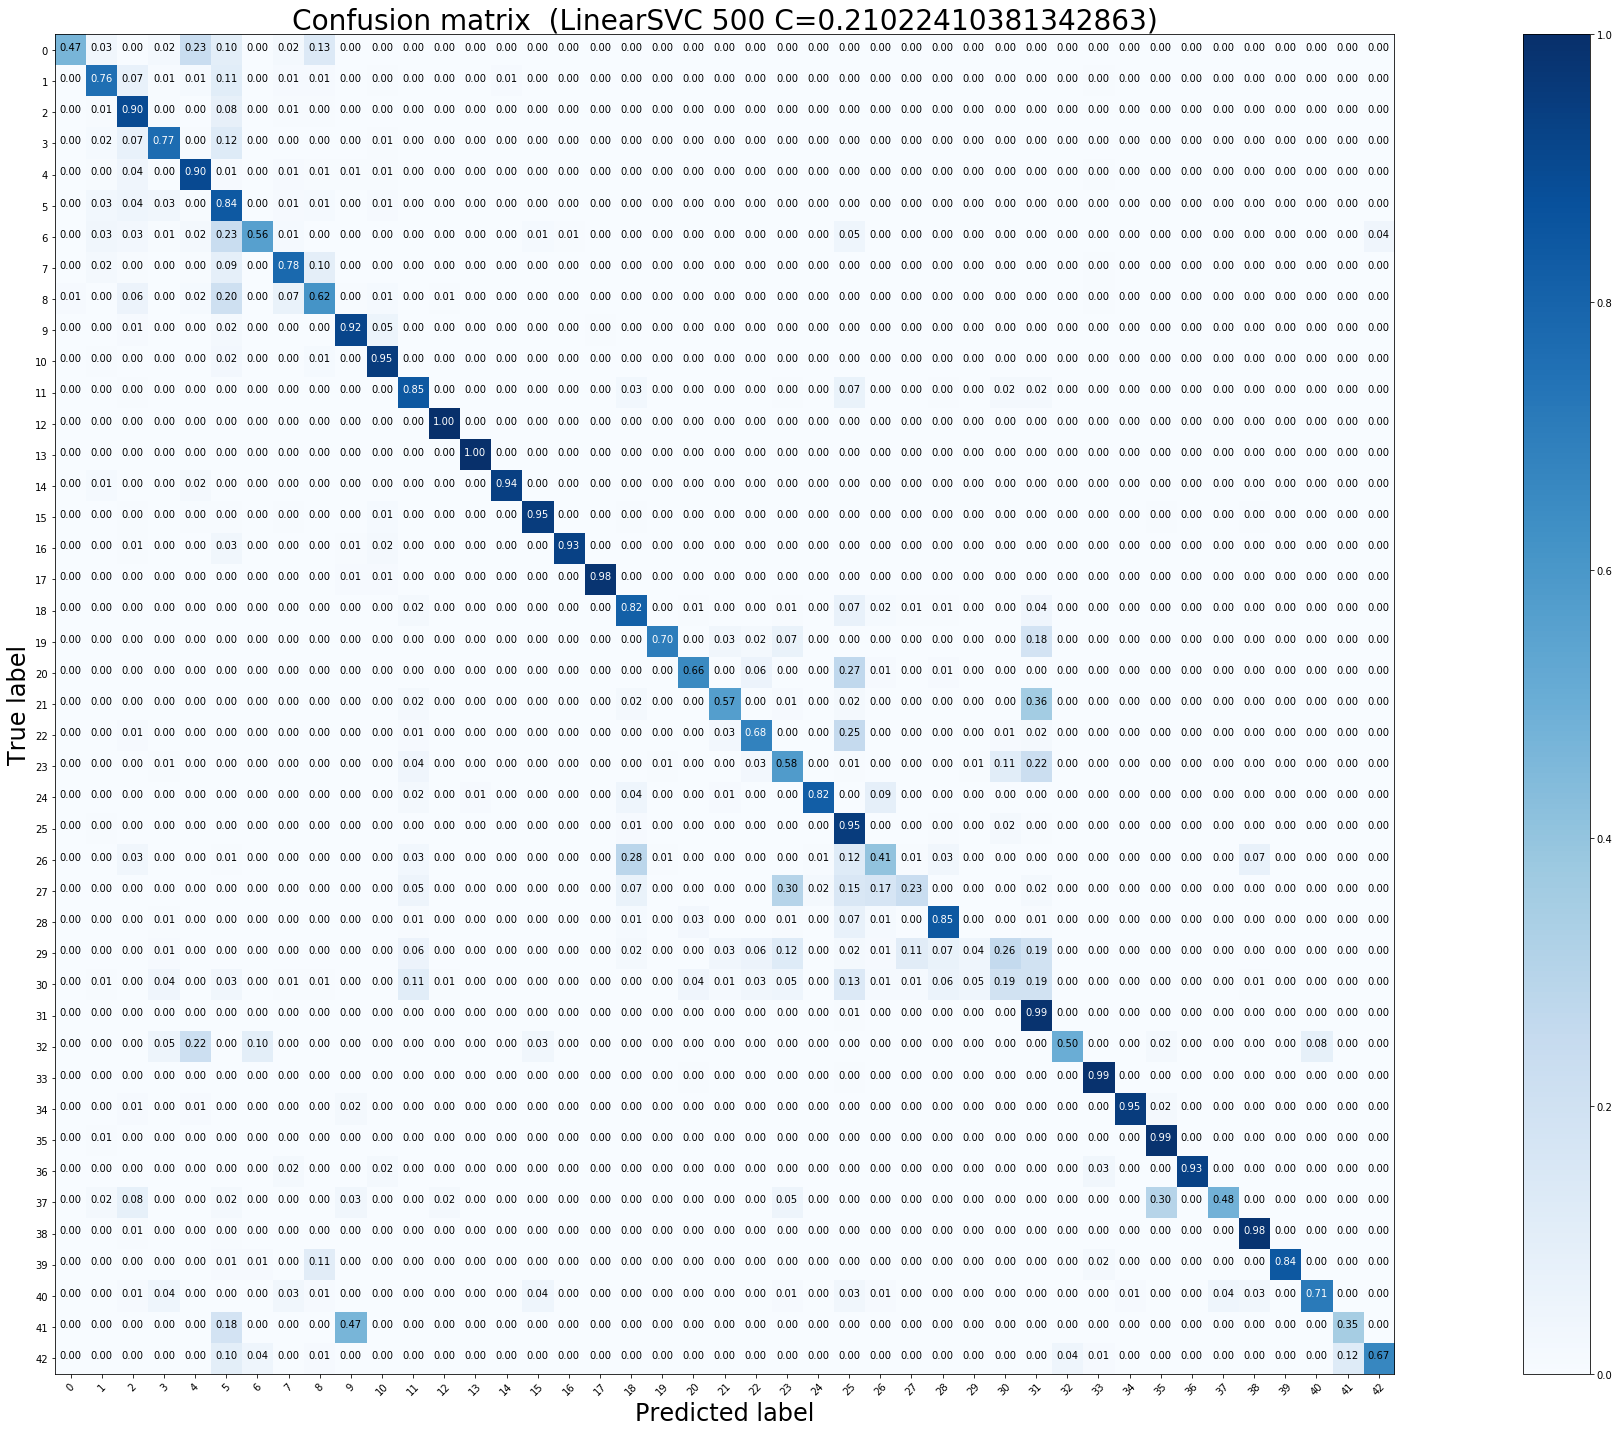

Test accuracy:  0.844338875692795 

              precision    recall  f1-score   support

           0       0.85      0.47      0.60        60
           1       0.89      0.76      0.82       720
           2       0.77      0.90      0.83       750
           3       0.88      0.77      0.82       450
           4       0.91      0.90      0.90       660
           5       0.55      0.84      0.67       630
           6       0.88      0.56      0.69       150
           7       0.84      0.78      0.81       450
           8       0.74      0.62      0.67       450
           9       0.91      0.92      0.91       480
          10       0.91      0.95      0.93       660
          11       0.87      0.85      0.86       420
          12       0.99      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.98      0.94      0.96       270
          15       0.95      0.95      0.95       210
          16       0.99      0.93      0.96  

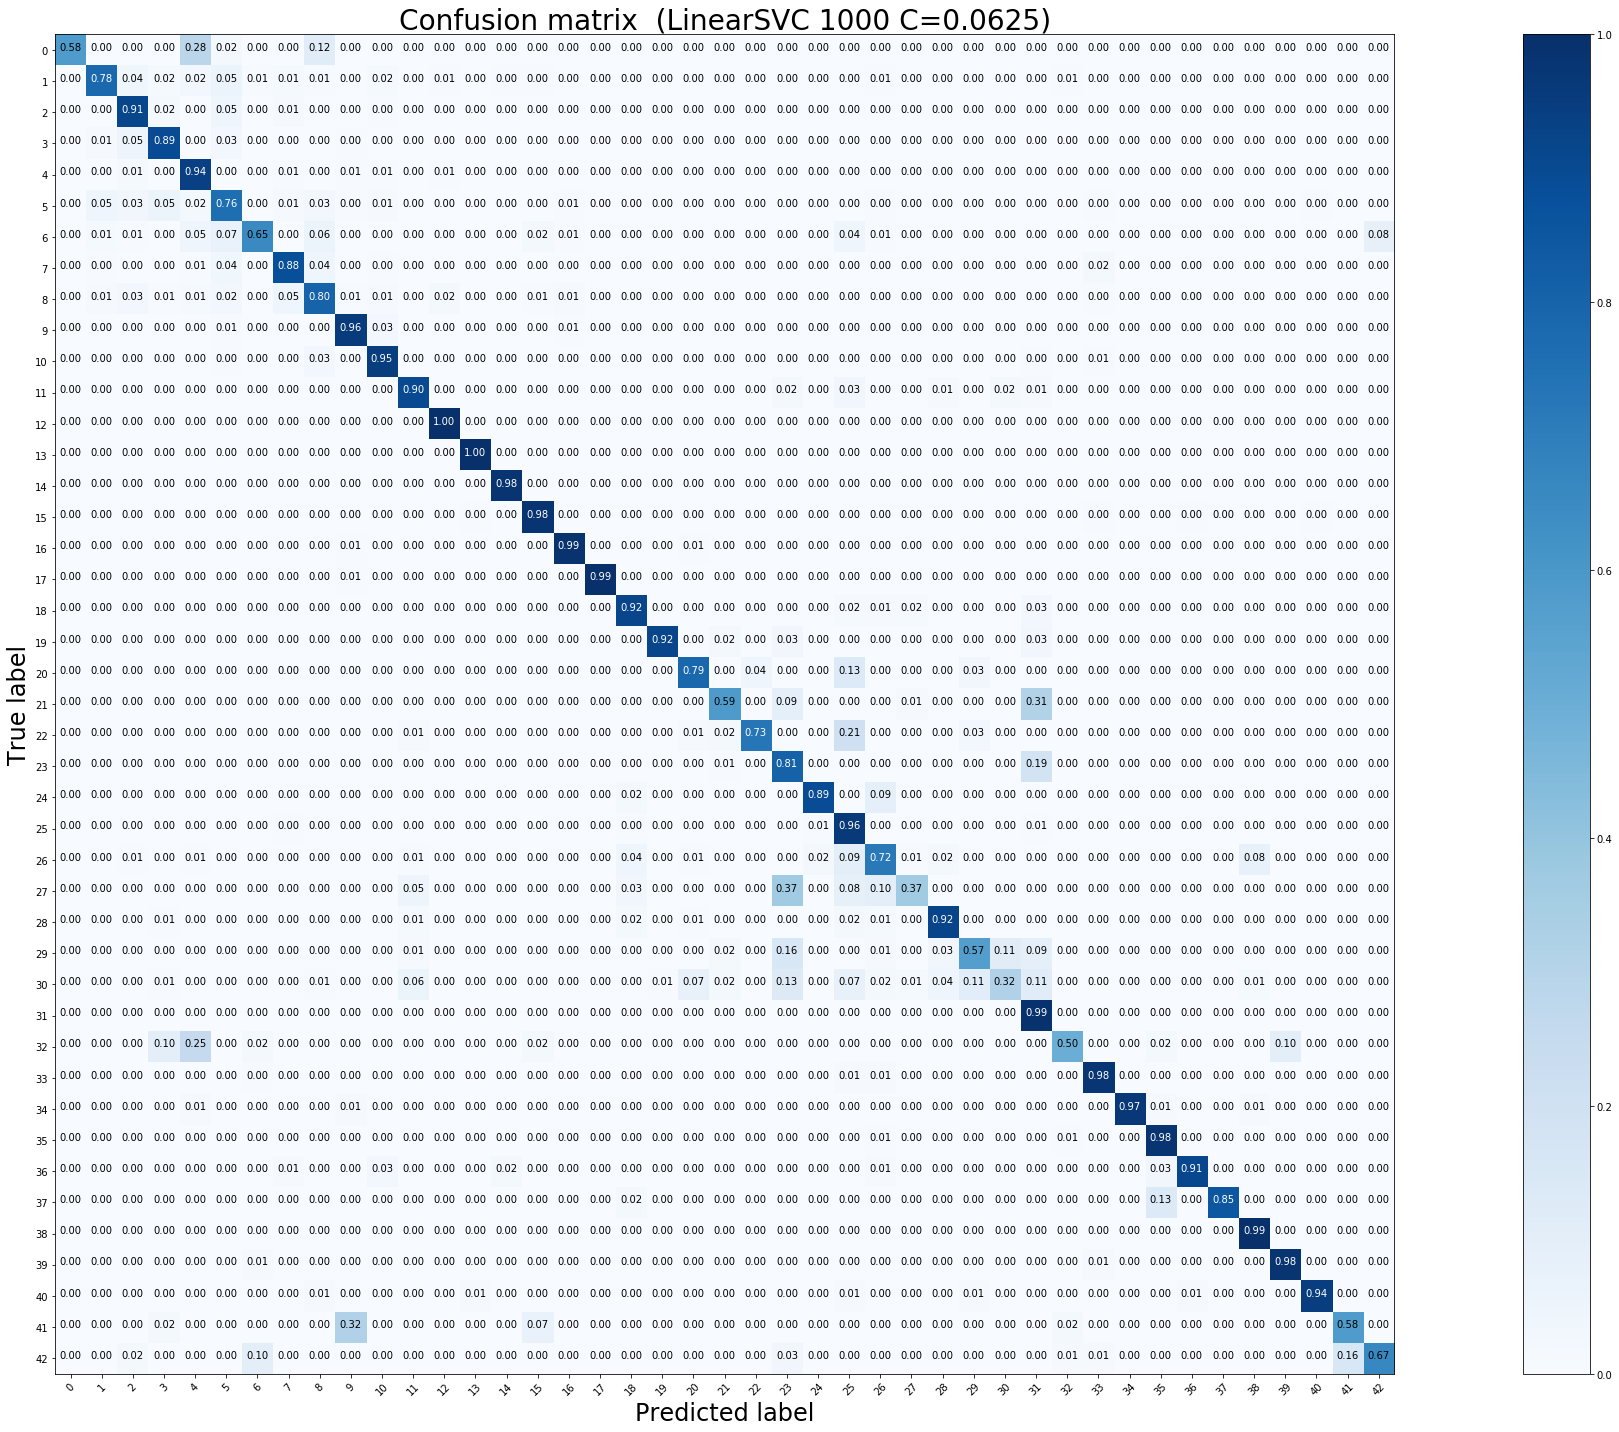

Test accuracy:  0.8929532858273951 

              precision    recall  f1-score   support

           0       0.95      0.58      0.72        60
           1       0.92      0.78      0.85       720
           2       0.87      0.91      0.89       750
           3       0.84      0.89      0.87       450
           4       0.89      0.94      0.91       660
           5       0.79      0.76      0.77       630
           6       0.84      0.65      0.73       150
           7       0.88      0.88      0.88       450
           8       0.81      0.80      0.81       450
           9       0.92      0.96      0.94       480
          10       0.93      0.95      0.94       660
          11       0.95      0.90      0.92       420
          12       0.97      1.00      0.98       690
          13       0.99      1.00      1.00       720
          14       0.97      0.98      0.97       270
          15       0.93      0.98      0.95       210
          16       0.91      0.99      0.95 

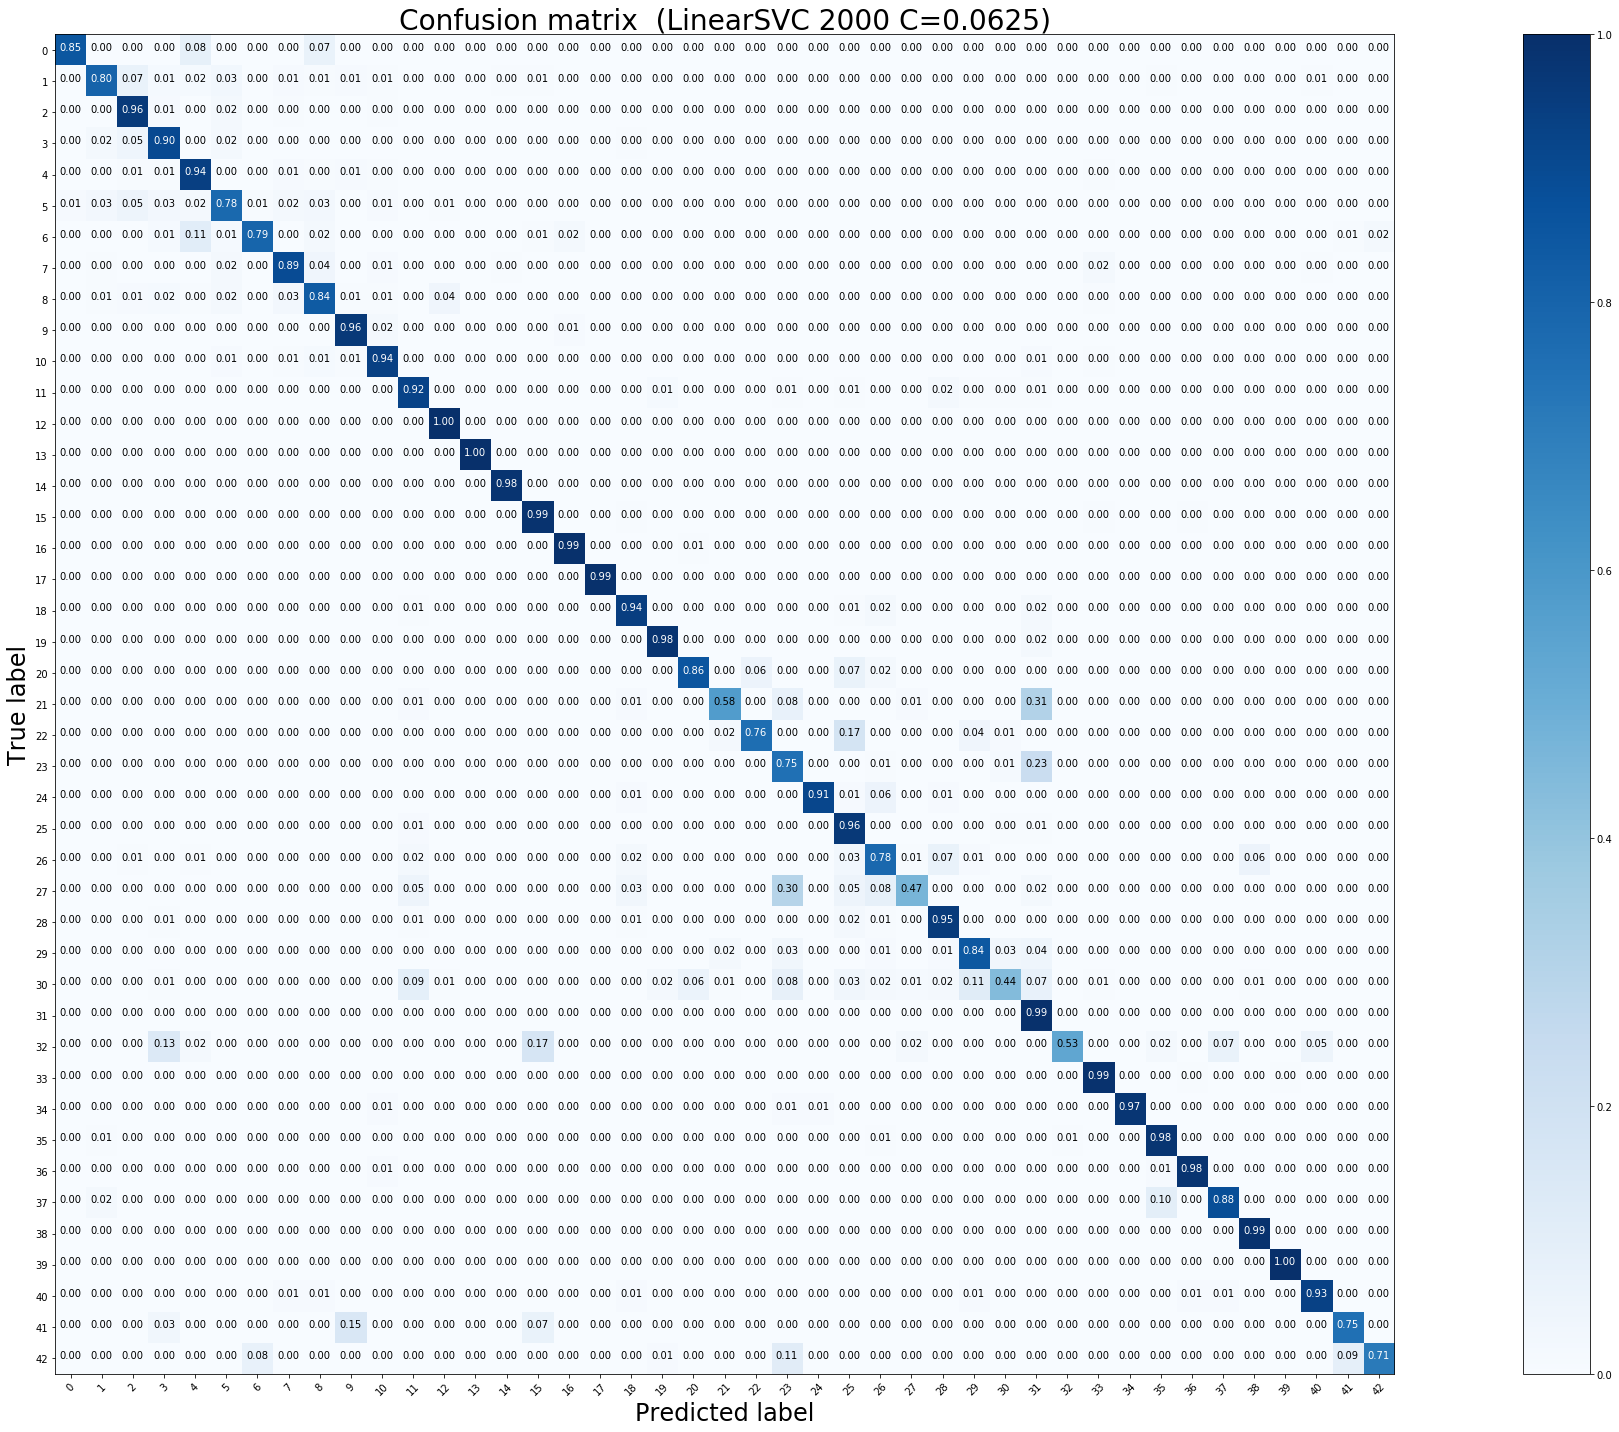

Test accuracy:  0.91187648456057 

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        60
           1       0.94      0.80      0.87       720
           2       0.86      0.96      0.91       750
           3       0.87      0.90      0.89       450
           4       0.93      0.94      0.93       660
           5       0.87      0.78      0.82       630
           6       0.91      0.79      0.85       150
           7       0.89      0.89      0.89       450
           8       0.86      0.84      0.85       450
           9       0.93      0.96      0.95       480
          10       0.94      0.94      0.94       660
          11       0.92      0.92      0.92       420
          12       0.95      1.00      0.98       690
          13       1.00      1.00      1.00       720
          14       0.97      0.98      0.97       270
          15       0.90      0.99      0.94       210
          16       0.91      0.99      0.95   

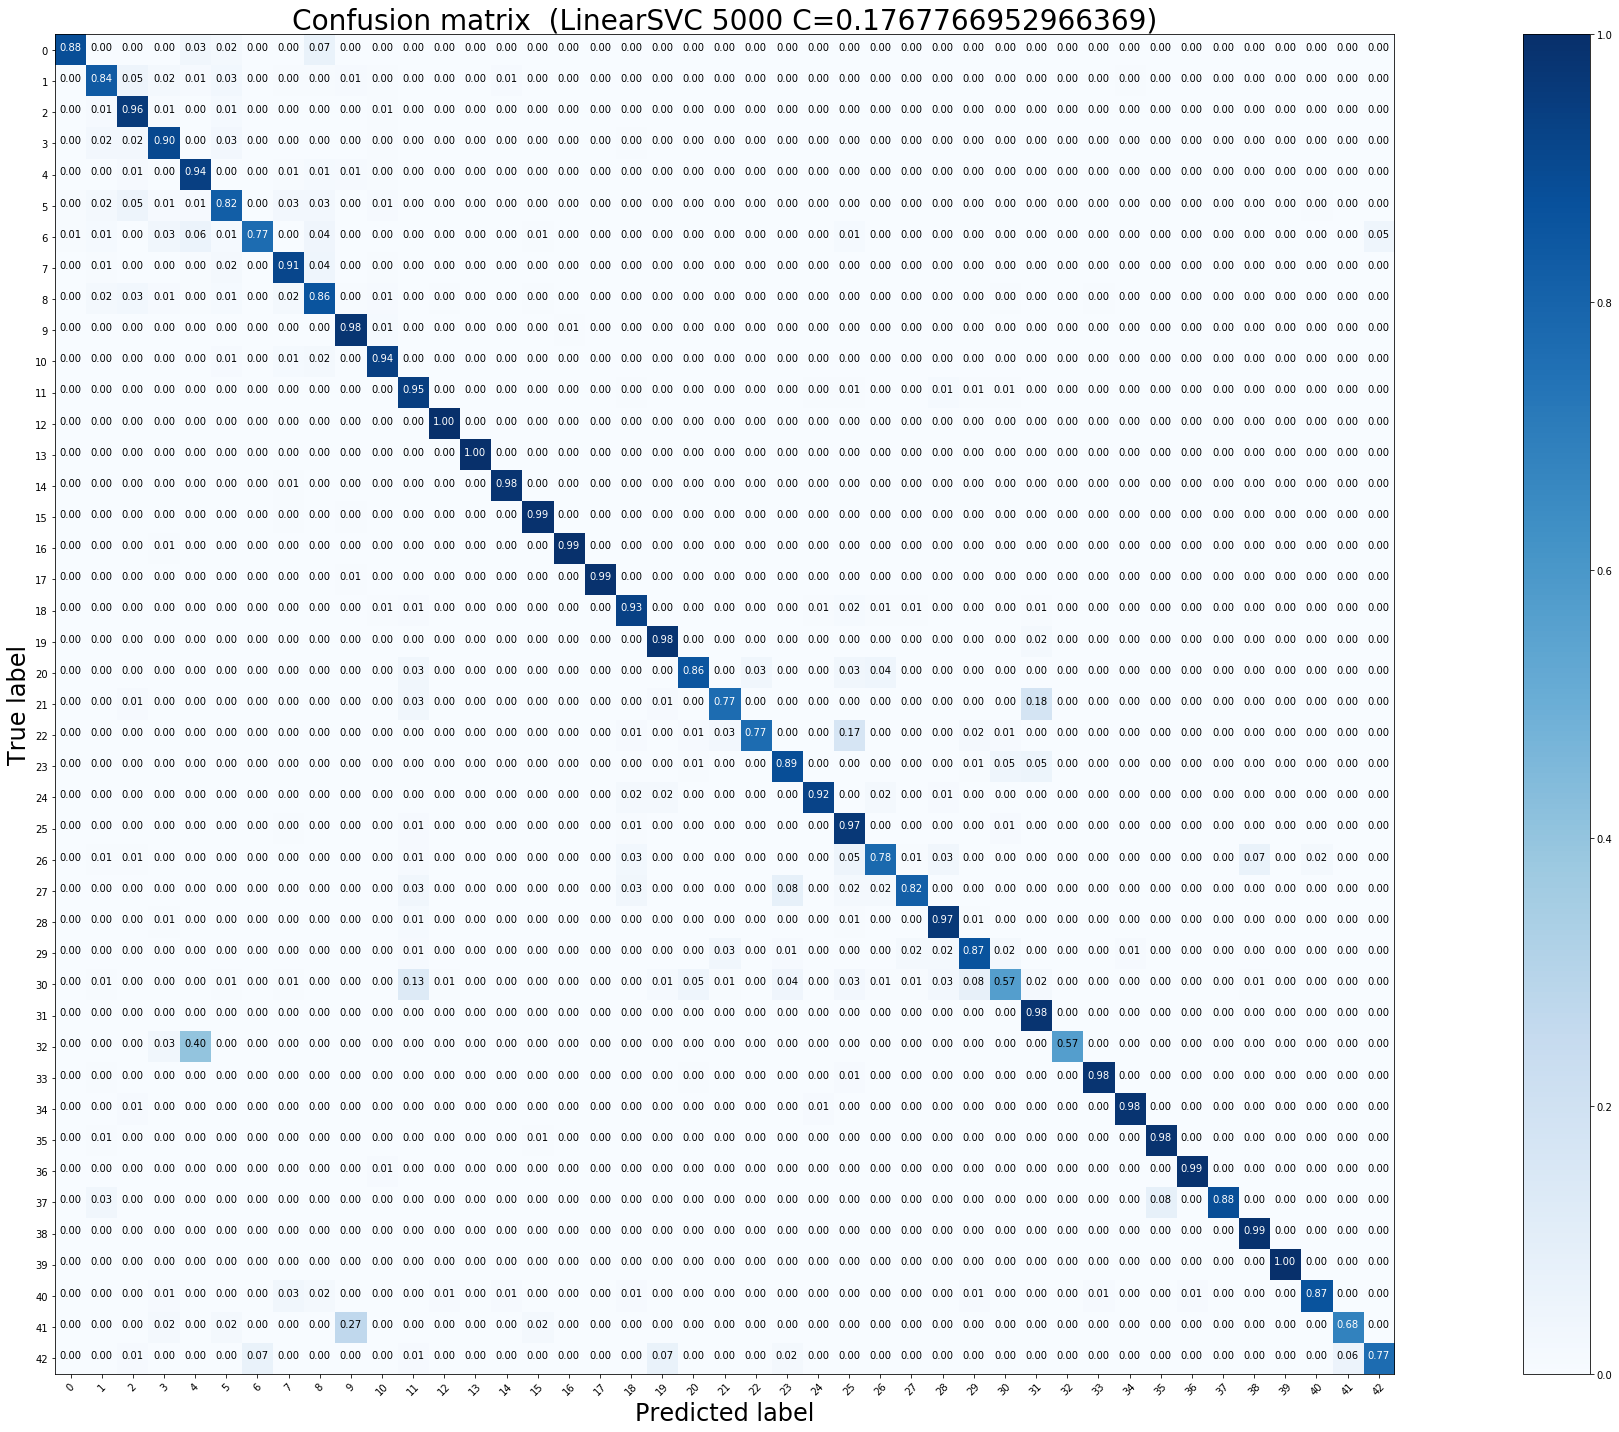

Test accuracy:  0.9252573238321457 

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        60
           1       0.91      0.84      0.87       720
           2       0.87      0.96      0.91       750
           3       0.90      0.90      0.90       450
           4       0.92      0.94      0.93       660
           5       0.88      0.82      0.85       630
           6       0.93      0.77      0.84       150
           7       0.89      0.91      0.90       450
           8       0.84      0.86      0.85       450
           9       0.92      0.98      0.95       480
          10       0.95      0.94      0.94       660
          11       0.89      0.95      0.92       420
          12       0.99      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.97      0.98      0.97       270
          15       0.97      0.99      0.98       210
          16       0.96      0.99      0.97 

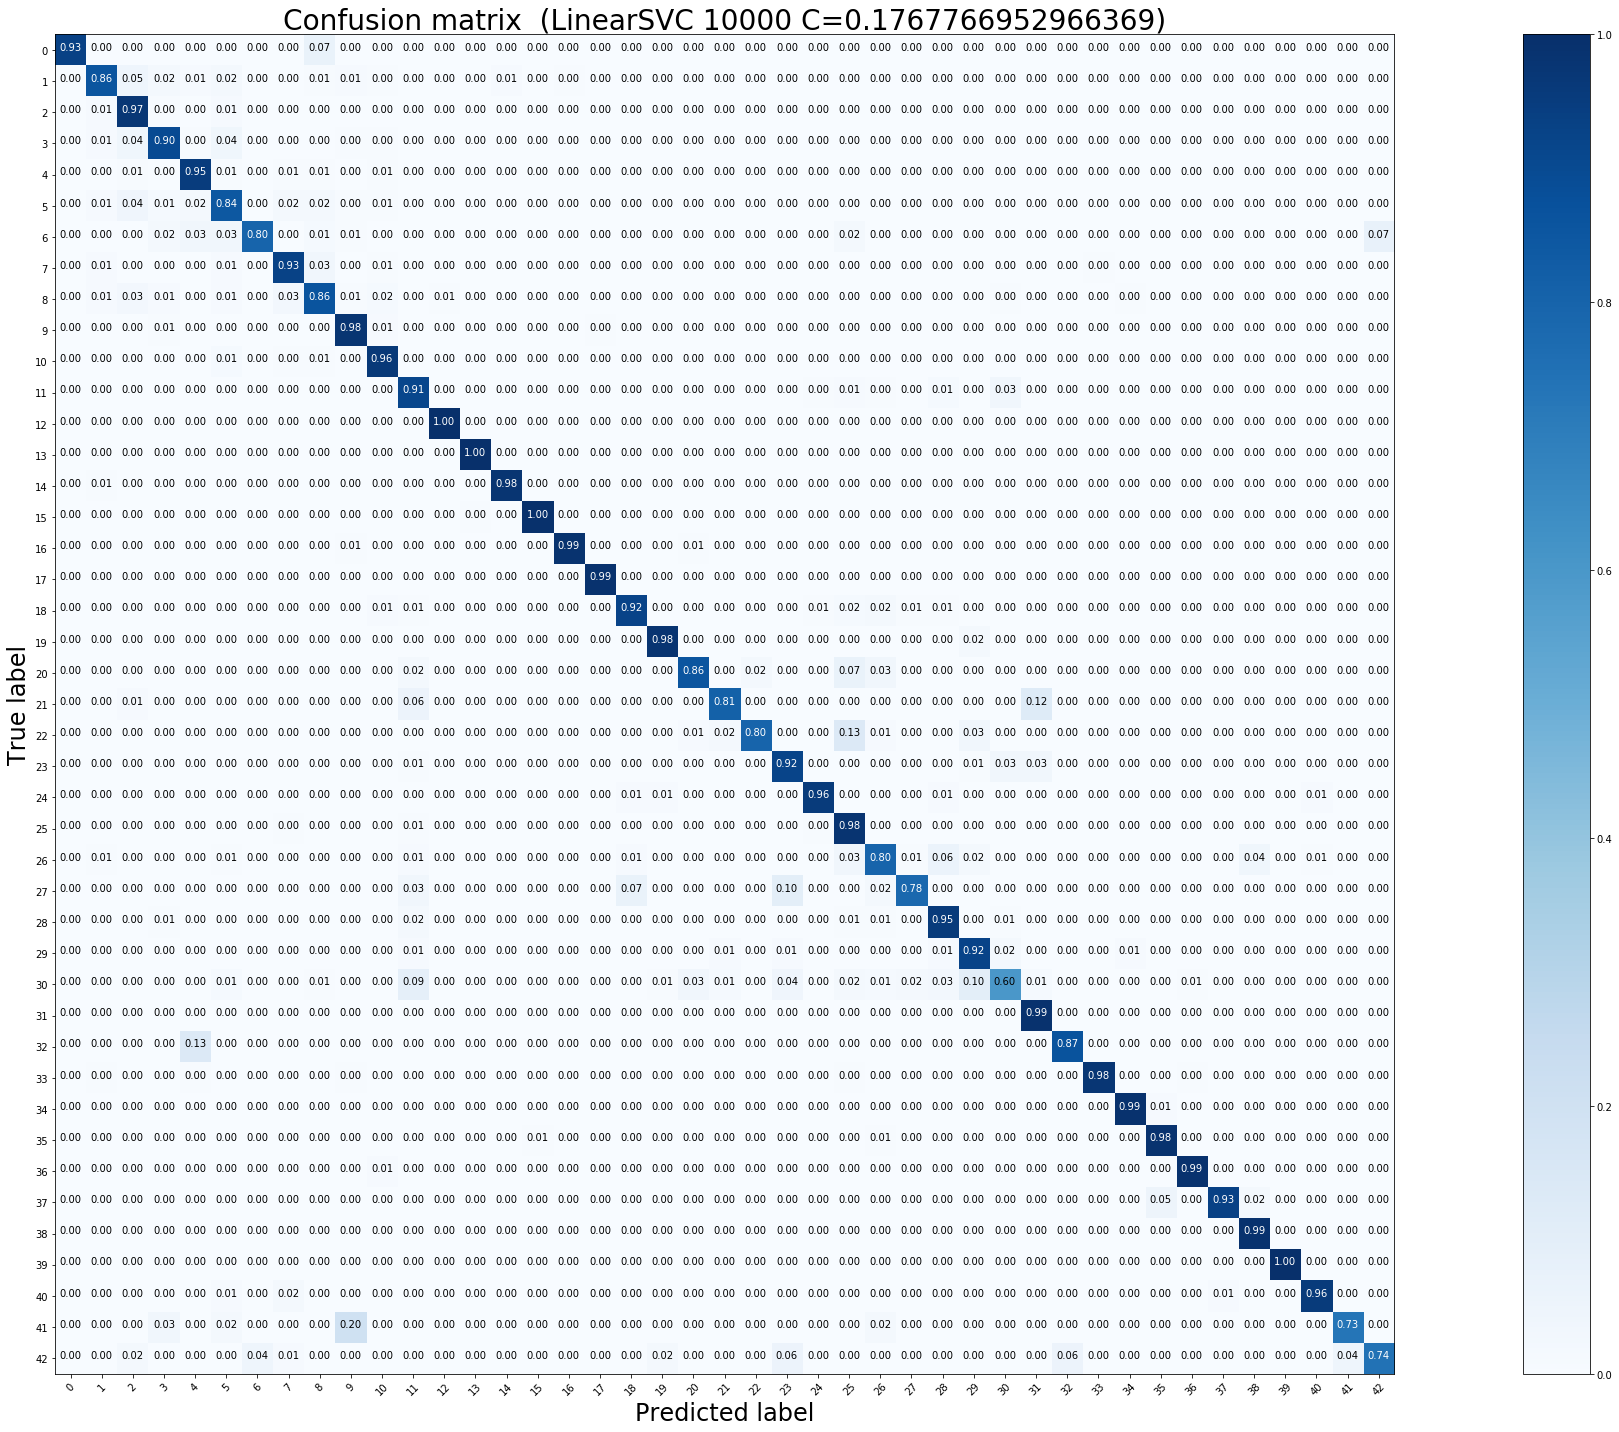

Test accuracy:  0.9343626286619161 

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        60
           1       0.94      0.86      0.90       720
           2       0.88      0.97      0.92       750
           3       0.91      0.90      0.90       450
           4       0.94      0.95      0.95       660
           5       0.88      0.84      0.86       630
           6       0.95      0.80      0.87       150
           7       0.91      0.93      0.92       450
           8       0.88      0.86      0.87       450
           9       0.93      0.98      0.95       480
          10       0.95      0.96      0.96       660
          11       0.91      0.91      0.91       420
          12       0.99      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.96      0.98      0.97       270
          15       0.97      1.00      0.98       210
          16       0.97      0.99      0.98 

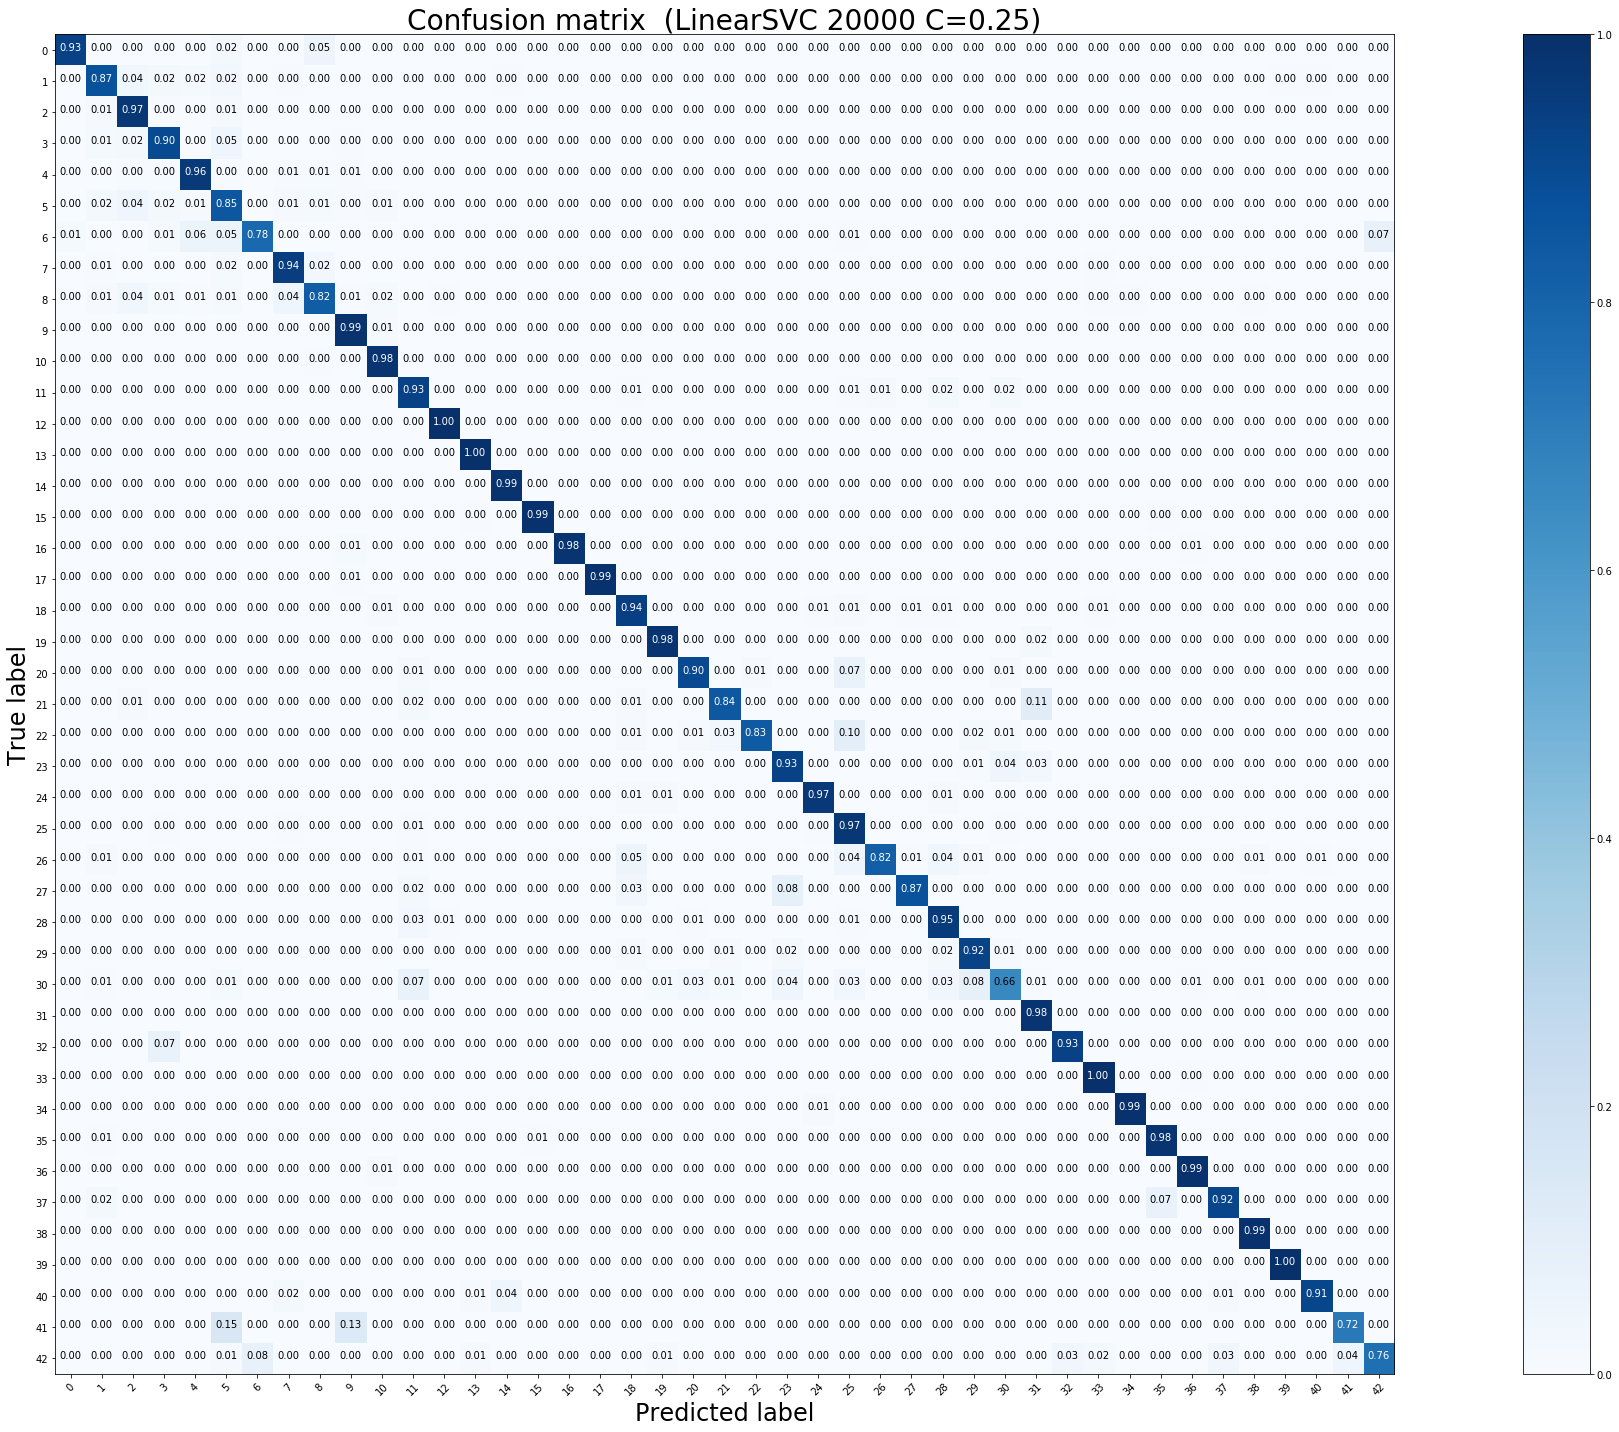

Test accuracy:  0.9391132224861442 

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        60
           1       0.93      0.87      0.90       720
           2       0.89      0.97      0.93       750
           3       0.89      0.90      0.90       450
           4       0.95      0.96      0.95       660
           5       0.86      0.85      0.86       630
           6       0.94      0.78      0.85       150
           7       0.91      0.94      0.93       450
           8       0.92      0.82      0.87       450
           9       0.94      0.99      0.97       480
          10       0.96      0.98      0.97       660
          11       0.94      0.93      0.94       420
          12       0.99      1.00      0.99       690
          13       0.99      1.00      1.00       720
          14       0.96      0.99      0.97       270
          15       0.97      0.99      0.98       210
          16       0.99      0.98      0.99 

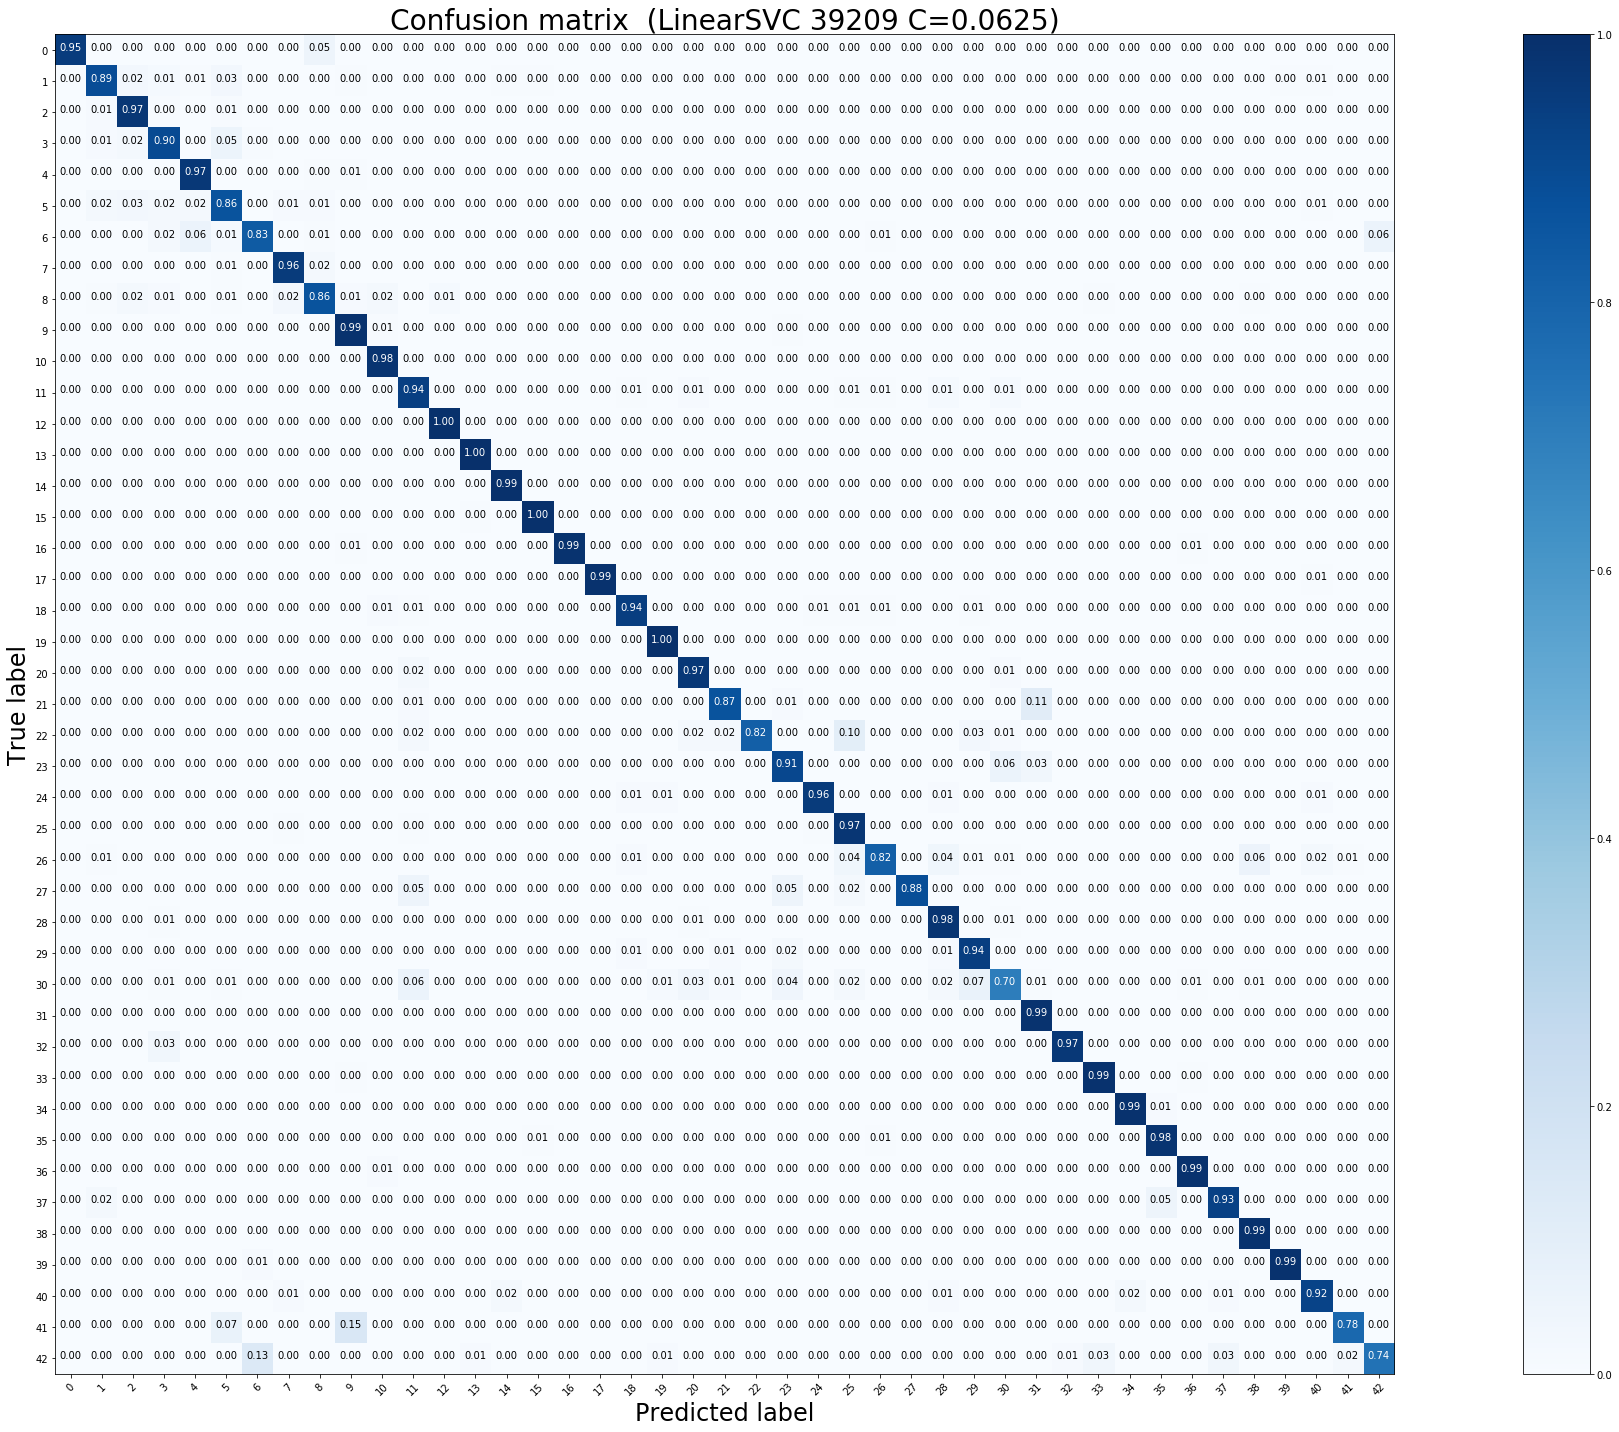

Test accuracy:  0.946714172604909 

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        60
           1       0.96      0.89      0.92       720
           2       0.93      0.97      0.95       750
           3       0.91      0.90      0.91       450
           4       0.96      0.97      0.96       660
           5       0.89      0.86      0.88       630
           6       0.89      0.83      0.86       150
           7       0.94      0.96      0.95       450
           8       0.94      0.86      0.90       450
           9       0.94      0.99      0.97       480
          10       0.96      0.98      0.97       660
          11       0.94      0.94      0.94       420
          12       0.98      1.00      0.99       690
          13       0.99      1.00      0.99       720
          14       0.95      0.99      0.97       270
          15       0.97      1.00      0.98       210
          16       0.99      0.99      0.99  

In [11]:
##############################################################################
############### LinearSVC, hinge mit optimierten Parametern trainieren #######
##############################################################################
train_LinearSVC(X_tr_500, X_test_9_4_2, y_tr_500, y_test, 1, '500',0.21022410381342863, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "HOG_942_balanced.pkl")
train_LinearSVC(X_tr_1000, X_test_9_4_2, y_tr_1000, y_test, 1, '1000',0.0625, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "HOG_942_balanced.pkl")
train_LinearSVC(X_tr_2000, X_test_9_4_2, y_tr_2000, y_test, 1, '2000',0.0625, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "HOG_942_balanced.pkl")
train_LinearSVC(X_tr_5000, X_test_9_4_2, y_tr_5000, y_test, 1, '5000',0.1767766952966369 , 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "HOG_942_balanced.pkl")
train_LinearSVC(X_tr_10000, X_test_9_4_2, y_tr_10000, y_test, 1, '10000',0.1767766952966369 , 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "HOG_942_balanced.pkl")
train_LinearSVC(X_tr_20000, X_test_9_4_2, y_tr_20000, y_test, 1, '20000', 0.25 , 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "HOG_942_balanced.pkl")
train_LinearSVC(X_tr, X_test_9_4_2, y_tr, y_test, 1, '39209', 0.0625 , 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "HOG_942_balanced.pkl")

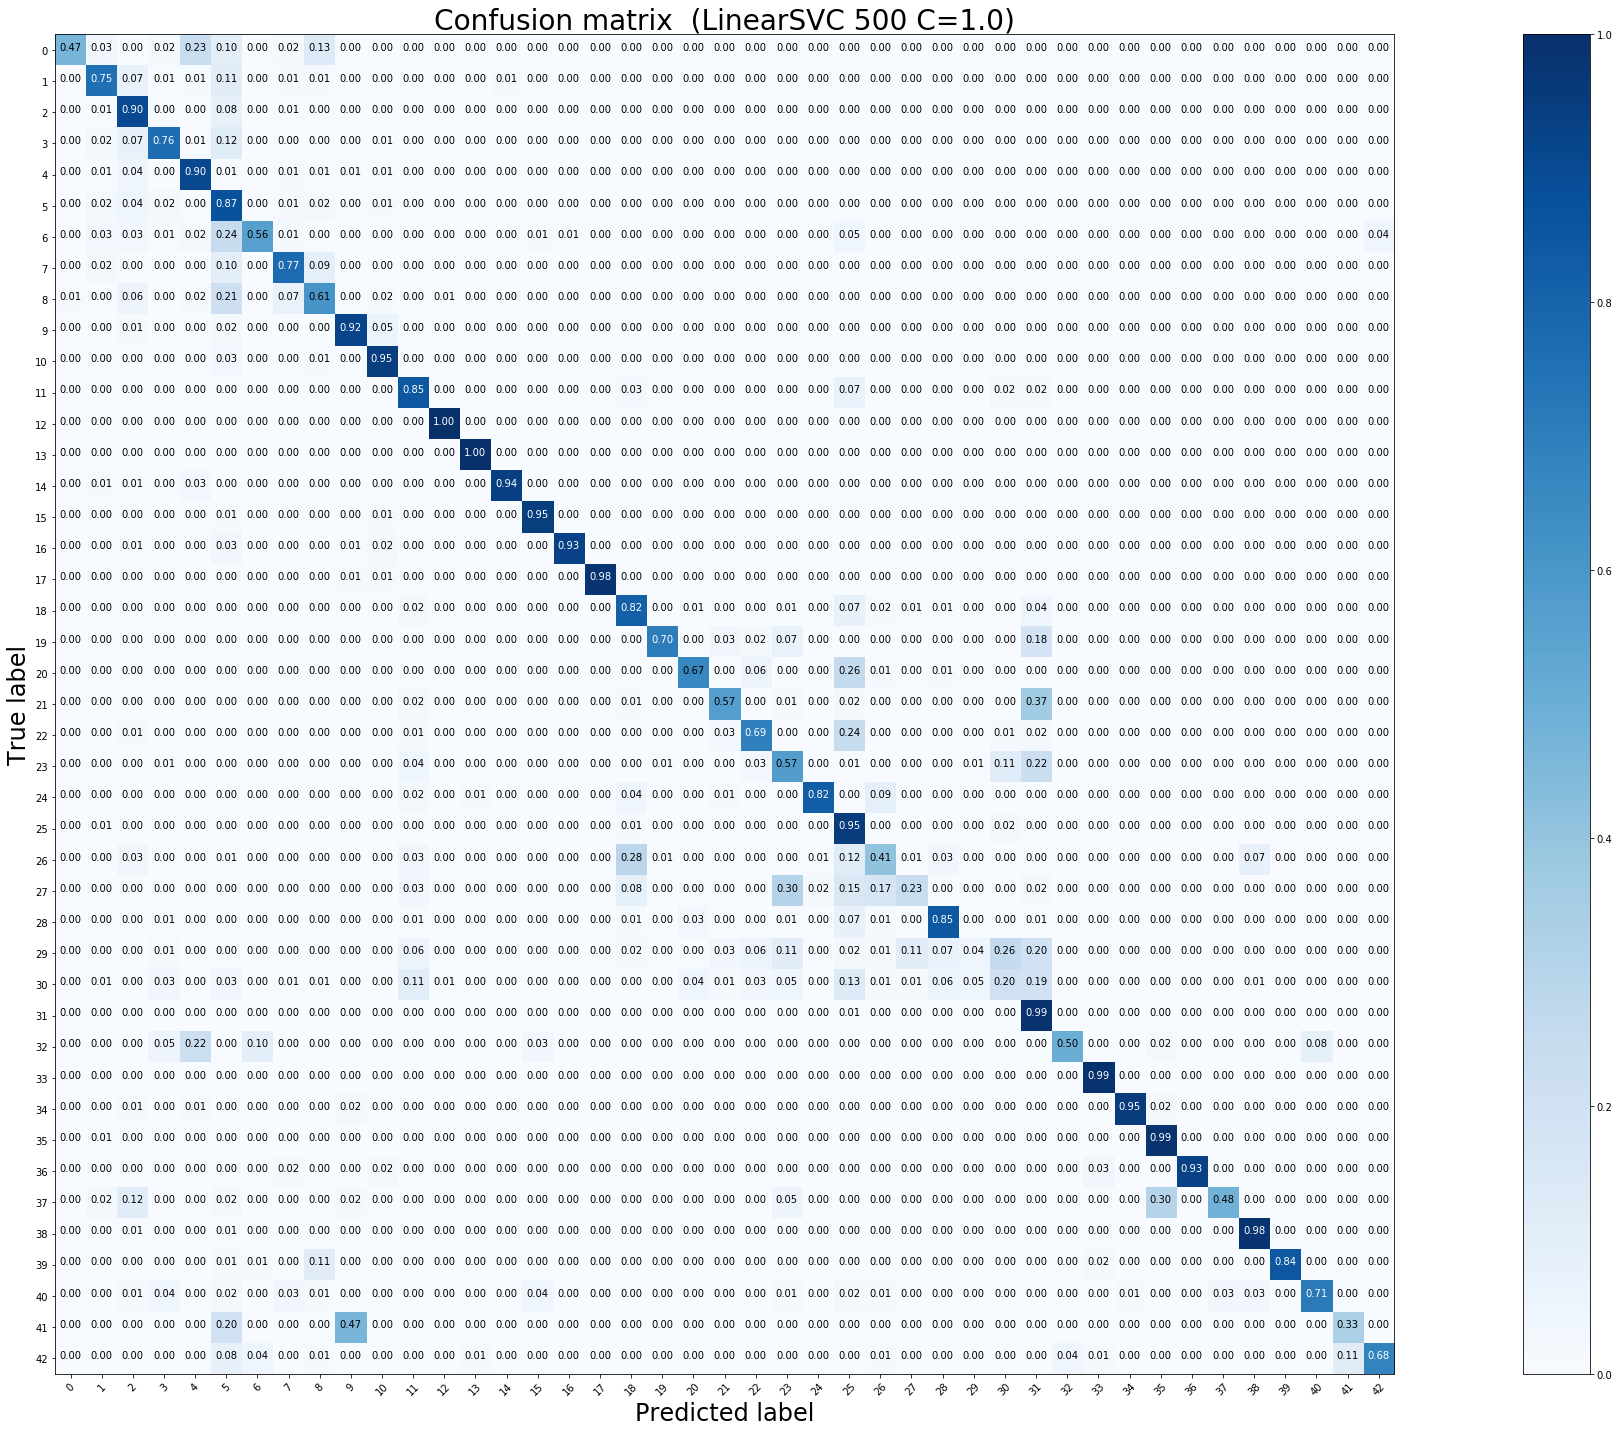

Test accuracy:  0.8458432304038005 

              precision    recall  f1-score   support

           0       0.85      0.47      0.60        60
           1       0.90      0.75      0.82       720
           2       0.78      0.90      0.83       750
           3       0.91      0.76      0.83       450
           4       0.91      0.90      0.90       660
           5       0.55      0.87      0.68       630
           6       0.88      0.56      0.69       150
           7       0.83      0.77      0.80       450
           8       0.74      0.61      0.67       450
           9       0.91      0.92      0.91       480
          10       0.91      0.95      0.93       660
          11       0.88      0.85      0.86       420
          12       0.99      1.00      0.99       690
          13       0.99      1.00      1.00       720
          14       0.98      0.94      0.96       270
          15       0.95      0.95      0.95       210
          16       0.99      0.93      0.96 

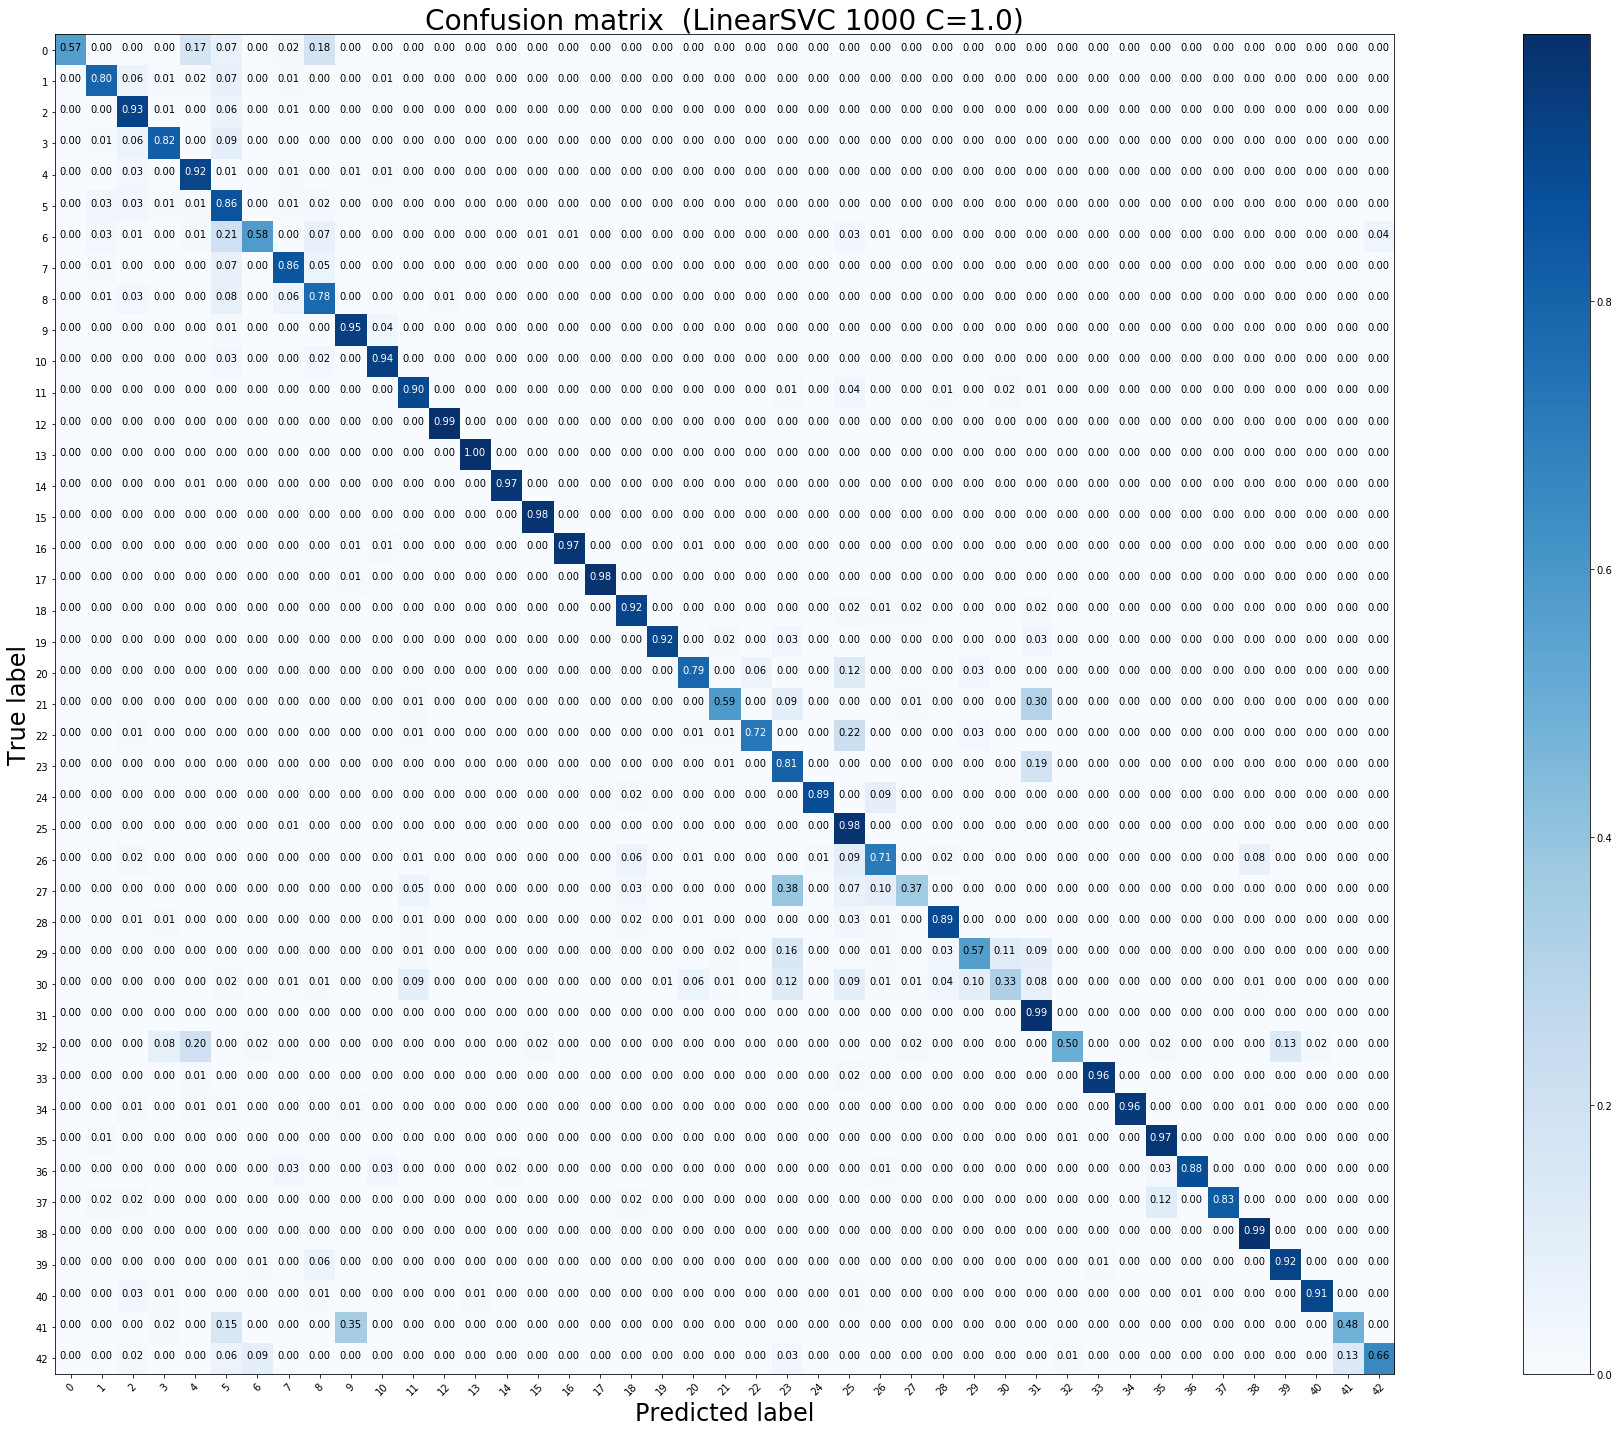

Test accuracy:  0.8890736342042755 

              precision    recall  f1-score   support

           0       0.97      0.57      0.72        60
           1       0.92      0.80      0.85       720
           2       0.83      0.93      0.87       750
           3       0.91      0.82      0.86       450
           4       0.92      0.92      0.92       660
           5       0.65      0.86      0.74       630
           6       0.87      0.58      0.70       150
           7       0.85      0.86      0.85       450
           8       0.79      0.78      0.79       450
           9       0.93      0.95      0.94       480
          10       0.93      0.94      0.94       660
          11       0.94      0.90      0.92       420
          12       0.98      0.99      0.99       690
          13       0.99      1.00      1.00       720
          14       0.98      0.97      0.98       270
          15       0.98      0.98      0.98       210
          16       0.97      0.97      0.97 

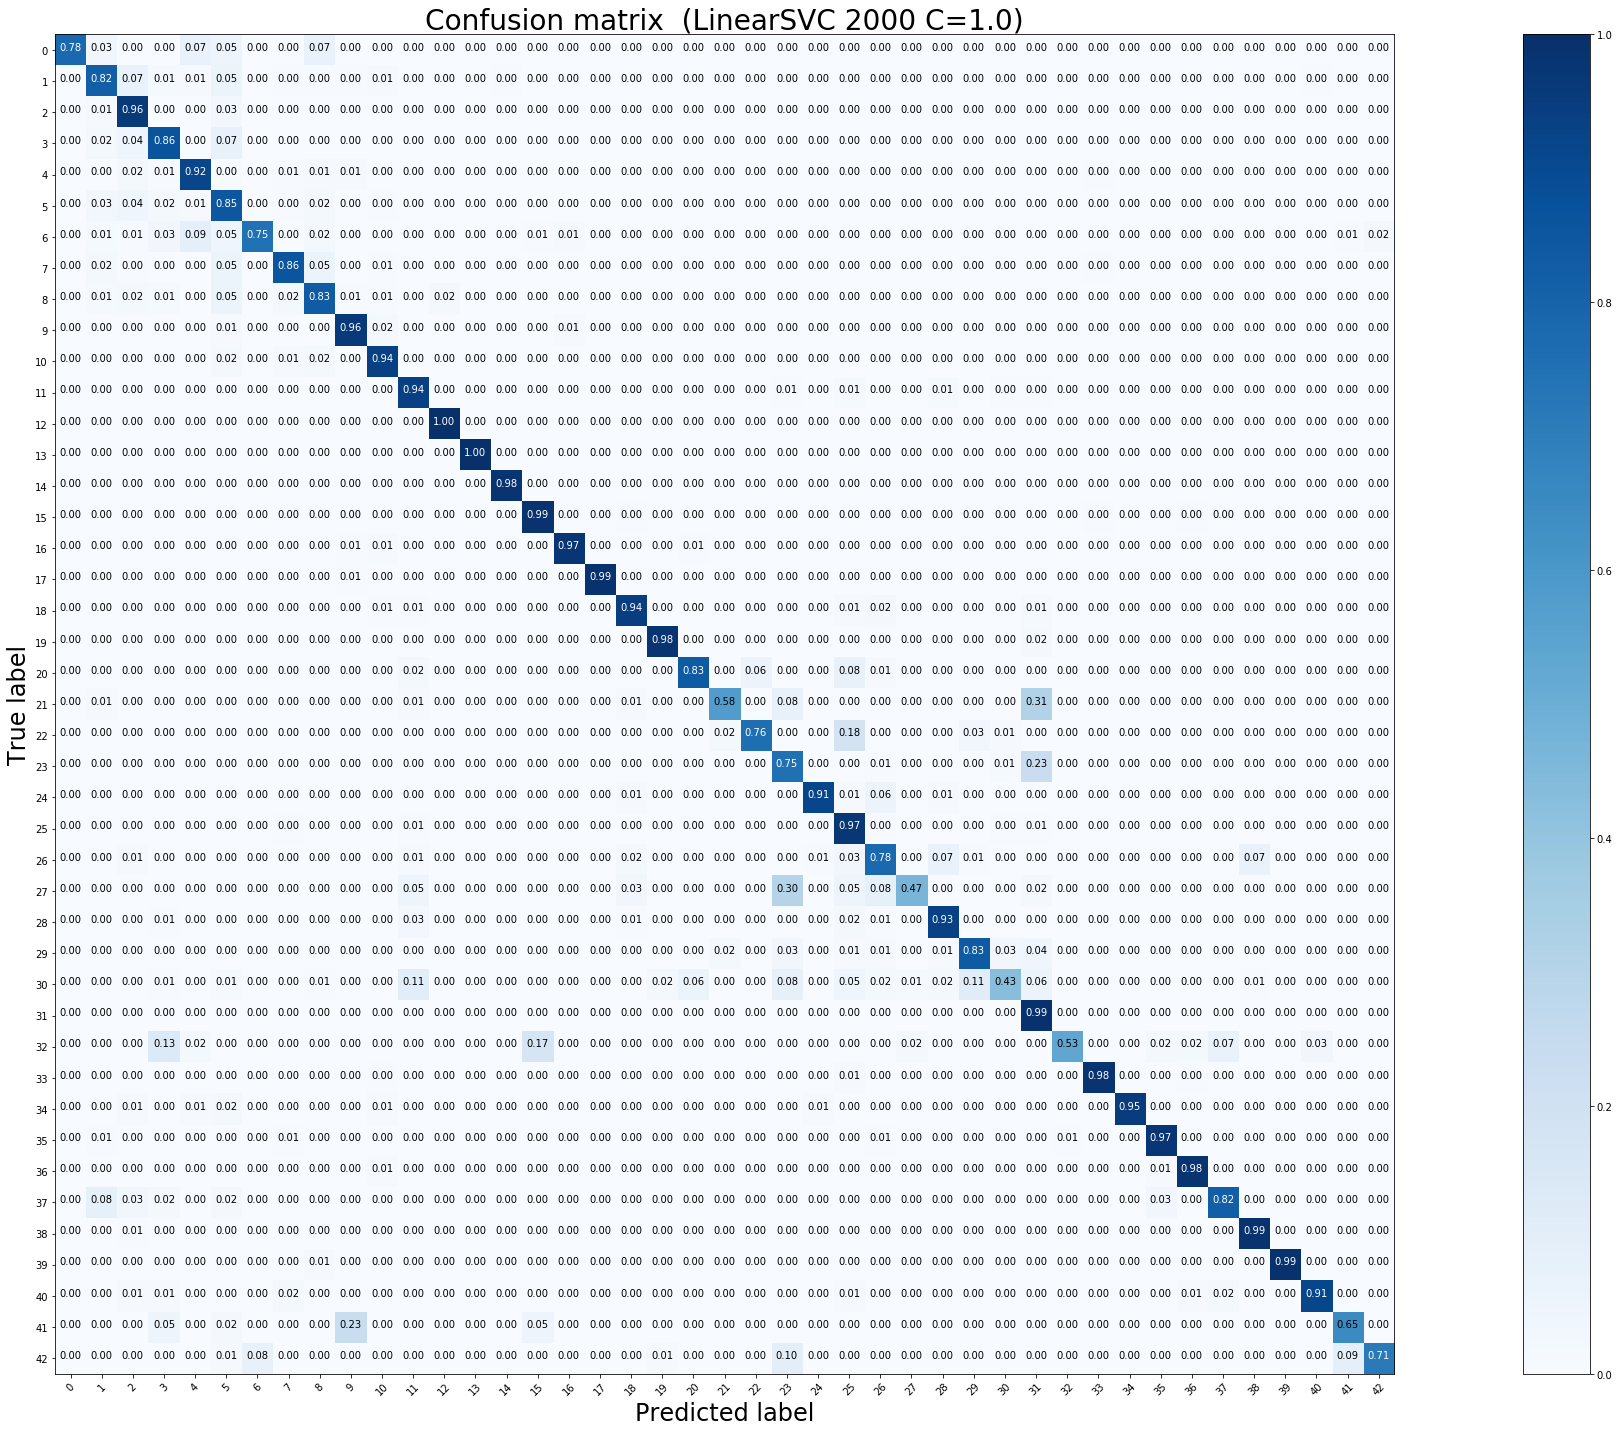

Test accuracy:  0.9091053048297704 

              precision    recall  f1-score   support

           0       0.92      0.78      0.85        60
           1       0.90      0.82      0.86       720
           2       0.84      0.96      0.90       750
           3       0.88      0.86      0.87       450
           4       0.95      0.92      0.93       660
           5       0.75      0.85      0.80       630
           6       0.93      0.75      0.83       150
           7       0.92      0.86      0.89       450
           8       0.85      0.83      0.84       450
           9       0.93      0.96      0.94       480
          10       0.94      0.94      0.94       660
          11       0.92      0.94      0.93       420
          12       0.98      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.98      0.98      0.98       270
          15       0.92      0.99      0.95       210
          16       0.94      0.97      0.95 

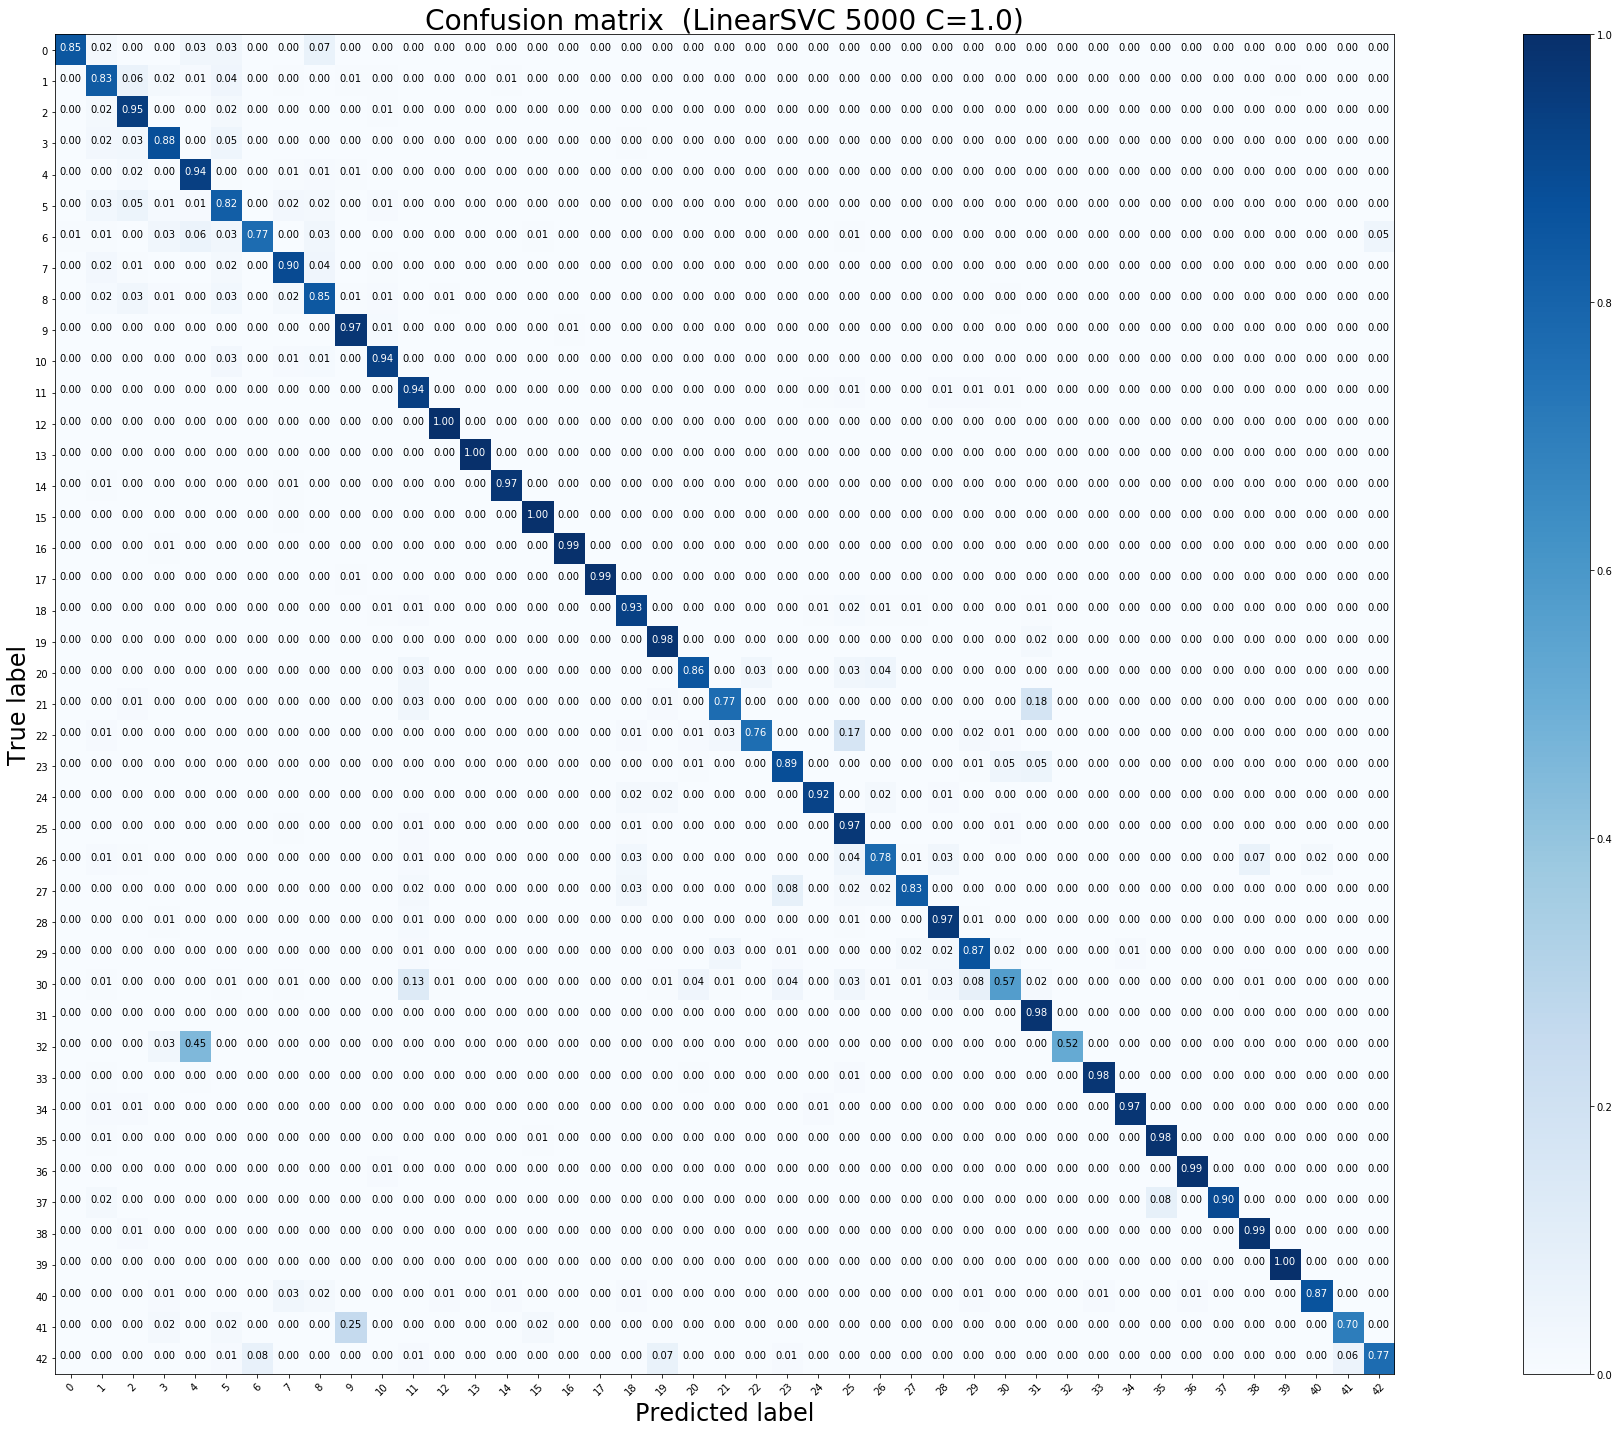

Test accuracy:  0.9211401425178147 

              precision    recall  f1-score   support

           0       0.91      0.85      0.88        60
           1       0.89      0.83      0.86       720
           2       0.84      0.95      0.89       750
           3       0.91      0.88      0.89       450
           4       0.92      0.94      0.93       660
           5       0.81      0.82      0.82       630
           6       0.93      0.77      0.84       150
           7       0.89      0.90      0.89       450
           8       0.86      0.85      0.86       450
           9       0.93      0.97      0.95       480
          10       0.95      0.94      0.94       660
          11       0.89      0.94      0.92       420
          12       0.99      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.97      0.97      0.97       270
          15       0.97      1.00      0.98       210
          16       0.96      0.99      0.98 

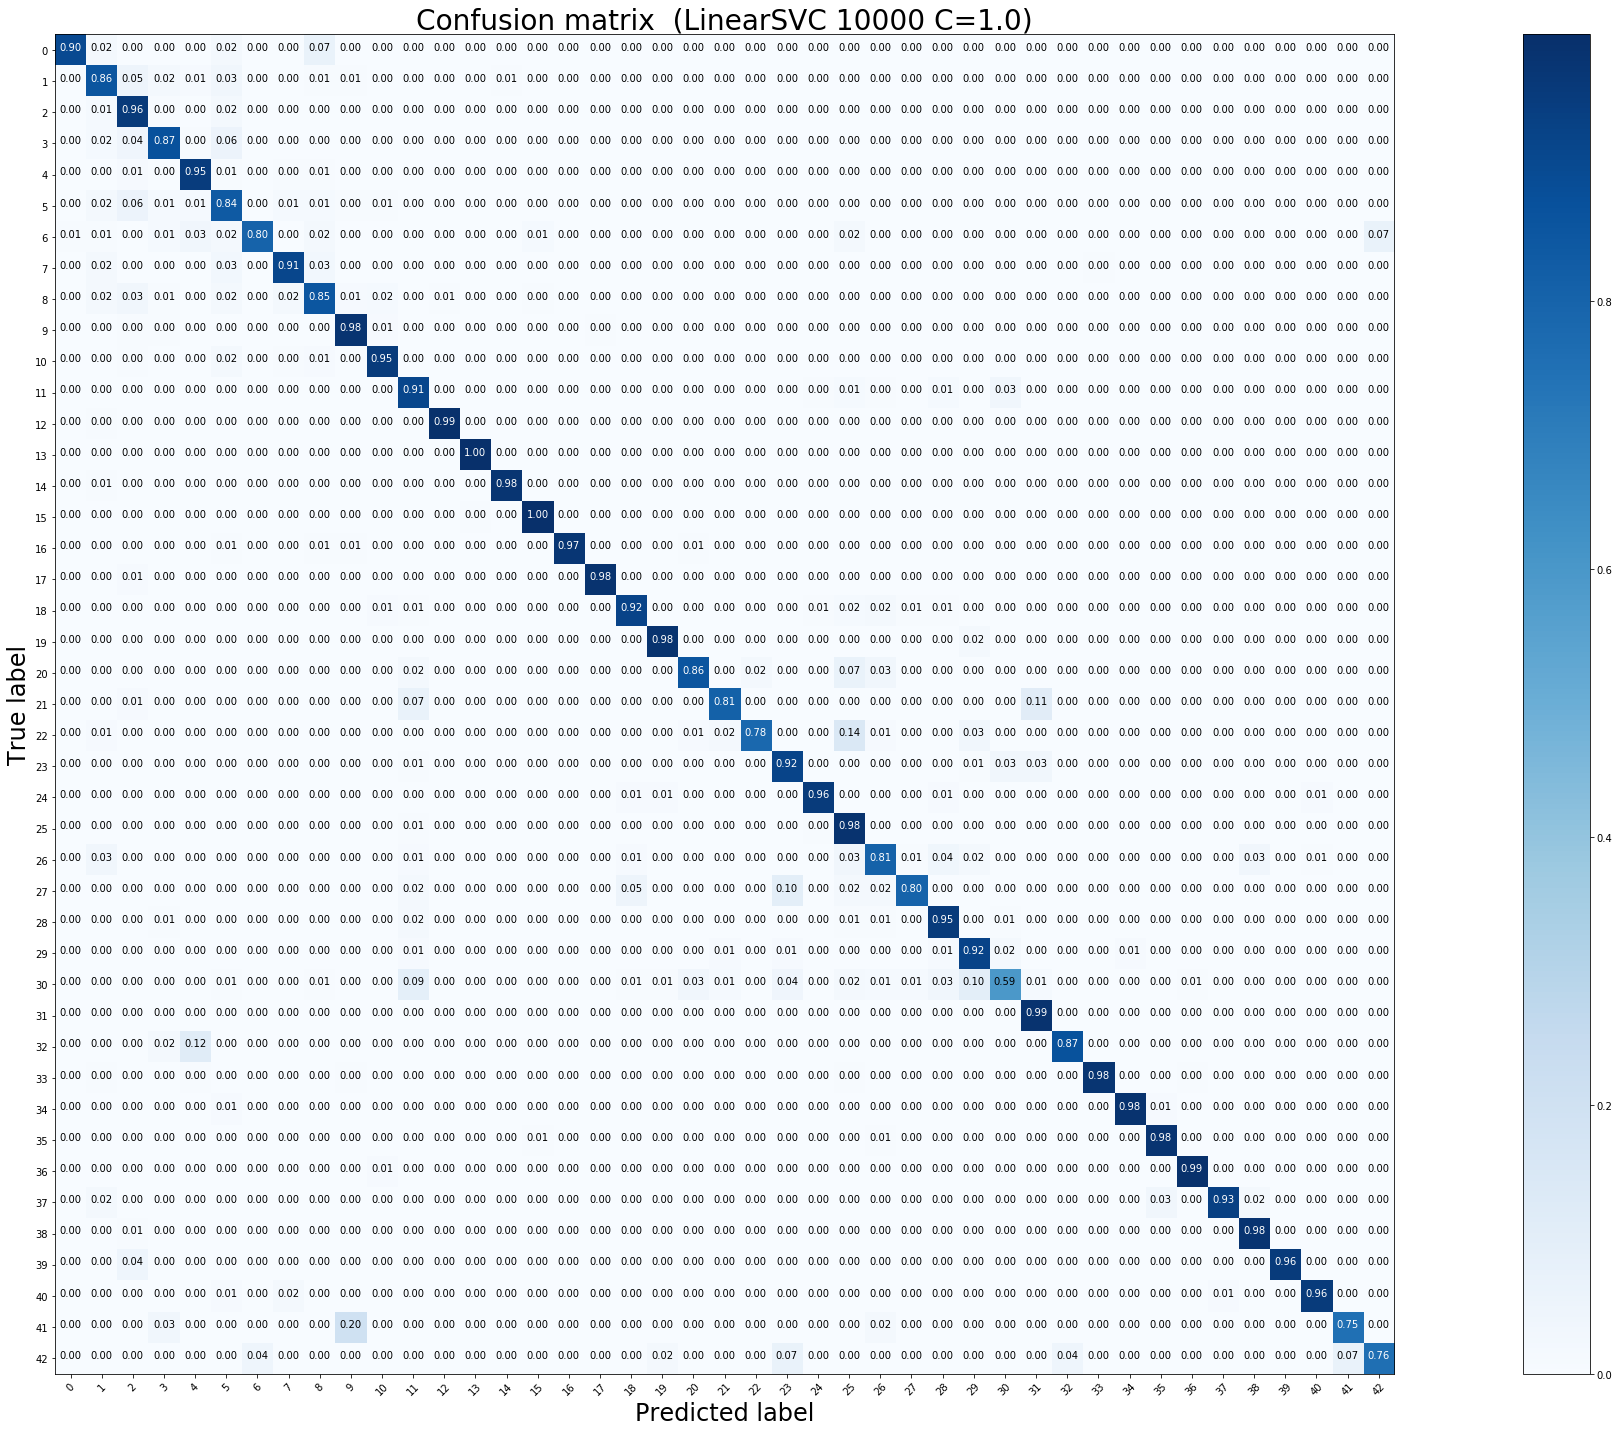

Test accuracy:  0.9294536817102138 

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        60
           1       0.90      0.86      0.88       720
           2       0.84      0.96      0.90       750
           3       0.90      0.87      0.89       450
           4       0.95      0.95      0.95       660
           5       0.82      0.84      0.83       630
           6       0.97      0.80      0.88       150
           7       0.93      0.91      0.92       450
           8       0.89      0.85      0.87       450
           9       0.93      0.98      0.96       480
          10       0.96      0.95      0.96       660
          11       0.91      0.91      0.91       420
          12       0.99      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       0.98      0.98      0.98       270
          15       0.96      1.00      0.98       210
          16       0.99      0.97      0.98 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


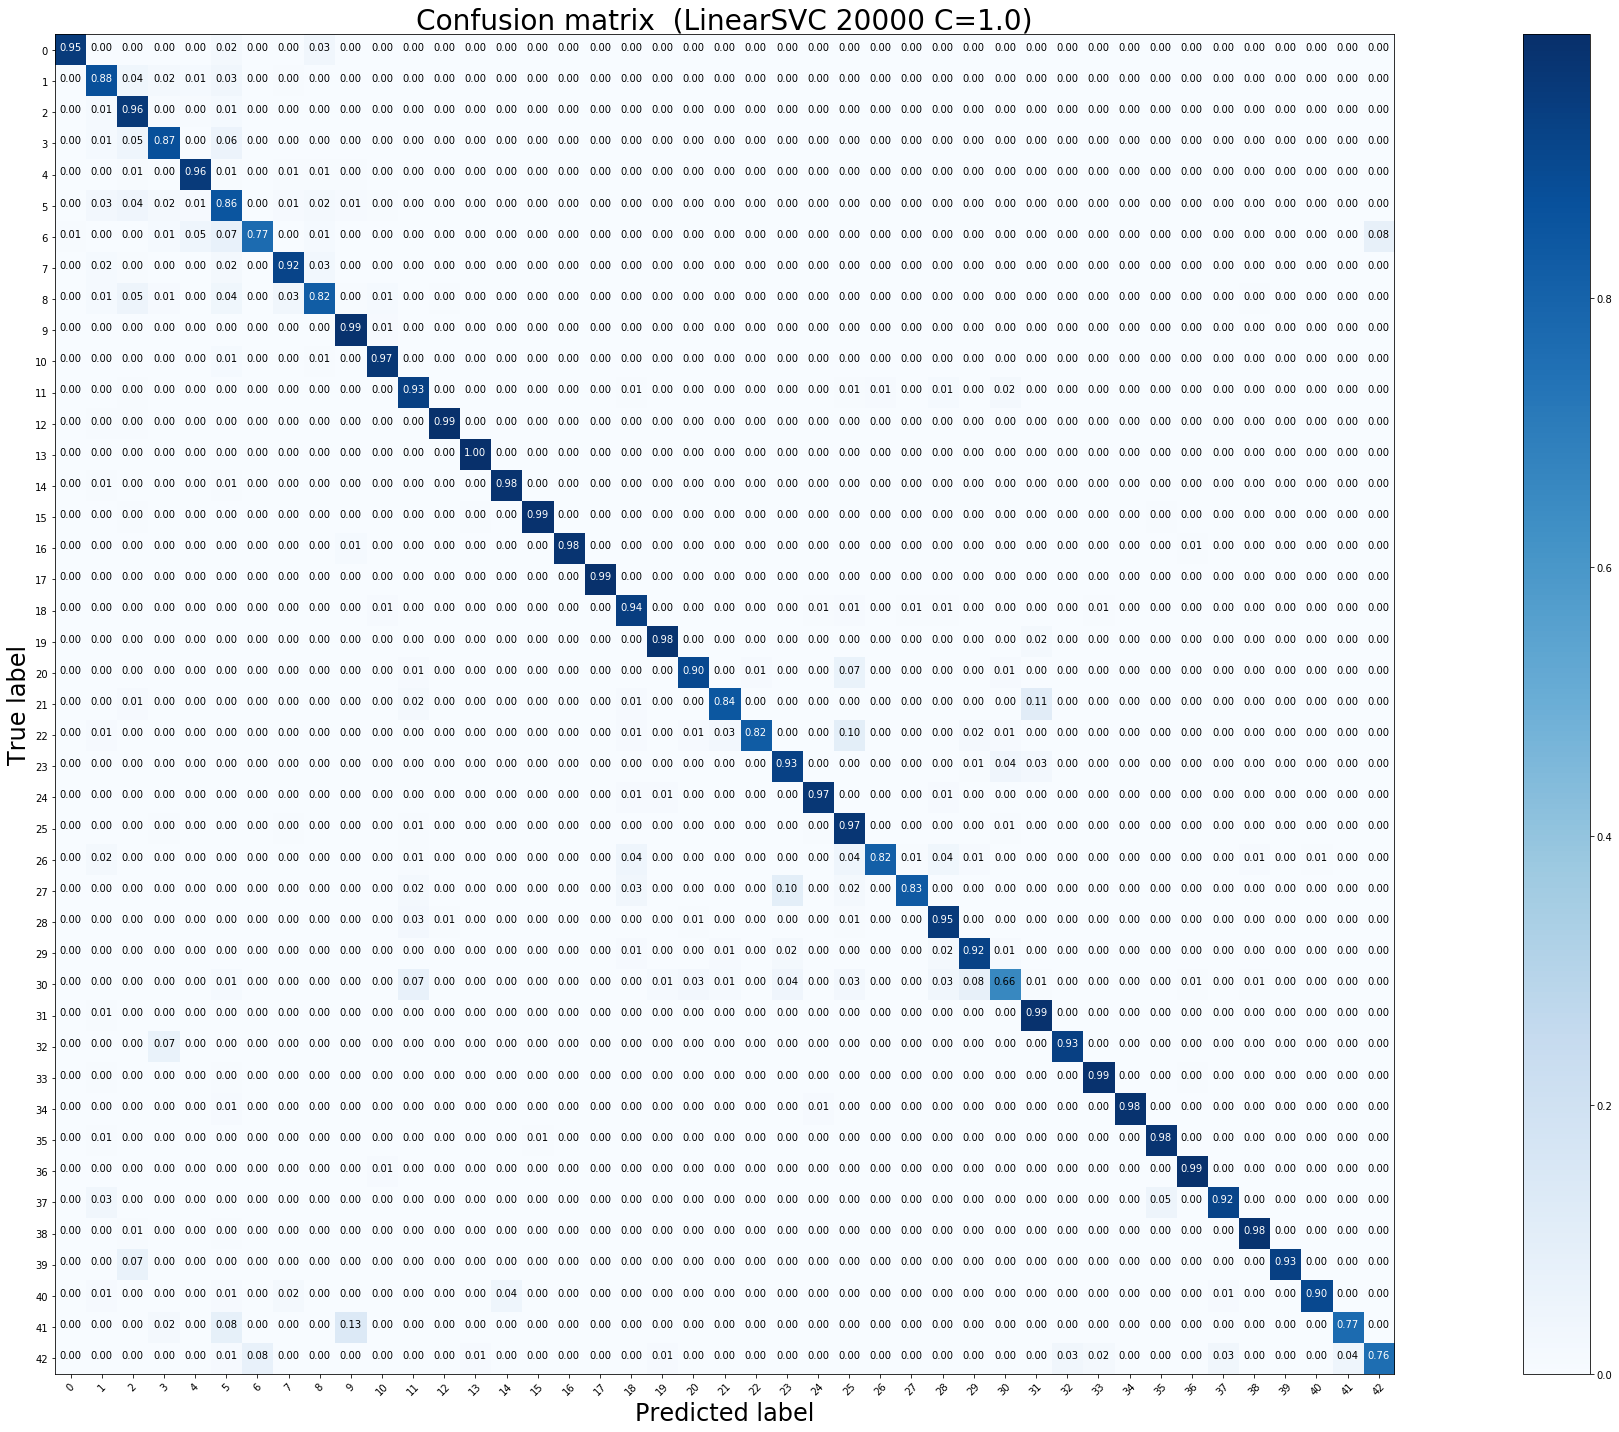

Test accuracy:  0.9345209817893904 

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        60
           1       0.90      0.88      0.89       720
           2       0.85      0.96      0.90       750
           3       0.89      0.87      0.88       450
           4       0.96      0.96      0.96       660
           5       0.81      0.86      0.83       630
           6       0.94      0.77      0.85       150
           7       0.92      0.92      0.92       450
           8       0.90      0.82      0.86       450
           9       0.95      0.99      0.97       480
          10       0.97      0.97      0.97       660
          11       0.94      0.93      0.93       420
          12       0.99      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       0.97      0.98      0.98       270
          15       0.97      0.99      0.98       210
          16       0.99      0.98      0.98 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


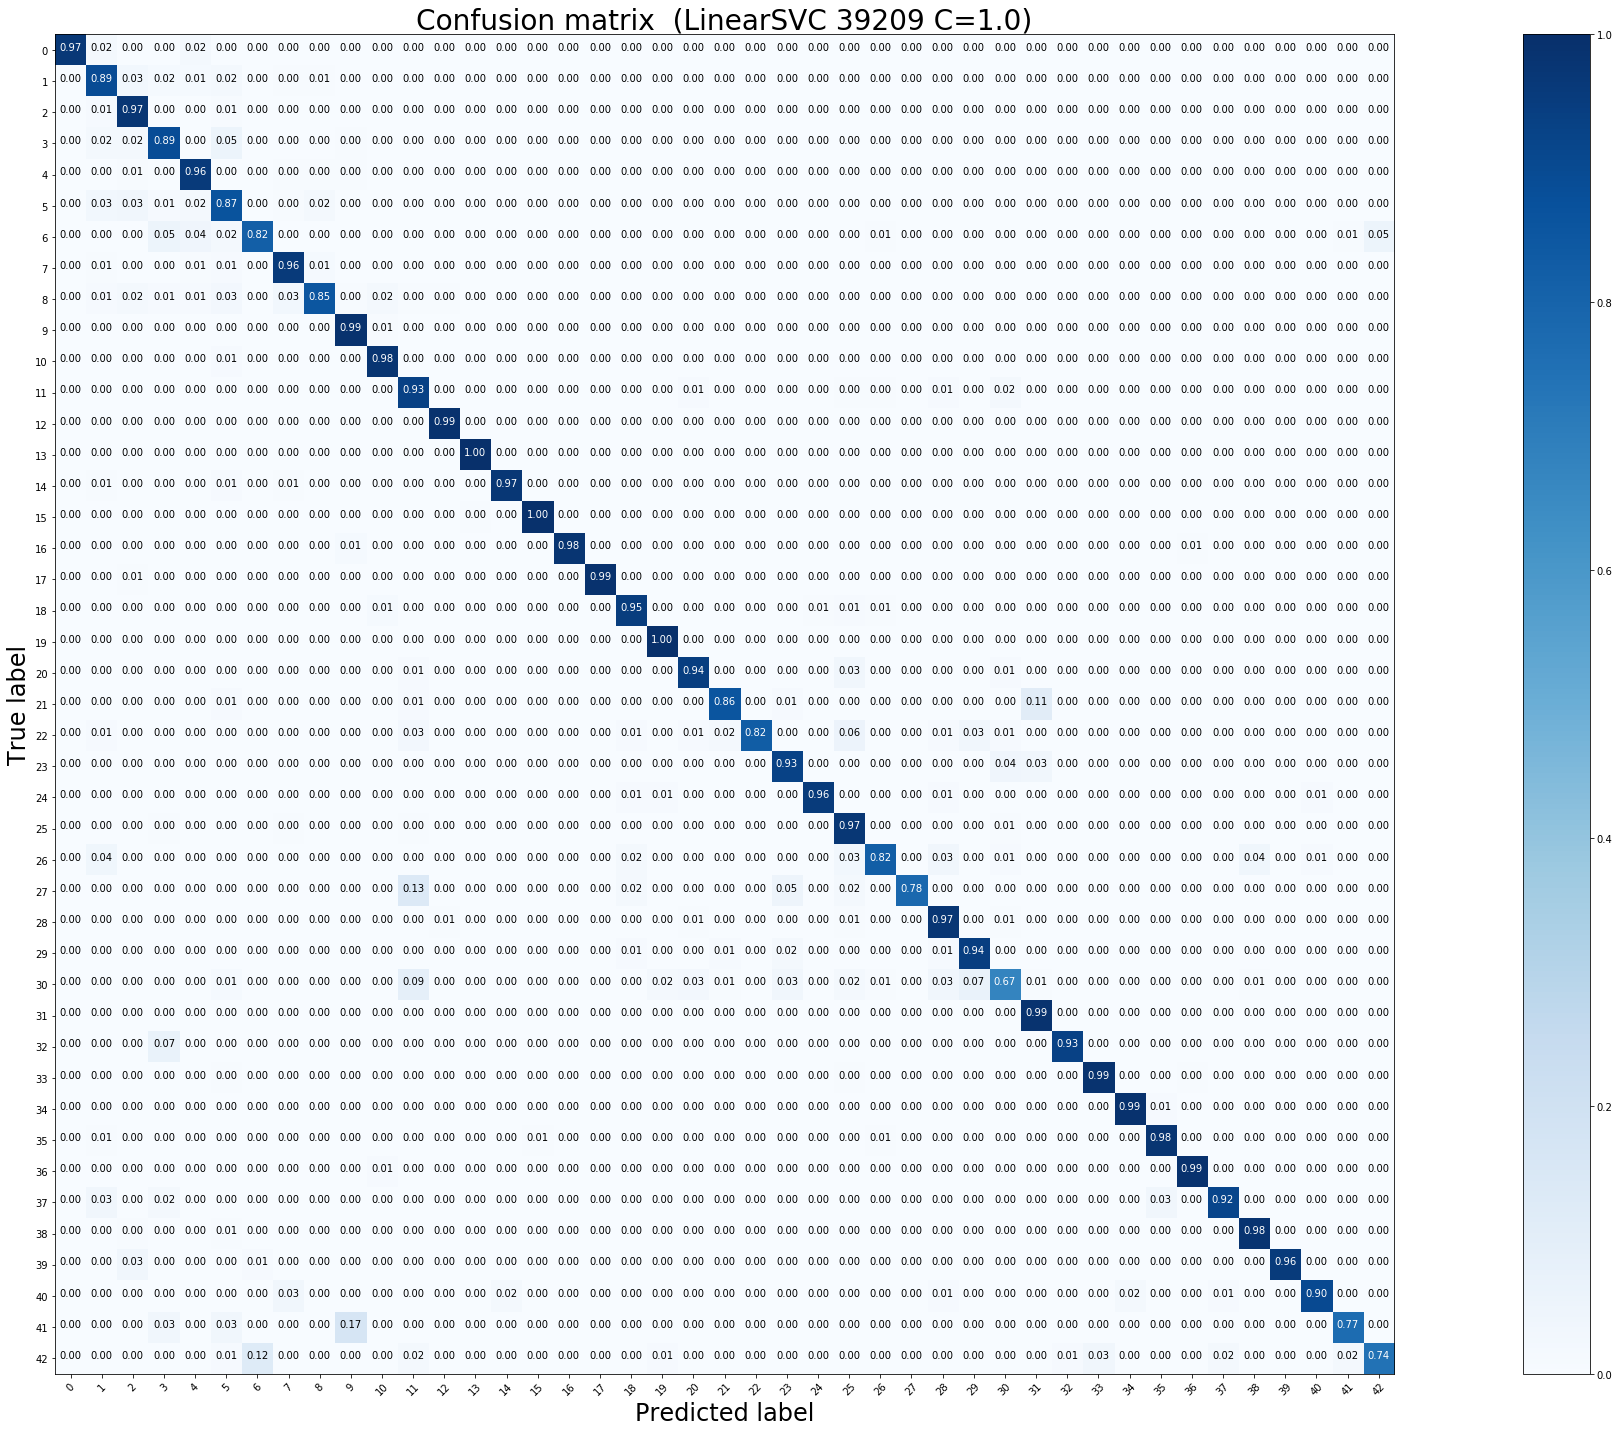

Test accuracy:  0.942596991290578 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        60
           1       0.91      0.89      0.90       720
           2       0.90      0.97      0.94       750
           3       0.90      0.89      0.89       450
           4       0.95      0.96      0.95       660
           5       0.86      0.87      0.87       630
           6       0.91      0.82      0.86       150
           7       0.93      0.96      0.95       450
           8       0.93      0.85      0.89       450
           9       0.95      0.99      0.97       480
          10       0.97      0.98      0.98       660
          11       0.92      0.93      0.93       420
          12       0.99      0.99      0.99       690
          13       0.99      1.00      1.00       720
          14       0.96      0.97      0.97       270
          15       0.98      1.00      0.99       210
          16       0.99      0.98      0.98  

In [7]:
########################################################################################
###########   LinearSVC, squared_hinge  ########################################
###########   Defaultwerte   ###########################################################
########################################################################################

train_LinearSVC_sq(X_tr_500, X_test_9_4_2, y_tr_500, y_test, 1, '500',1.0, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "HOG_942_balanced.pkl")
train_LinearSVC_sq(X_tr_1000, X_test_9_4_2, y_tr_1000, y_test, 1, '1000',1.0, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "HOG_942_balanced.pkl")
train_LinearSVC_sq(X_tr_2000, X_test_9_4_2, y_tr_2000, y_test, 1, '2000',1.0, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "HOG_942_balanced.pkl")
train_LinearSVC_sq(X_tr_5000, X_test_9_4_2, y_tr_5000, y_test, 1, '5000',1.0, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "HOG_942_balanced.pkl")
train_LinearSVC_sq(X_tr_10000, X_test_9_4_2, y_tr_10000, y_test, 1, '10000',1.0, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "HOG_942_balanced.pkl")
train_LinearSVC_sq(X_tr_20000, X_test_9_4_2, y_tr_20000, y_test, 1, '20000',1.0, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "HOG_942_balanced.pkl")
train_LinearSVC_sq(X_tr, X_test_9_4_2, y_tr, y_test, 1, '39209',1.0, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "HOG_942_balanced.pkl")

In [7]:
#########################################################################
#### GridSearch, LinearSVC, squared-hinge  ##############################
#### 1. Durchlauf  ######################################################
#########################################################################
print('********************************************************************************')
print(' GridSearch 500 1. DL: ')
clf_500_lin, time_500_lin = tuning_hyper_params(X_tr_500, y_tr_500, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2), 'l2', 'squared_hinge', 1)
save_trained_model_as_pkl(clf_500_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/500/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_1DL.pkl")
save_as_csv(time_500_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/500/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_1_DL.csv')
print('********************************************************************************')
print(' GridSearch 1000 1. DL: ')
clf_1000_lin, time_1000_lin = tuning_hyper_params(X_tr_1000, y_tr_1000, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge', 1)
save_trained_model_as_pkl(clf_1000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/1000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_1DL.pkl")
save_as_csv(time_1000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/1000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_1_DL.csv')
print('********************************************************************************')
print(' GridSearch 2000 1. DL: ')
clf_2000_lin, time_2000_lin = tuning_hyper_params(X_tr_2000, y_tr_2000, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge', 1)
save_trained_model_as_pkl(clf_2000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/2000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_1DL.pkl")
save_as_csv(time_2000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/2000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_1_DL.csv')
print('********************************************************************************')
print(' GridSearch 5000 1. DL: ')
clf_5000_lin, time_5000_lin = tuning_hyper_params(X_tr_5000, y_tr_5000, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge', 1)
save_trained_model_as_pkl(clf_5000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/5000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_1DL.pkl")
save_as_csv(time_5000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/5000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_1_DL.csv')

print('********************************************************************************')
print(' GridSearch 10000 1. DL: ')
print('')
clf_10000_lin, time_10000_lin = tuning_hyper_params(X_tr_10000, y_tr_10000, X_test_9_4_2, y_test, 'LinearSVC', 5, 0, 0, 
                                                np.logspace(-16,6,12, base=2), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_10000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/10000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_1DL.pkl")
save_as_csv(time_10000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/10000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_1_DL.csv')

print('********************************************************************************')
print(' GridSearch 20000 1. DL: ')
print('')
clf_20000_lin, time_20000_lin = tuning_hyper_params(X_tr_20000, y_tr_20000, X_test_9_4_2, y_test, 'LinearSVC', 3, 0, 0, 
                                                np.logspace(-16,6,12, base=2), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_20000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/20000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_1DL.pkl")
save_as_csv(time_20000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/20000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_1_DL.csv')

print('********************************************************************************')
print(' GridSearch 39209 1. DL: ')
print('')
clf_39209_lin, time_39209_lin = tuning_hyper_params(X_train_9_4_2, y_train, X_test_9_4_2, y_test, 'LinearSVC', 3, 0, 0, 
                                                np.logspace(-16,6,12, base=2), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_39209_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/39209/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_1DL.pkl")
save_as_csv(time_39209_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/39209/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_1_DL.csv')

********************************************************************************
 GridSearch 500 1. DL: 


C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range: [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01 6.400e+01 2.560e+02 1.024e+03]

 Bester Score:  0.7932823587915793

 Besten Parameter:  {'svm__C': 0.015625}
Bester Estimator score:  0.8422802850356295
Precision-Score: 0.300044 (0.117292) mit Parameter: {'svm__C': 1.52587890625e-05}
Precision-Score: 0.505952 (0.102402) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.670317 (0.065054) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.727839 (0.078876) mit Parameter: {'svm__C': 0.0009765625}
Precision-Score: 0.785725 (0.074919) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.794521 (0.096846) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.791981 (0.115262) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.787757 (0.122069) mit Parameter: {'svm__C': 0.25}
Precision-Score: 0.783873 (0.119482) mit Parameter: {'svm__C': 1.0}
Precision-Score: 0.782502 (0.120956) mit Parameter

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range: [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01 6.400e+01 2.560e+02 1.024e+03]

 Bester Score:  0.9007979624640882

 Besten Parameter:  {'svm__C': 0.0625}
Bester Estimator score:  0.8951702296120349
Precision-Score: 0.341579 (0.069383) mit Parameter: {'svm__C': 1.52587890625e-05}
Precision-Score: 0.656178 (0.031950) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.793102 (0.047947) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.854650 (0.047603) mit Parameter: {'svm__C': 0.0009765625}
Precision-Score: 0.886955 (0.035318) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.901117 (0.036408) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.899555 (0.043850) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.898715 (0.043165) mit Parameter: {'svm__C': 0.25}
Precision-Score: 0.893638 (0.045841) mit Parameter: {'svm__C': 1.0}
Precision-Score: 0.893638 (0.045841) mit Parameter: 


 C_range: [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01 6.400e+01 2.560e+02 1.024e+03]

 Bester Score:  0.9644464635126606

 Besten Parameter:  {'svm__C': 0.015625}
Bester Estimator score:  0.9292953285827396
Precision-Score: 0.830670 (0.041449) mit Parameter: {'svm__C': 1.52587890625e-05}
Precision-Score: 0.888556 (0.017309) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.909325 (0.010109) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.939942 (0.015673) mit Parameter: {'svm__C': 0.0009765625}
Precision-Score: 0.958394 (0.011030) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.968020 (0.008386) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.967872 (0.009476) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.967408 (0.009990) mit Parameter: {'svm__C': 0.25}
Precision-Score: 0.966619 (0.009607) mit Parameter: {'svm__C': 1.0}
Precision-Score: 0.965860 (0.009648) mit Parameter


 C_range: [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01 6.400e+01]

 Bester Score:  0.9766703576383523

 Besten Parameter:  {'svm__C': 0.0625}
Bester Estimator score:  0.9428345209817894
Precision-Score: 0.897458 (0.003235) mit Parameter: {'svm__C': 1.52587890625e-05}
Precision-Score: 0.905009 (0.001655) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.931190 (0.001174) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.953615 (0.002887) mit Parameter: {'svm__C': 0.0009765625}
Precision-Score: 0.967572 (0.001186) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.974280 (0.001244) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.976881 (0.001059) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.977842 (0.000618) mit Parameter: {'svm__C': 0.25}
Precision-Score: 0.976090 (0.000696) mit Parameter: {'svm__C': 1.0}
Precision-Score: 0.974031 (0.001380) mit Parameter: {'svm__C': 4.0}
Prec

In [8]:
#########################################################################
#### GridSearch, LinearSVC, squared-hinge  ######################################
#### 2. Durchlauf  ######################################################
#########################################################################
print('********************************************************************************')
print(' GridSearch 500 2. DL: ')
clf_500_lin, time_500_lin = tuning_hyper_params(X_tr_500, y_tr_500, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                get_finer_range(0.015625), np.logspace(-16,4,11, base=2), 'l2', 'squared_hinge', 1)
save_trained_model_as_pkl(clf_500_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/500/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_2DL.pkl")
save_as_csv(time_500_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/500/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_2_DL.csv')
print('********************************************************************************')
print(' GridSearch 1000 2. DL: ')
clf_1000_lin, time_1000_lin = tuning_hyper_params(X_tr_1000, y_tr_1000, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                get_finer_range(0.0625), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge', 1)
save_trained_model_as_pkl(clf_1000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/1000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_2DL.pkl")
save_as_csv(time_1000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/1000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_2_DL.csv')
print('********************************************************************************')
print(' GridSearch 2000 2. DL: ')
clf_2000_lin, time_2000_lin = tuning_hyper_params(X_tr_2000, y_tr_2000, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                get_finer_range(0.015625), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge', 1)
save_trained_model_as_pkl(clf_2000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/2000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_2DL.pkl")
save_as_csv(time_2000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/2000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_2_DL.csv')
print('********************************************************************************')
print(' GridSearch 5000 2. DL: ')
clf_5000_lin, time_5000_lin = tuning_hyper_params(X_tr_5000, y_tr_5000, X_test_9_4_2, y_test, 'LinearSVC', 10, 0, 0, 
                                                get_finer_range(0.015625), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge', 1)
save_trained_model_as_pkl(clf_5000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/5000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_2DL.pkl")
save_as_csv(time_5000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/5000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_2_DL.csv')

print('********************************************************************************')
print(' GridSearch 10000 2. DL: ')
print('')
clf_10000_lin, time_10000_lin = tuning_hyper_params(X_tr_10000, y_tr_10000, X_test_9_4_2, y_test, 'LinearSVC', 5, 0, 0, 
                                                get_finer_range(0.0625), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_10000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/10000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_2DL.pkl")
save_as_csv(time_10000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/10000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_2_DL.csv')

print('********************************************************************************')
print(' GridSearch 20000 2. DL: ')
print('')
clf_20000_lin, time_20000_lin = tuning_hyper_params(X_tr_20000, y_tr_20000, X_test_9_4_2, y_test, 'LinearSVC', 3, 0, 0, 
                                                get_finer_range(0.0625), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_20000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/20000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_2DL.pkl")
save_as_csv(time_20000_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/20000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_2_DL.csv')

print('********************************************************************************')
print(' GridSearch 39209 2. DL: ')
print('')
clf_39209_lin, time_39209_lin = tuning_hyper_params(X_train_9_4_2, y_train, X_test_9_4_2, y_test, 'LinearSVC', 3, 0, 0, 
                                                get_finer_range(0.015625), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_39209_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/39209/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_2DL.pkl")
save_as_csv(time_39209_lin, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/39209/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_2_DL.csv')

********************************************************************************
 GridSearch 500 2. DL: 


C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range: [0.004 0.005 0.006 0.007 0.008 0.009 0.011 0.013 0.016 0.019 0.022 0.026
 0.031 0.037 0.044 0.053 0.062]

 Bester Score:  0.797918174592845

 Besten Parameter:  {'svm__C': 0.03716272234383503}
Bester Estimator score:  0.8484560570071259
Precision-Score: 0.785725 (0.074919) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.795463 (0.082944) mit Parameter: {'svm__C': 0.004645340292979379}
Precision-Score: 0.791984 (0.084328) mit Parameter: {'svm__C': 0.005524271728019903}
Precision-Score: 0.793493 (0.086594) mit Parameter: {'svm__C': 0.0065695032441696445}
Precision-Score: 0.795077 (0.098683) mit Parameter: {'svm__C': 0.0078125}
Precision-Score: 0.787873 (0.099168) mit Parameter: {'svm__C': 0.009290680585958758}
Precision-Score: 0.789253 (0.094815) mit Parameter: {'svm__C': 0.011048543456039806}
Precision-Score: 0.789328 (0.096160) mit Parameter: {'svm__C': 0.013139006488339289}
Precision-Score: 0.794521 (0.096846) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range: [0.016 0.019 0.022 0.026 0.031 0.037 0.044 0.053 0.062 0.074 0.088 0.105
 0.125 0.149 0.177 0.21  0.25 ]

 Bester Score:  0.9028513904314697

 Besten Parameter:  {'svm__C': 0.07432544468767006}
Bester Estimator score:  0.8950118764845606
Precision-Score: 0.901117 (0.036408) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.899340 (0.040848) mit Parameter: {'svm__C': 0.018581361171917516}
Precision-Score: 0.900939 (0.040645) mit Parameter: {'svm__C': 0.02209708691207961}
Precision-Score: 0.899561 (0.043594) mit Parameter: {'svm__C': 0.026278012976678578}
Precision-Score: 0.900589 (0.043538) mit Parameter: {'svm__C': 0.03125}
Precision-Score: 0.900168 (0.044547) mit Parameter: {'svm__C': 0.03716272234383503}
Precision-Score: 0.897976 (0.044322) mit Parameter: {'svm__C': 0.04419417382415922}
Precision-Score: 0.898441 (0.043856) mit Parameter: {'svm__C': 0.052556025953357156}
Precision-Score: 0.899555 (0.043850) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.901877 (0

********************************************************************************
 GridSearch 5000 2. DL: 

 C_range: [0.004 0.005 0.006 0.007 0.008 0.009 0.011 0.013 0.016 0.019 0.022 0.026
 0.031 0.037 0.044 0.053 0.062]

 Bester Score:  0.965578774173541

 Besten Parameter:  {'svm__C': 0.02209708691207961}
Bester Estimator score:  0.9293745051464767
Precision-Score: 0.958394 (0.011030) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.960191 (0.009993) mit Parameter: {'svm__C': 0.004645340292979379}
Precision-Score: 0.961483 (0.009362) mit Parameter: {'svm__C': 0.005524271728019903}
Precision-Score: 0.962049 (0.009095) mit Parameter: {'svm__C': 0.0065695032441696445}
Precision-Score: 0.963159 (0.008644) mit Parameter: {'svm__C': 0.0078125}
Precision-Score: 0.964411 (0.009247) mit Parameter: {'svm__C': 0.009290680585958758}
Precision-Score: 0.964877 (0.009326) mit Parameter: {'svm__C': 0.011048543456039806}
Precision-Score: 0.967201 (0.008884) mit Parameter: {'svm__C': 0.013139


 C_range: [0.016 0.019 0.022 0.026 0.031 0.037 0.044 0.053 0.062 0.074 0.088 0.105
 0.125 0.149 0.177 0.21  0.25 ]

 Bester Score:  0.9769625360331625

 Besten Parameter:  {'svm__C': 0.07432544468767006}
Bester Estimator score:  0.942596991290578
Precision-Score: 0.974280 (0.001244) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.975584 (0.001300) mit Parameter: {'svm__C': 0.018581361171917516}
Precision-Score: 0.975864 (0.001131) mit Parameter: {'svm__C': 0.02209708691207961}
Precision-Score: 0.976406 (0.001271) mit Parameter: {'svm__C': 0.026278012976678578}
Precision-Score: 0.976366 (0.001314) mit Parameter: {'svm__C': 0.03125}
Precision-Score: 0.976456 (0.001624) mit Parameter: {'svm__C': 0.03716272234383503}
Precision-Score: 0.976284 (0.001706) mit Parameter: {'svm__C': 0.04419417382415922}
Precision-Score: 0.976959 (0.001686) mit Parameter: {'svm__C': 0.052556025953357156}
Precision-Score: 0.976881 (0.001059) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.977243 (0.

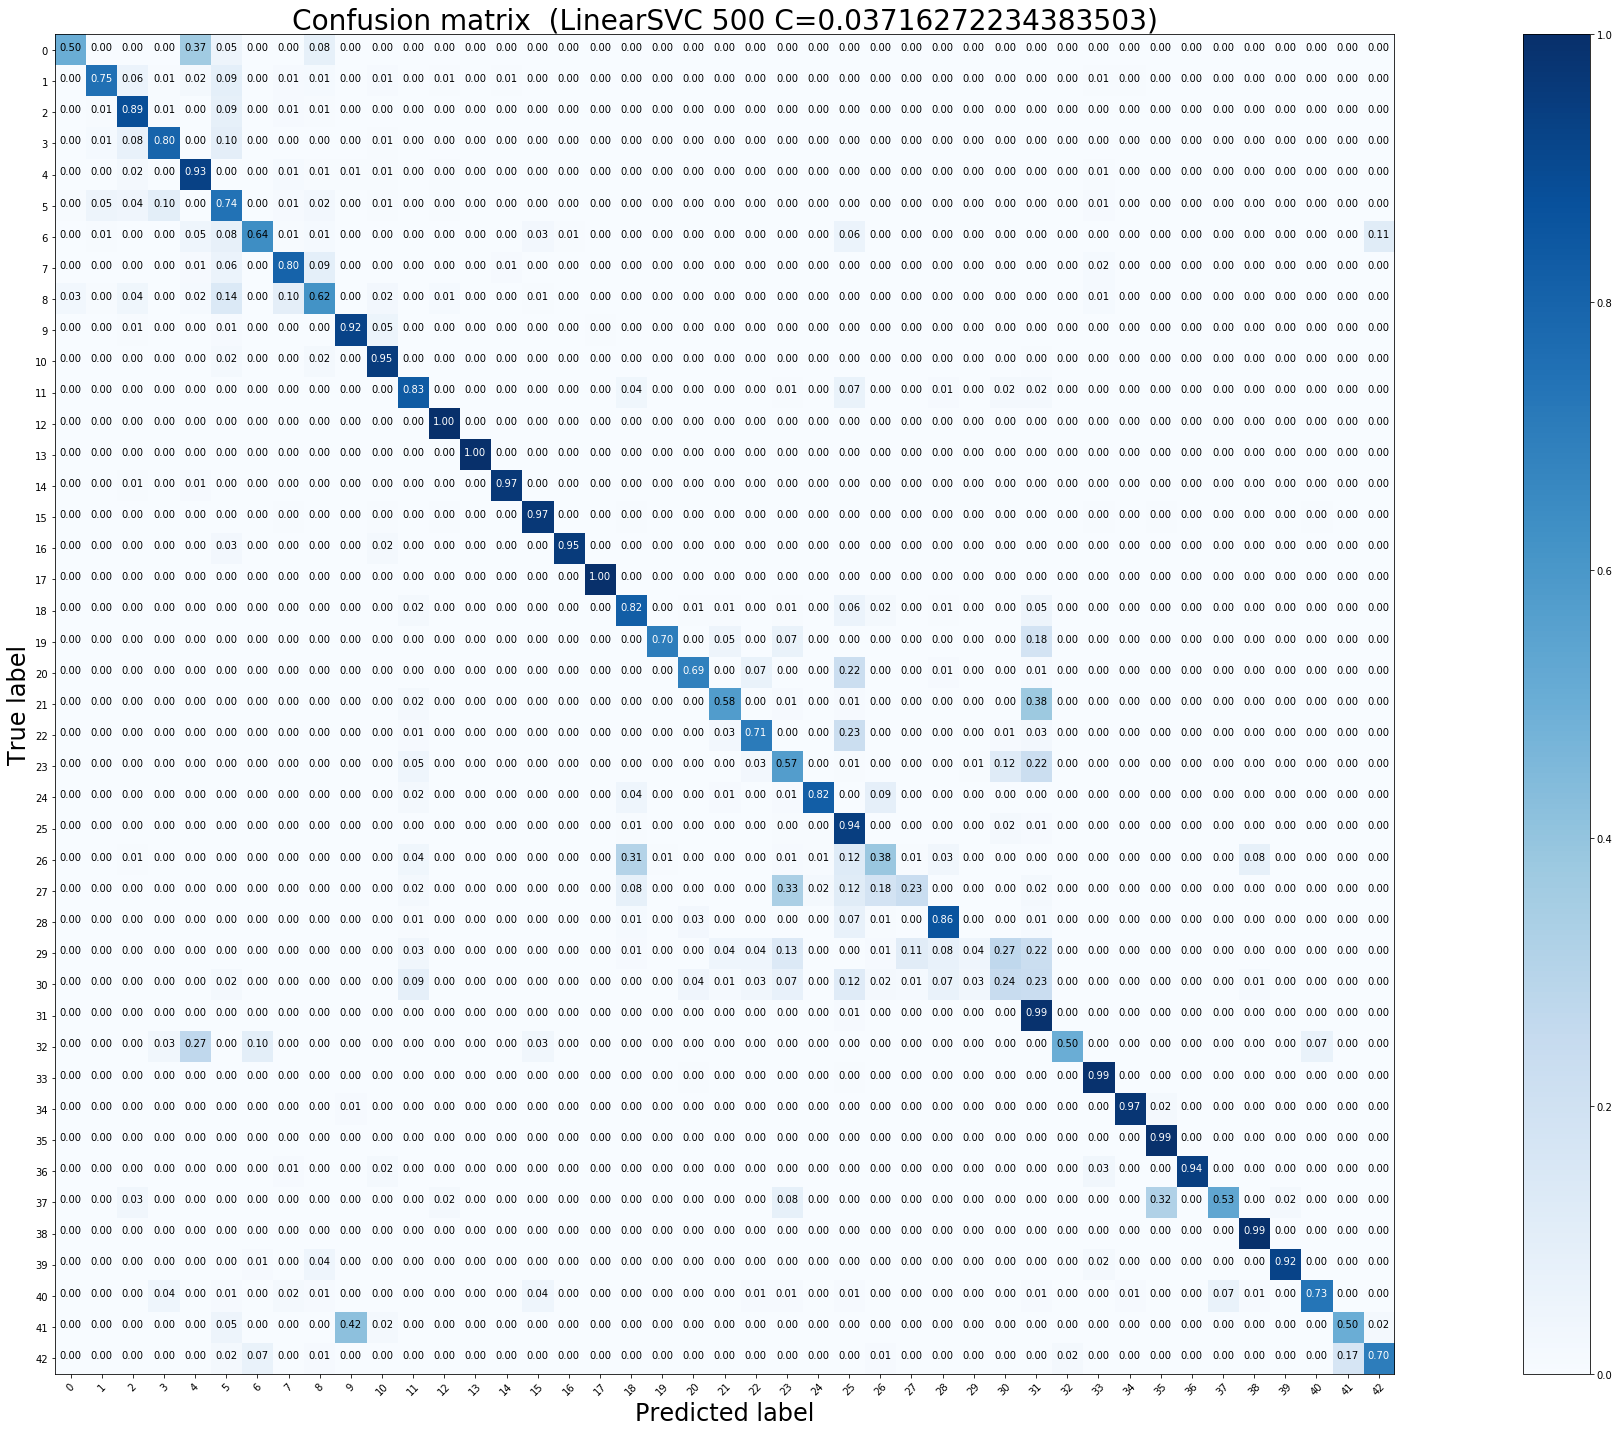

Test accuracy:  0.8484560570071259 

              precision    recall  f1-score   support

           0       0.64      0.50      0.56        60
           1       0.92      0.75      0.83       720
           2       0.82      0.89      0.85       750
           3       0.82      0.80      0.81       450
           4       0.89      0.93      0.91       660
           5       0.60      0.74      0.67       630
           6       0.86      0.64      0.73       150
           7       0.82      0.80      0.81       450
           8       0.74      0.62      0.67       450
           9       0.93      0.92      0.93       480
          10       0.91      0.95      0.93       660
          11       0.89      0.83      0.86       420
          12       0.97      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.96      0.97      0.96       270
          15       0.94      0.97      0.95       210
          16       0.98      0.95      0.97 

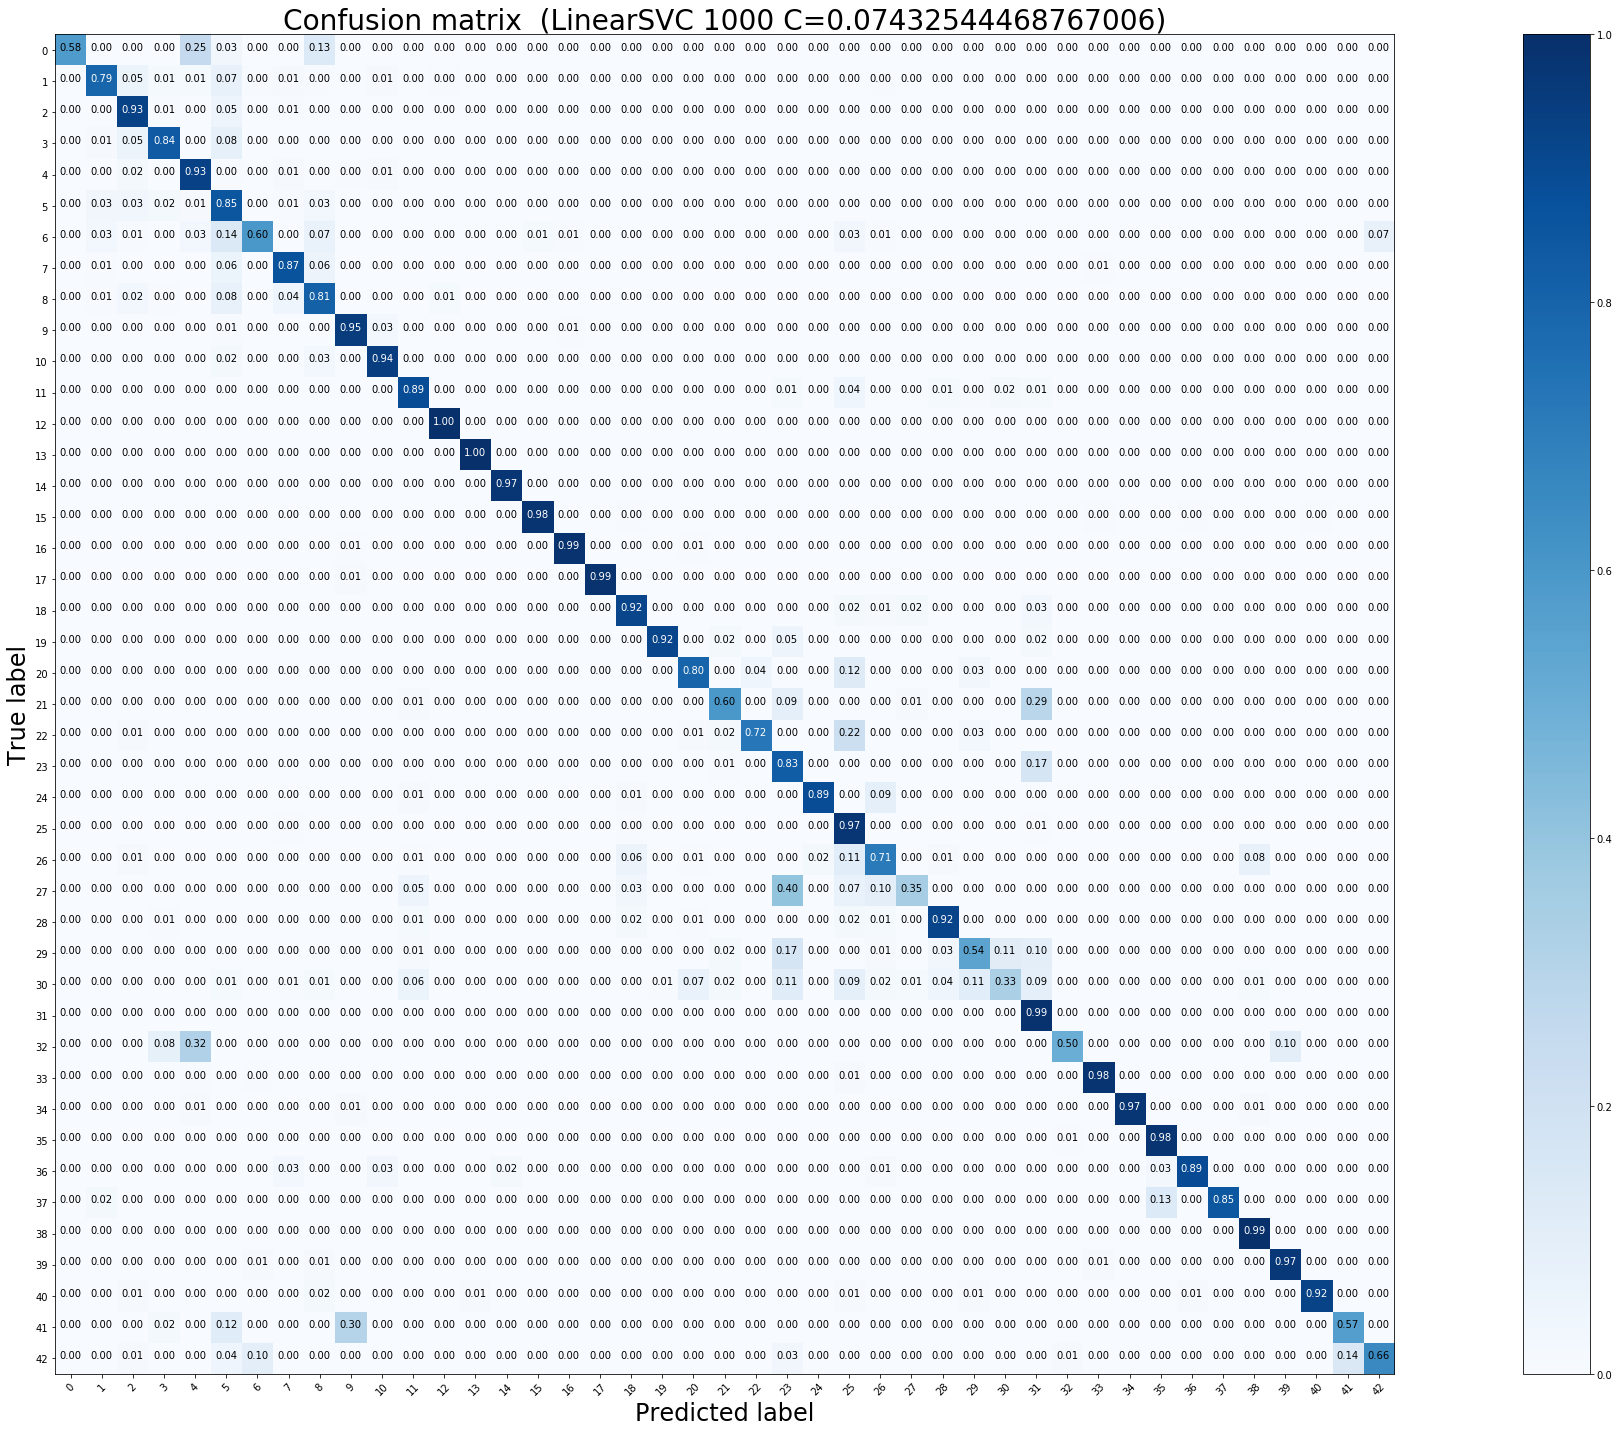

Test accuracy:  0.8950118764845606 

              precision    recall  f1-score   support

           0       0.97      0.58      0.73        60
           1       0.93      0.79      0.86       720
           2       0.85      0.93      0.89       750
           3       0.91      0.84      0.87       450
           4       0.91      0.93      0.92       660
           5       0.69      0.85      0.76       630
           6       0.85      0.60      0.70       150
           7       0.88      0.87      0.87       450
           8       0.81      0.81      0.81       450
           9       0.94      0.95      0.95       480
          10       0.94      0.94      0.94       660
          11       0.95      0.89      0.92       420
          12       0.98      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.98      0.97      0.98       270
          15       0.98      0.98      0.98       210
          16       0.95      0.99      0.97 

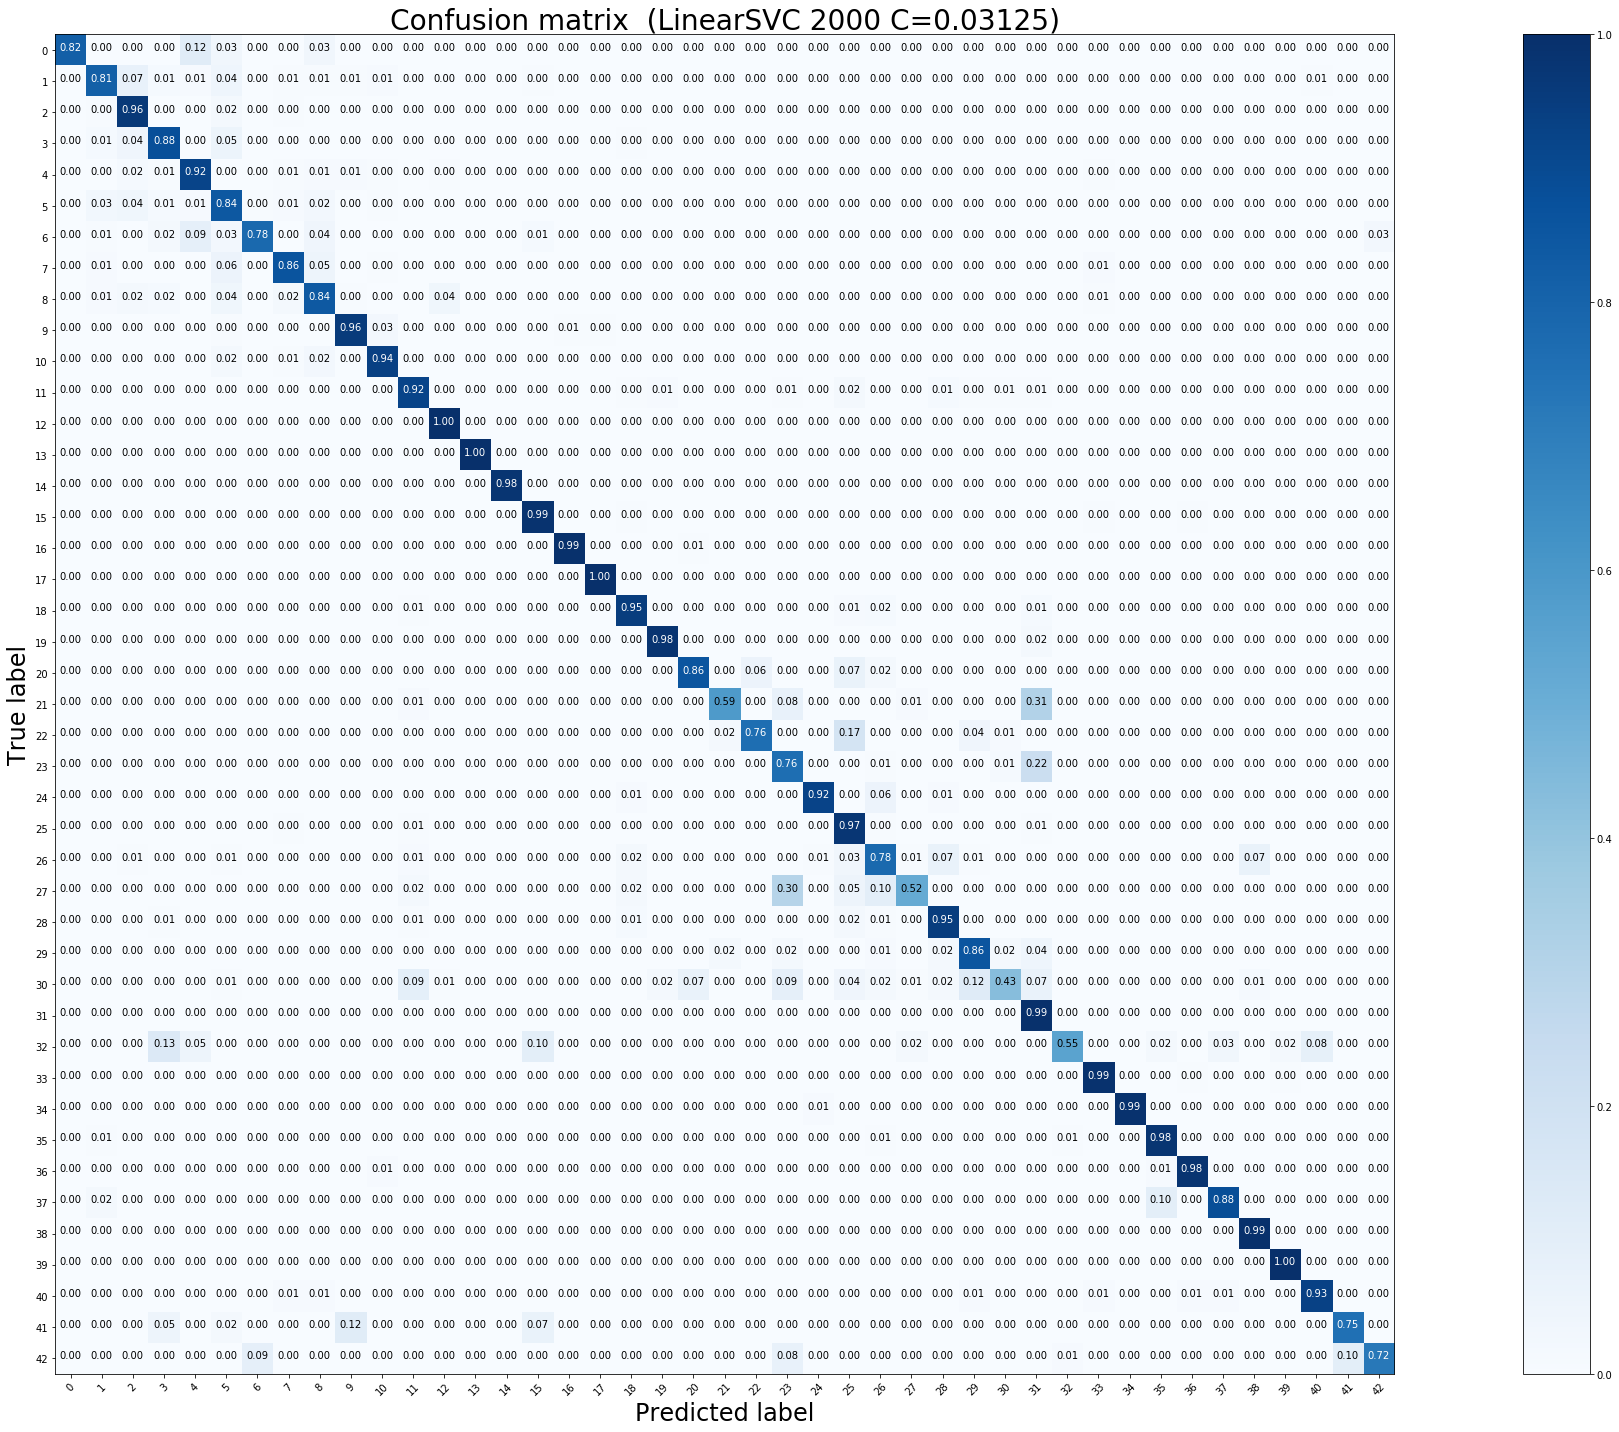

Test accuracy:  0.9143309580364212 

              precision    recall  f1-score   support

           0       0.92      0.82      0.87        60
           1       0.93      0.81      0.87       720
           2       0.86      0.96      0.91       750
           3       0.89      0.88      0.89       450
           4       0.94      0.92      0.93       660
           5       0.80      0.84      0.82       630
           6       0.91      0.78      0.84       150
           7       0.92      0.86      0.89       450
           8       0.84      0.84      0.84       450
           9       0.95      0.96      0.95       480
          10       0.95      0.94      0.94       660
          11       0.93      0.92      0.93       420
          12       0.97      1.00      0.98       690
          13       1.00      1.00      1.00       720
          14       0.98      0.98      0.98       270
          15       0.92      0.99      0.95       210
          16       0.96      0.99      0.98 

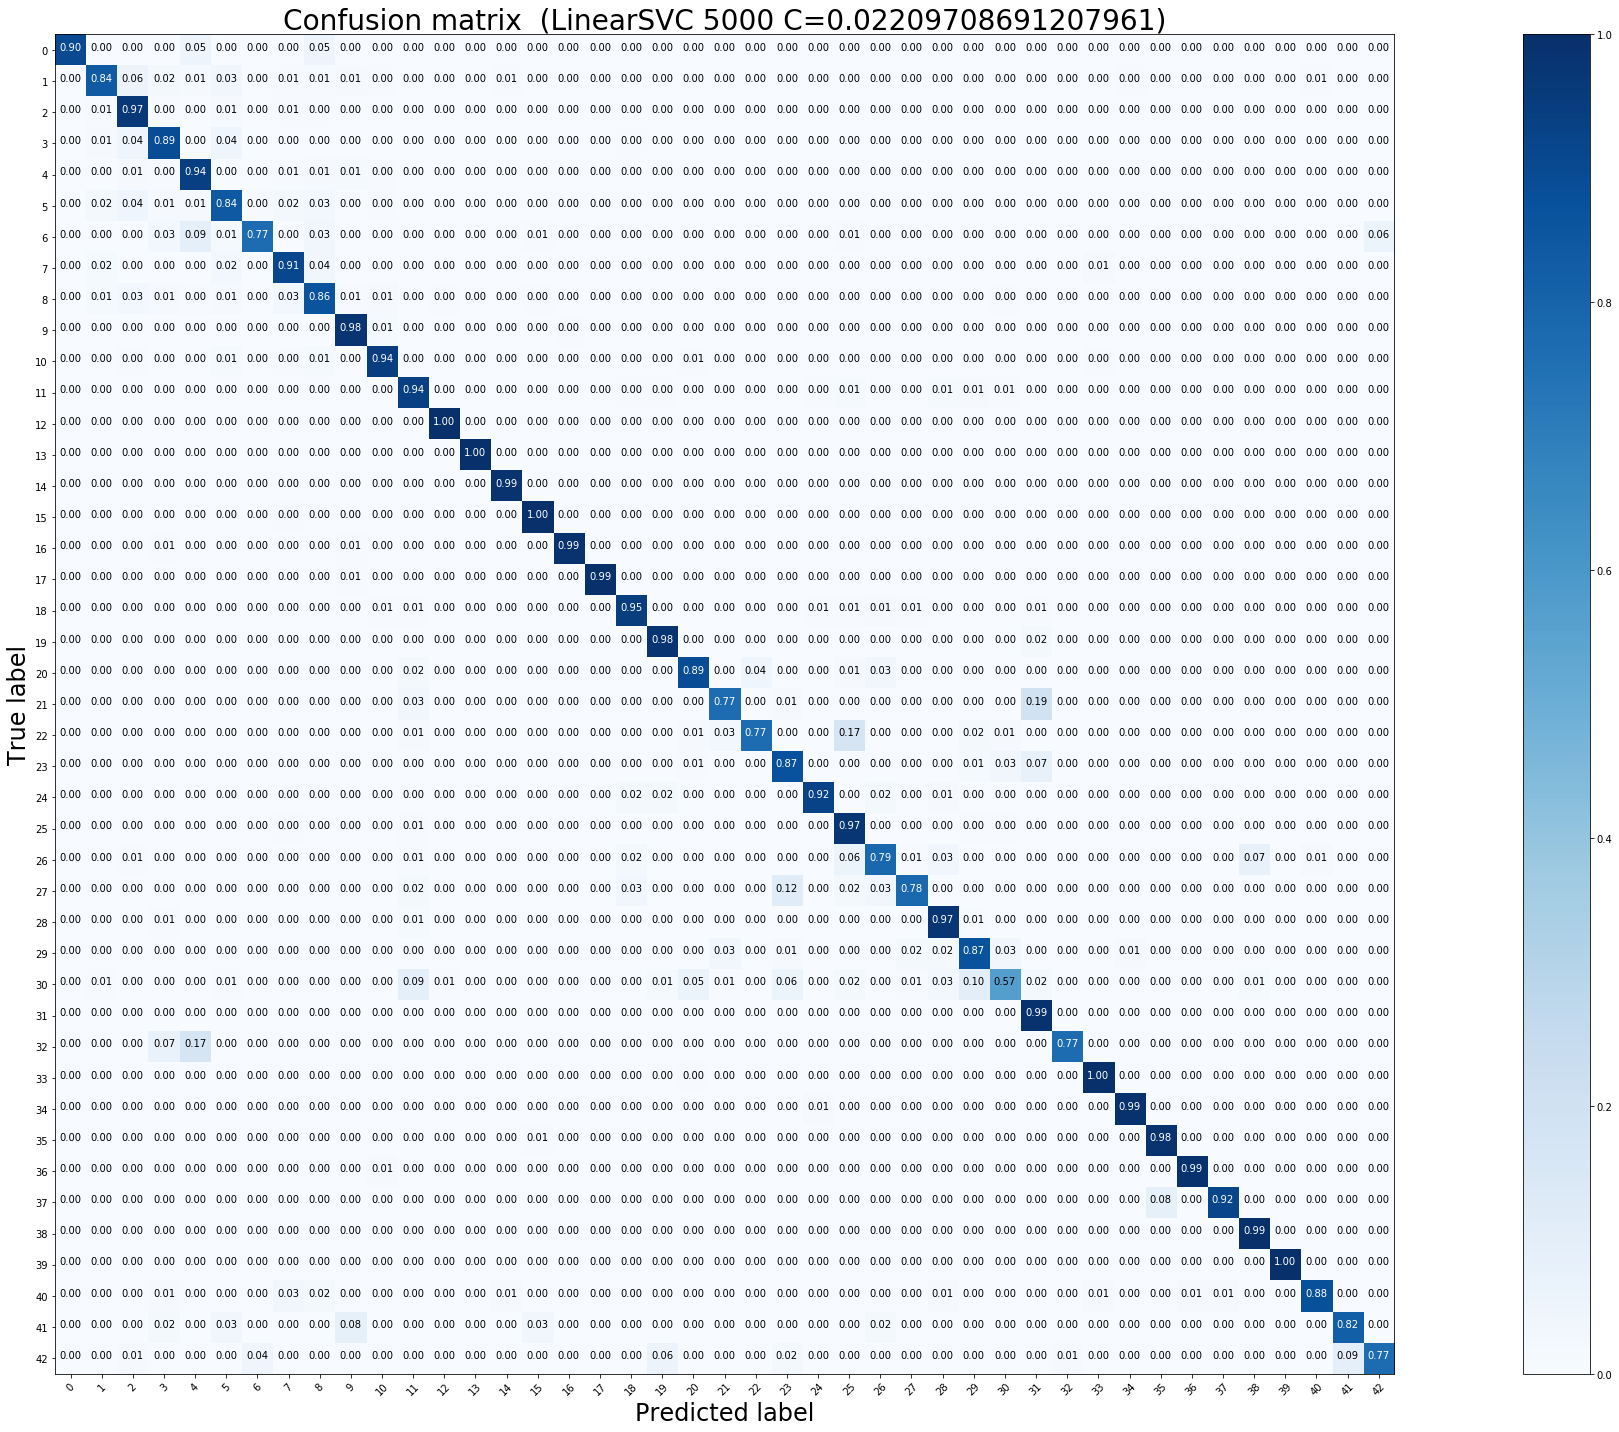

Test accuracy:  0.9293745051464767 

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        60
           1       0.94      0.84      0.88       720
           2       0.86      0.97      0.91       750
           3       0.90      0.89      0.89       450
           4       0.94      0.94      0.94       660
           5       0.87      0.84      0.86       630
           6       0.94      0.77      0.85       150
           7       0.90      0.91      0.90       450
           8       0.85      0.86      0.86       450
           9       0.94      0.98      0.96       480
          10       0.96      0.94      0.95       660
          11       0.92      0.94      0.93       420
          12       0.99      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       0.97      0.99      0.98       270
          15       0.96      1.00      0.98       210
          16       0.96      0.99      0.97 

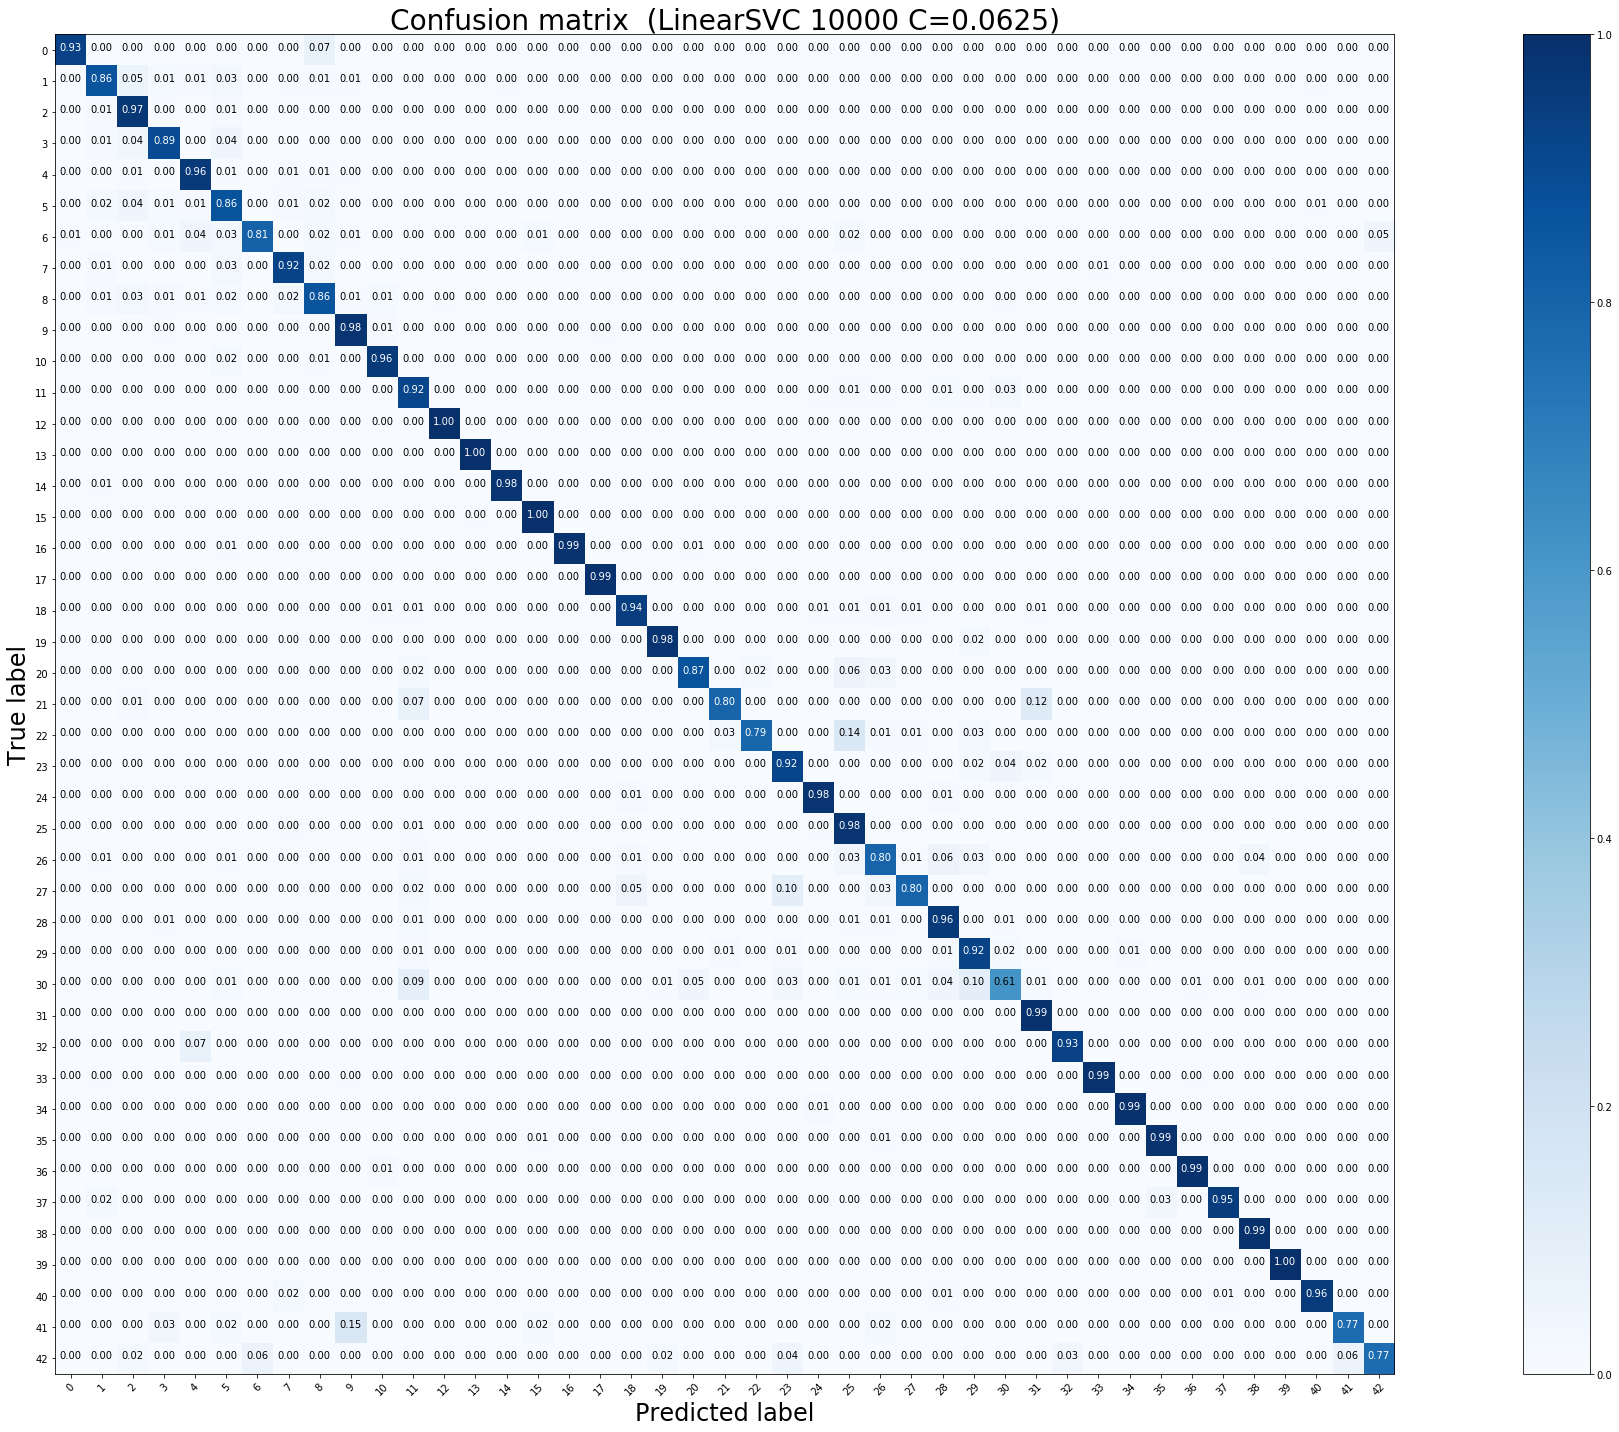

Test accuracy:  0.9380047505938243 

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        60
           1       0.94      0.86      0.90       720
           2       0.87      0.97      0.92       750
           3       0.92      0.89      0.91       450
           4       0.96      0.96      0.96       660
           5       0.86      0.86      0.86       630
           6       0.95      0.81      0.87       150
           7       0.92      0.92      0.92       450
           8       0.90      0.86      0.88       450
           9       0.94      0.98      0.96       480
          10       0.96      0.96      0.96       660
          11       0.91      0.92      0.91       420
          12       0.99      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.98      0.98      0.98       270
          15       0.96      1.00      0.98       210
          16       0.98      0.99      0.98 

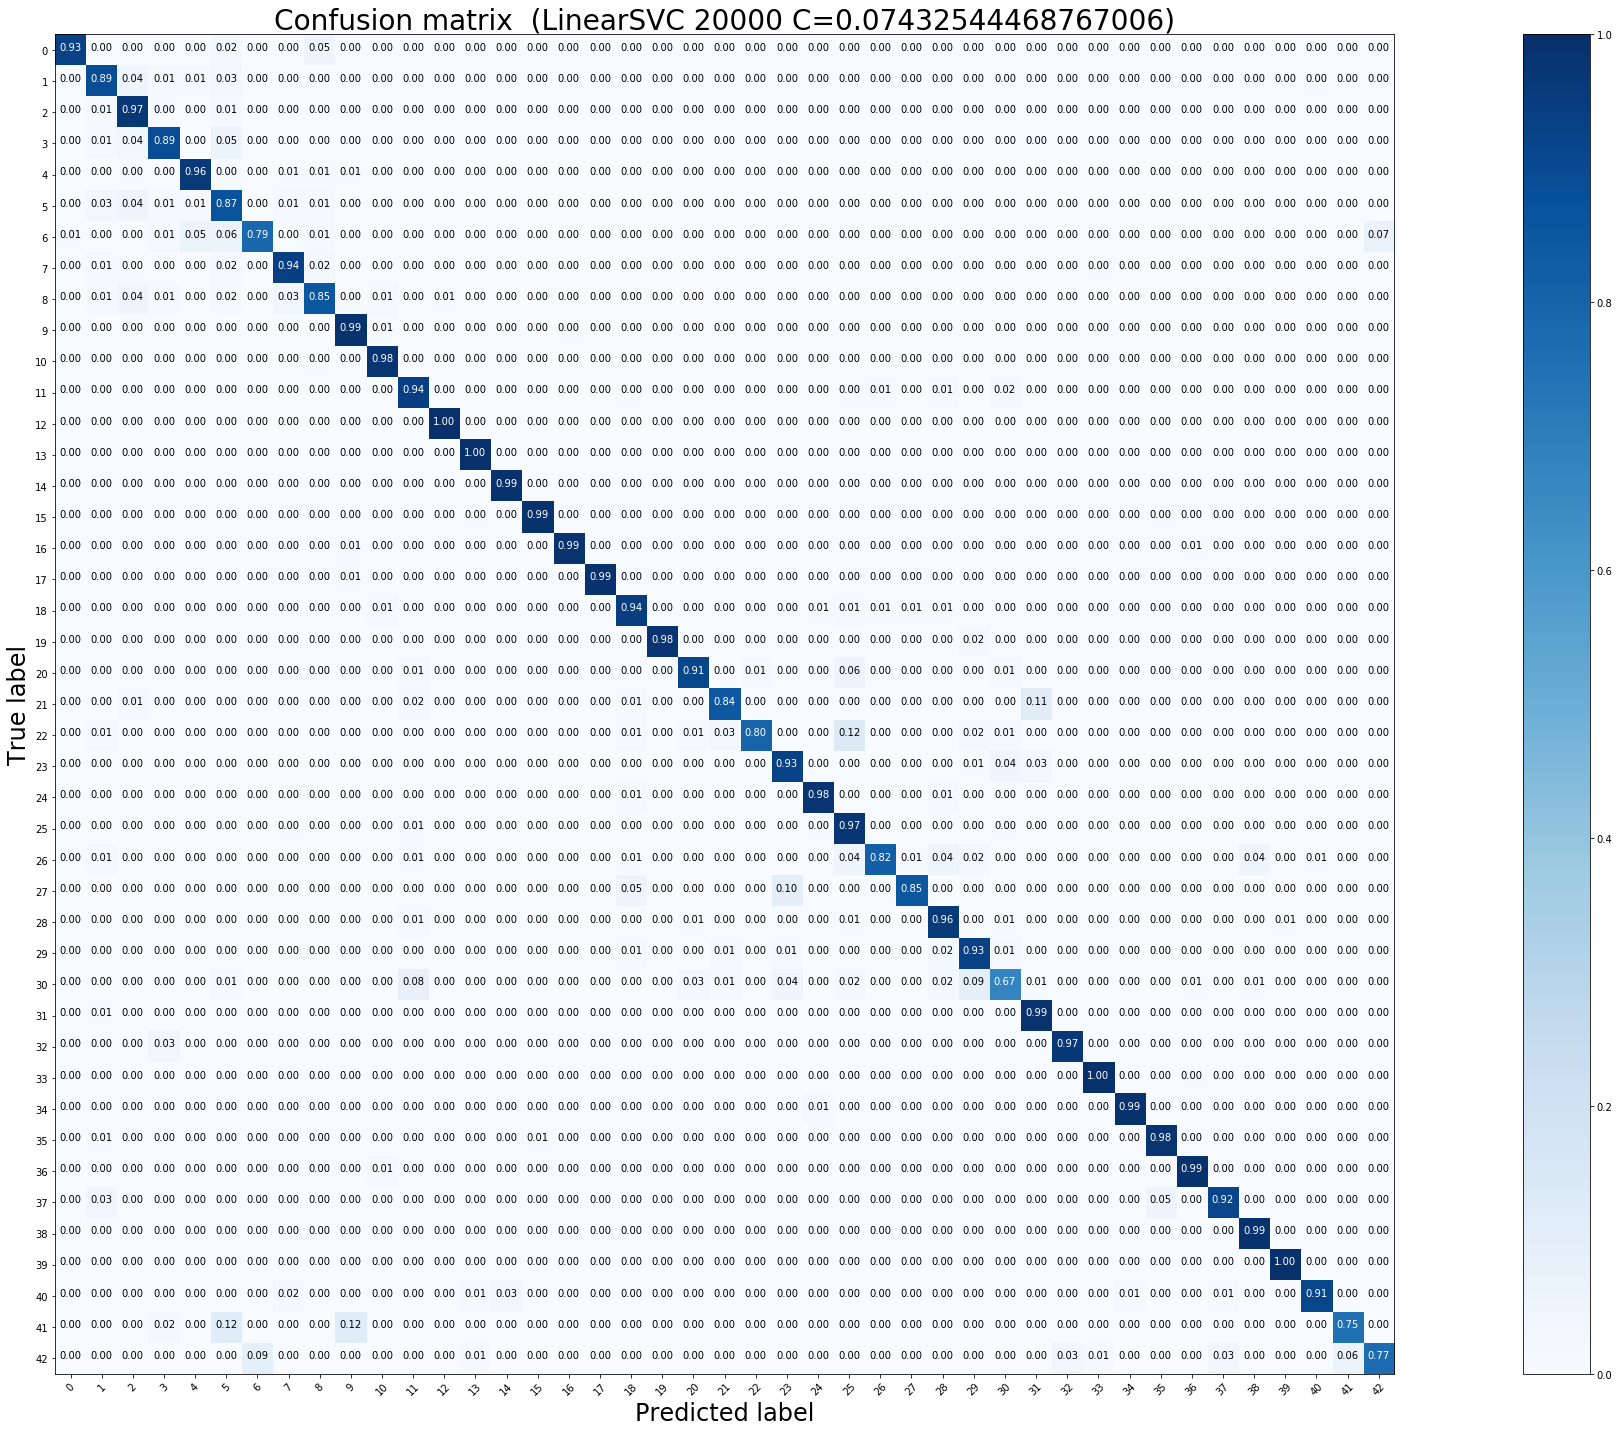

Test accuracy:  0.942596991290578 

              precision    recall  f1-score   support

           0       0.98      0.93      0.96        60
           1       0.92      0.89      0.91       720
           2       0.88      0.97      0.92       750
           3       0.92      0.89      0.90       450
           4       0.96      0.96      0.96       660
           5       0.85      0.87      0.86       630
           6       0.94      0.79      0.86       150
           7       0.93      0.94      0.93       450
           8       0.92      0.85      0.88       450
           9       0.96      0.99      0.97       480
          10       0.97      0.98      0.98       660
          11       0.94      0.94      0.94       420
          12       0.99      1.00      1.00       690
          13       0.99      1.00      1.00       720
          14       0.97      0.99      0.98       270
          15       0.98      0.99      0.98       210
          16       0.99      0.99      0.99  

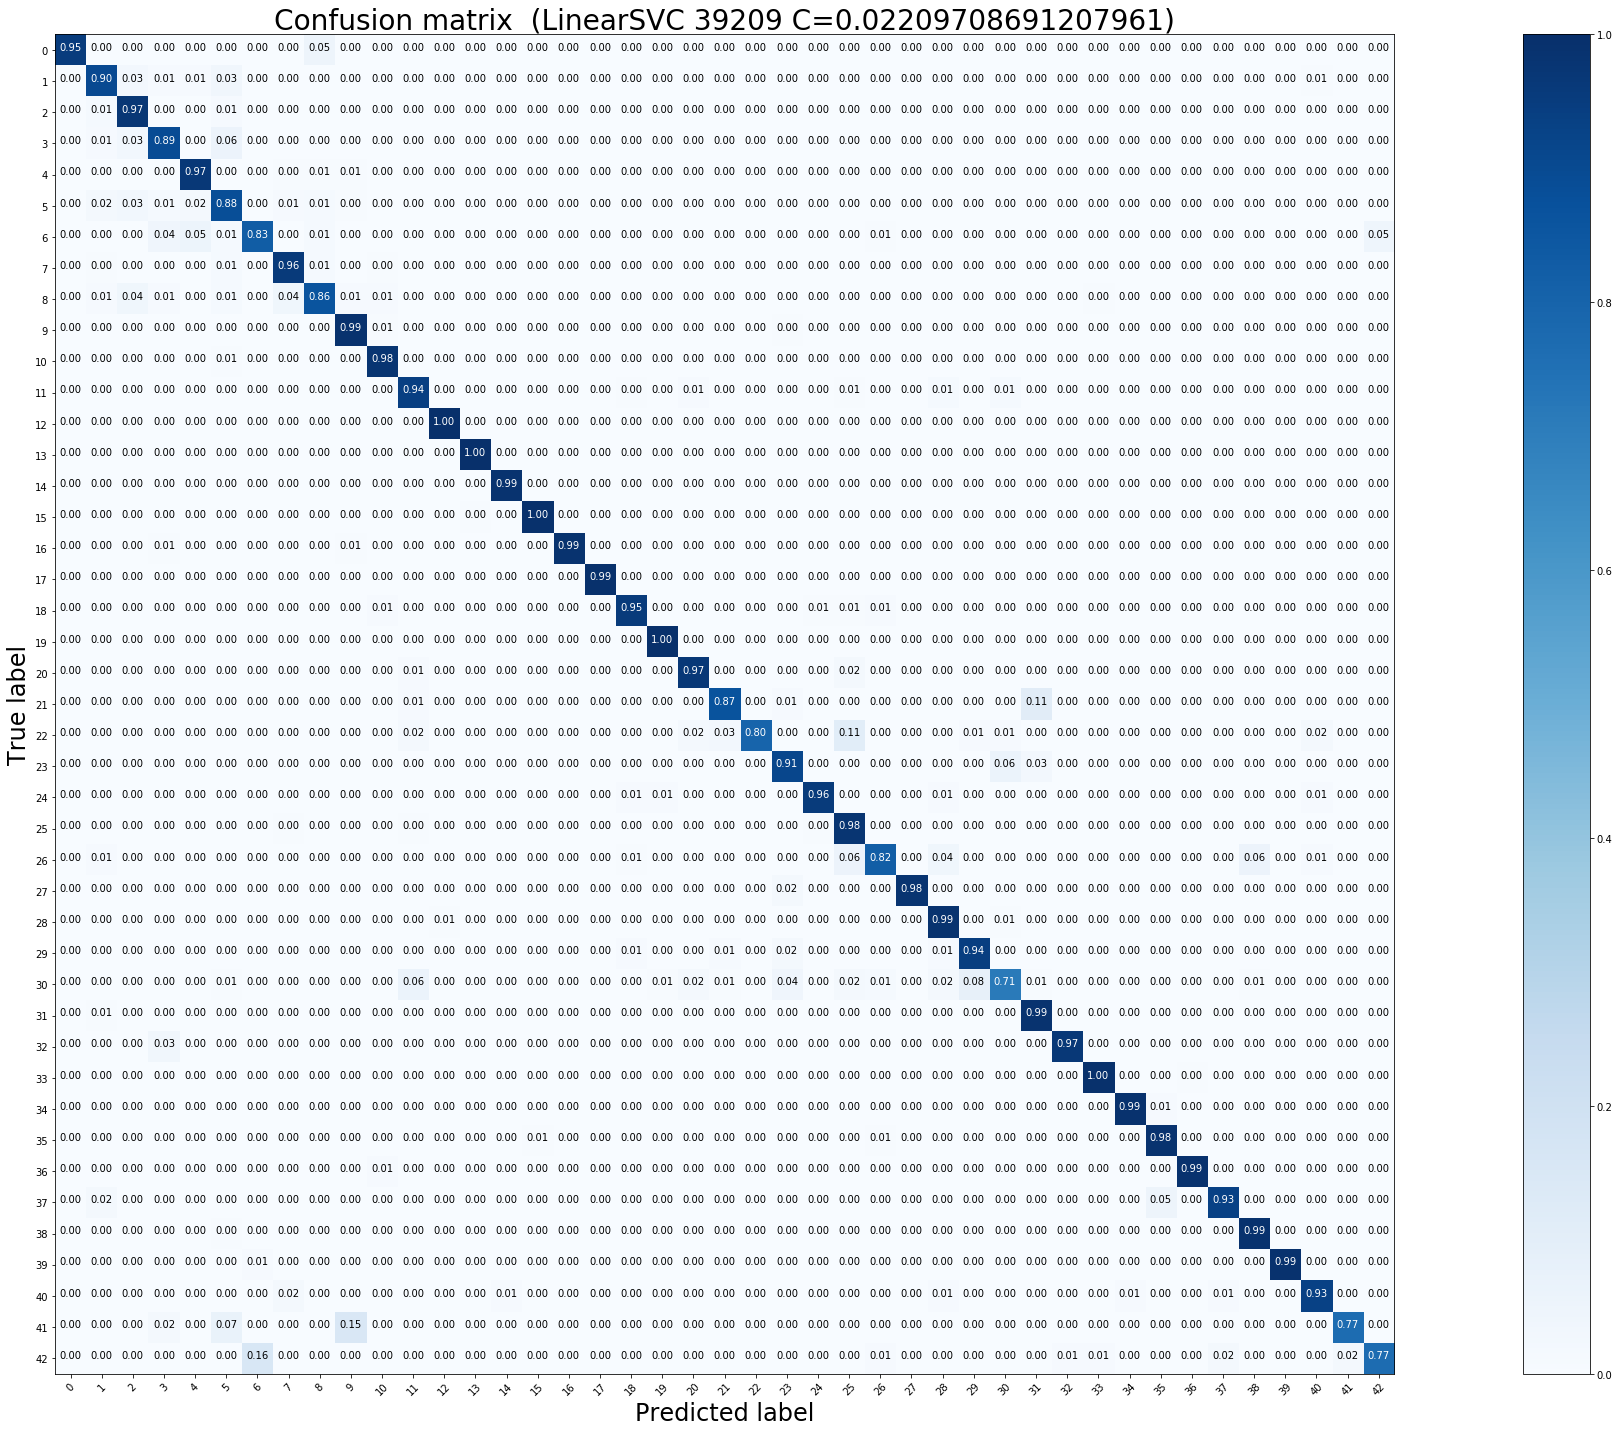

Test accuracy:  0.9495645288994458 

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        60
           1       0.94      0.90      0.92       720
           2       0.91      0.97      0.94       750
           3       0.93      0.89      0.91       450
           4       0.96      0.97      0.96       660
           5       0.87      0.88      0.88       630
           6       0.89      0.83      0.86       150
           7       0.93      0.96      0.94       450
           8       0.94      0.86      0.90       450
           9       0.95      0.99      0.97       480
          10       0.97      0.98      0.98       660
          11       0.96      0.94      0.95       420
          12       0.99      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       0.98      0.99      0.98       270
          15       0.98      1.00      0.99       210
          16       1.00      0.99      0.99 

In [9]:
########################################################################################
###########   LinearSVC, squared_hinge  ########################################
###########   opt. Hyperparameter       ###########################################################
########################################################################################

train_LinearSVC_sq(X_tr_500, X_test_9_4_2, y_tr_500, y_test, 1, '500', 0.03716272234383503, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "HOG_942_balanced.pkl")
train_LinearSVC_sq(X_tr_1000, X_test_9_4_2, y_tr_1000, y_test, 1, '1000', 0.07432544468767006, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "HOG_942_balanced.pkl")
train_LinearSVC_sq(X_tr_2000, X_test_9_4_2, y_tr_2000, y_test, 1, '2000', 0.03125, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "HOG_942_balanced.pkl")
train_LinearSVC_sq(X_tr_5000, X_test_9_4_2, y_tr_5000, y_test, 1, '5000', 0.02209708691207961, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "HOG_942_balanced.pkl")
train_LinearSVC_sq(X_tr_10000, X_test_9_4_2, y_tr_10000, y_test, 1, '10000', 0.0625, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "HOG_942_balanced.pkl")
train_LinearSVC_sq(X_tr_20000, X_test_9_4_2, y_tr_20000, y_test, 1, '20000',0.07432544468767006, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "HOG_942_balanced.pkl")
train_LinearSVC_sq(X_tr, X_test_9_4_2, y_tr, y_test, 1, '39209', 0.02209708691207961, 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "HOG_942_balanced.pkl")

Daten skalieren


C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


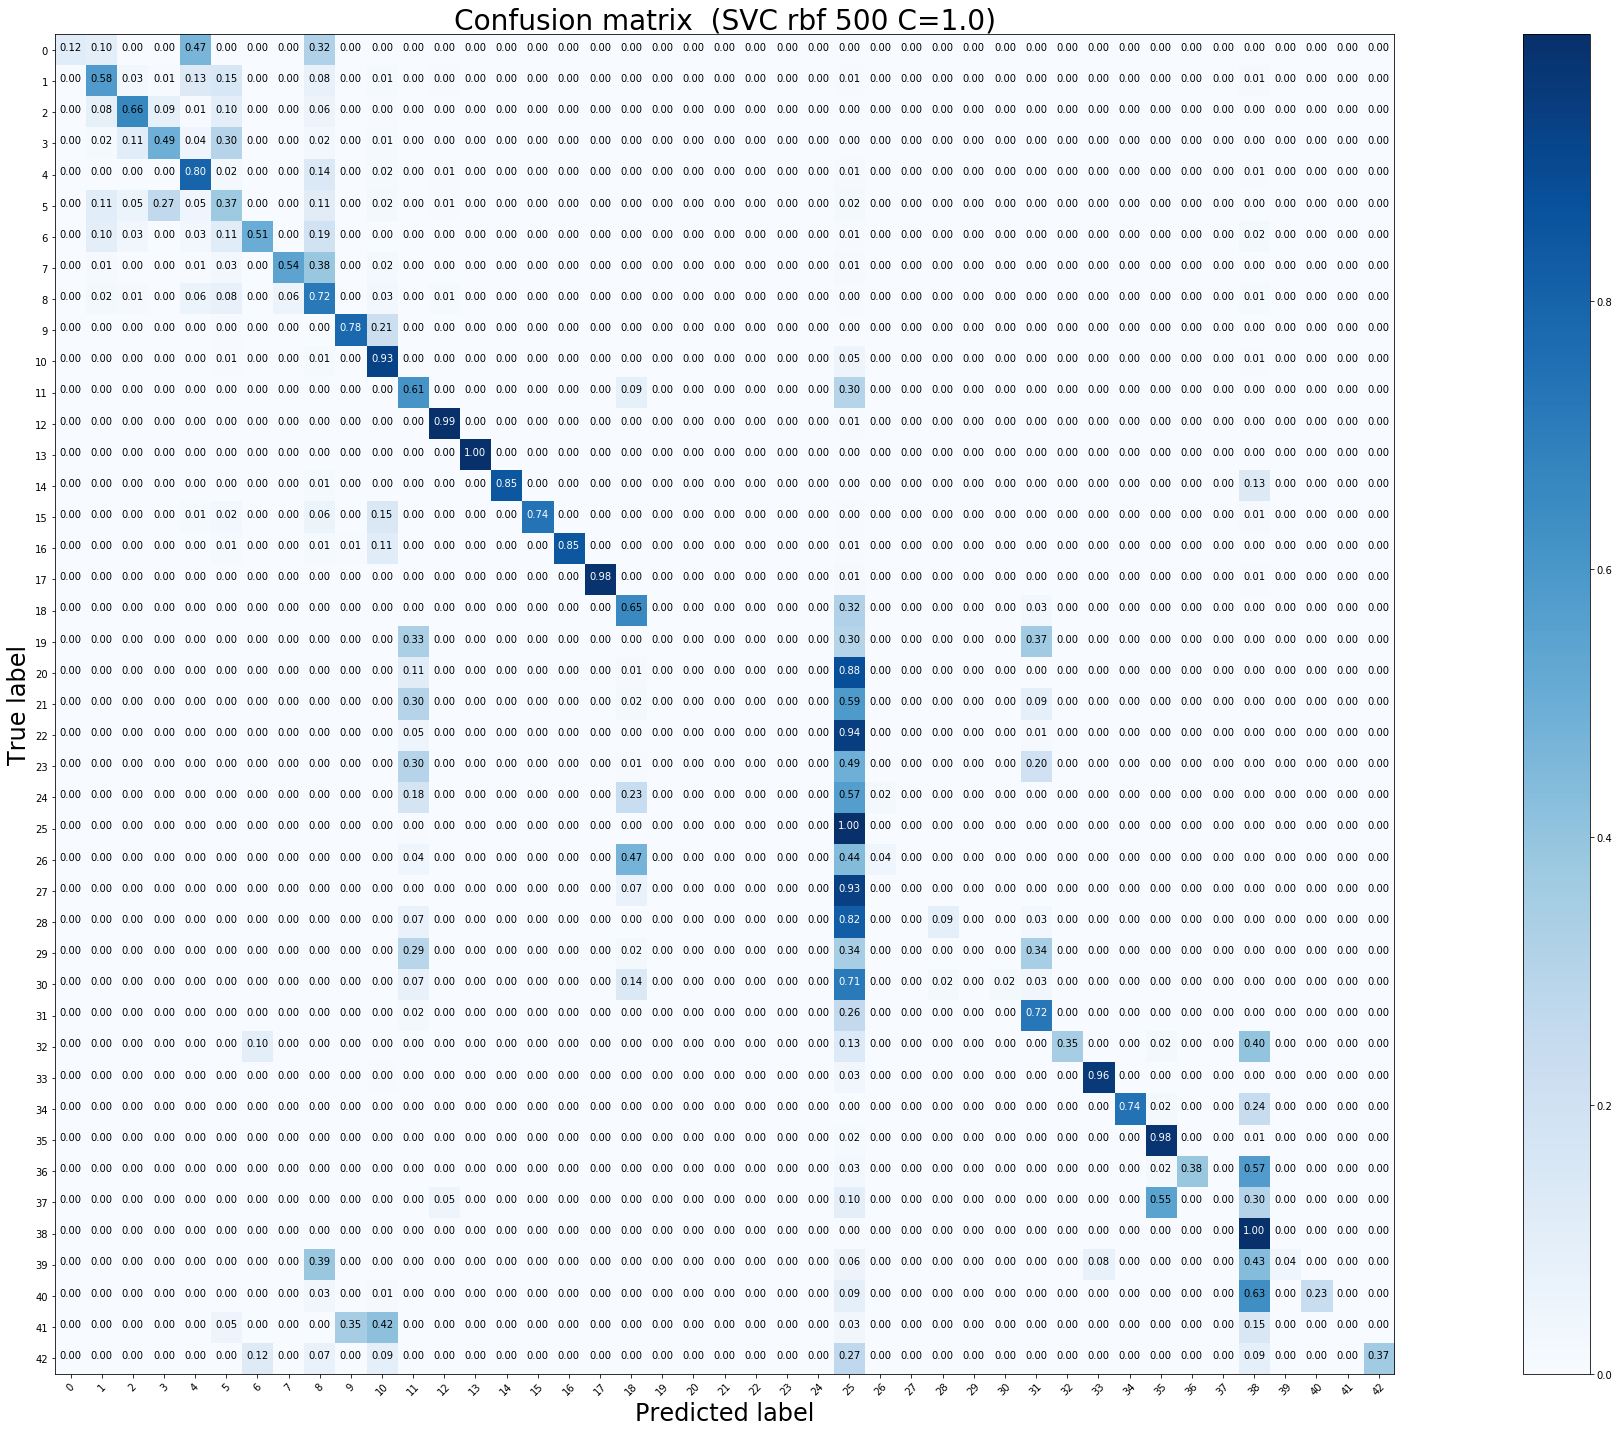

Test accuracy:  0.6727632620744259 

              precision    recall  f1-score   support

           0       1.00      0.12      0.21        60
           1       0.71      0.58      0.64       720
           2       0.82      0.66      0.73       750
           3       0.49      0.49      0.49       450
           4       0.71      0.80      0.75       660
           5       0.36      0.37      0.37       630
           6       0.82      0.51      0.63       150
           7       0.90      0.54      0.68       450
           8       0.36      0.72      0.48       450
           9       0.94      0.78      0.85       480
          10       0.71      0.93      0.81       660
          11       0.58      0.61      0.59       420
          12       0.97      0.99      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      0.85      0.92       270
          15       1.00      0.74      0.85       210
          16       1.00      0.85      0.92 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarn

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


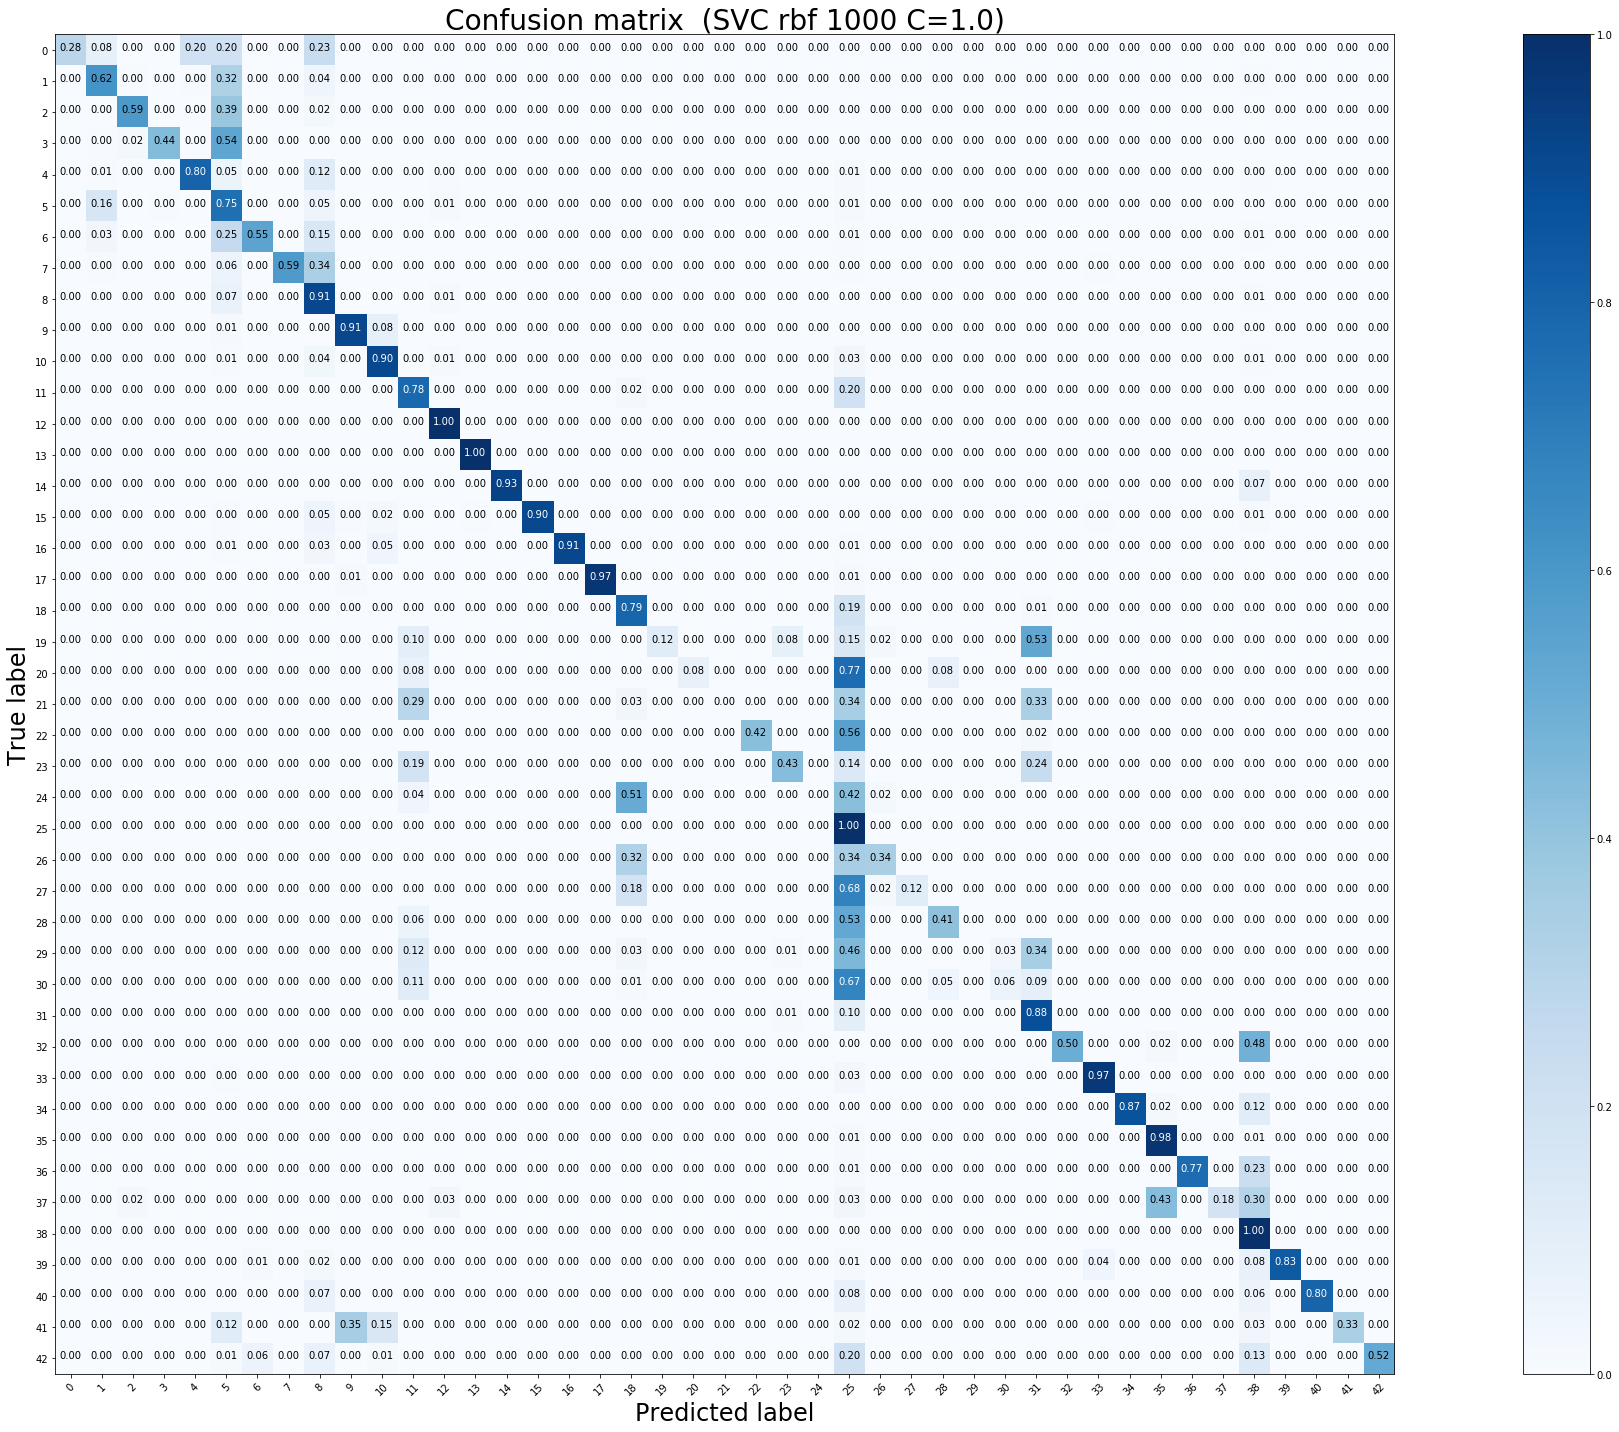

Test accuracy:  0.7584323040380048 

              precision    recall  f1-score   support

           0       1.00      0.28      0.44        60
           1       0.78      0.62      0.69       720
           2       0.97      0.59      0.73       750
           3       0.98      0.44      0.61       450
           4       0.97      0.80      0.88       660
           5       0.34      0.75      0.47       630
           6       0.93      0.55      0.69       150
           7       1.00      0.59      0.74       450
           8       0.51      0.91      0.65       450
           9       0.94      0.91      0.93       480
          10       0.90      0.90      0.90       660
          11       0.75      0.78      0.77       420
          12       0.96      1.00      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      0.93      0.96       270
          15       1.00      0.90      0.95       210
          16       1.00      0.91      0.95 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarn

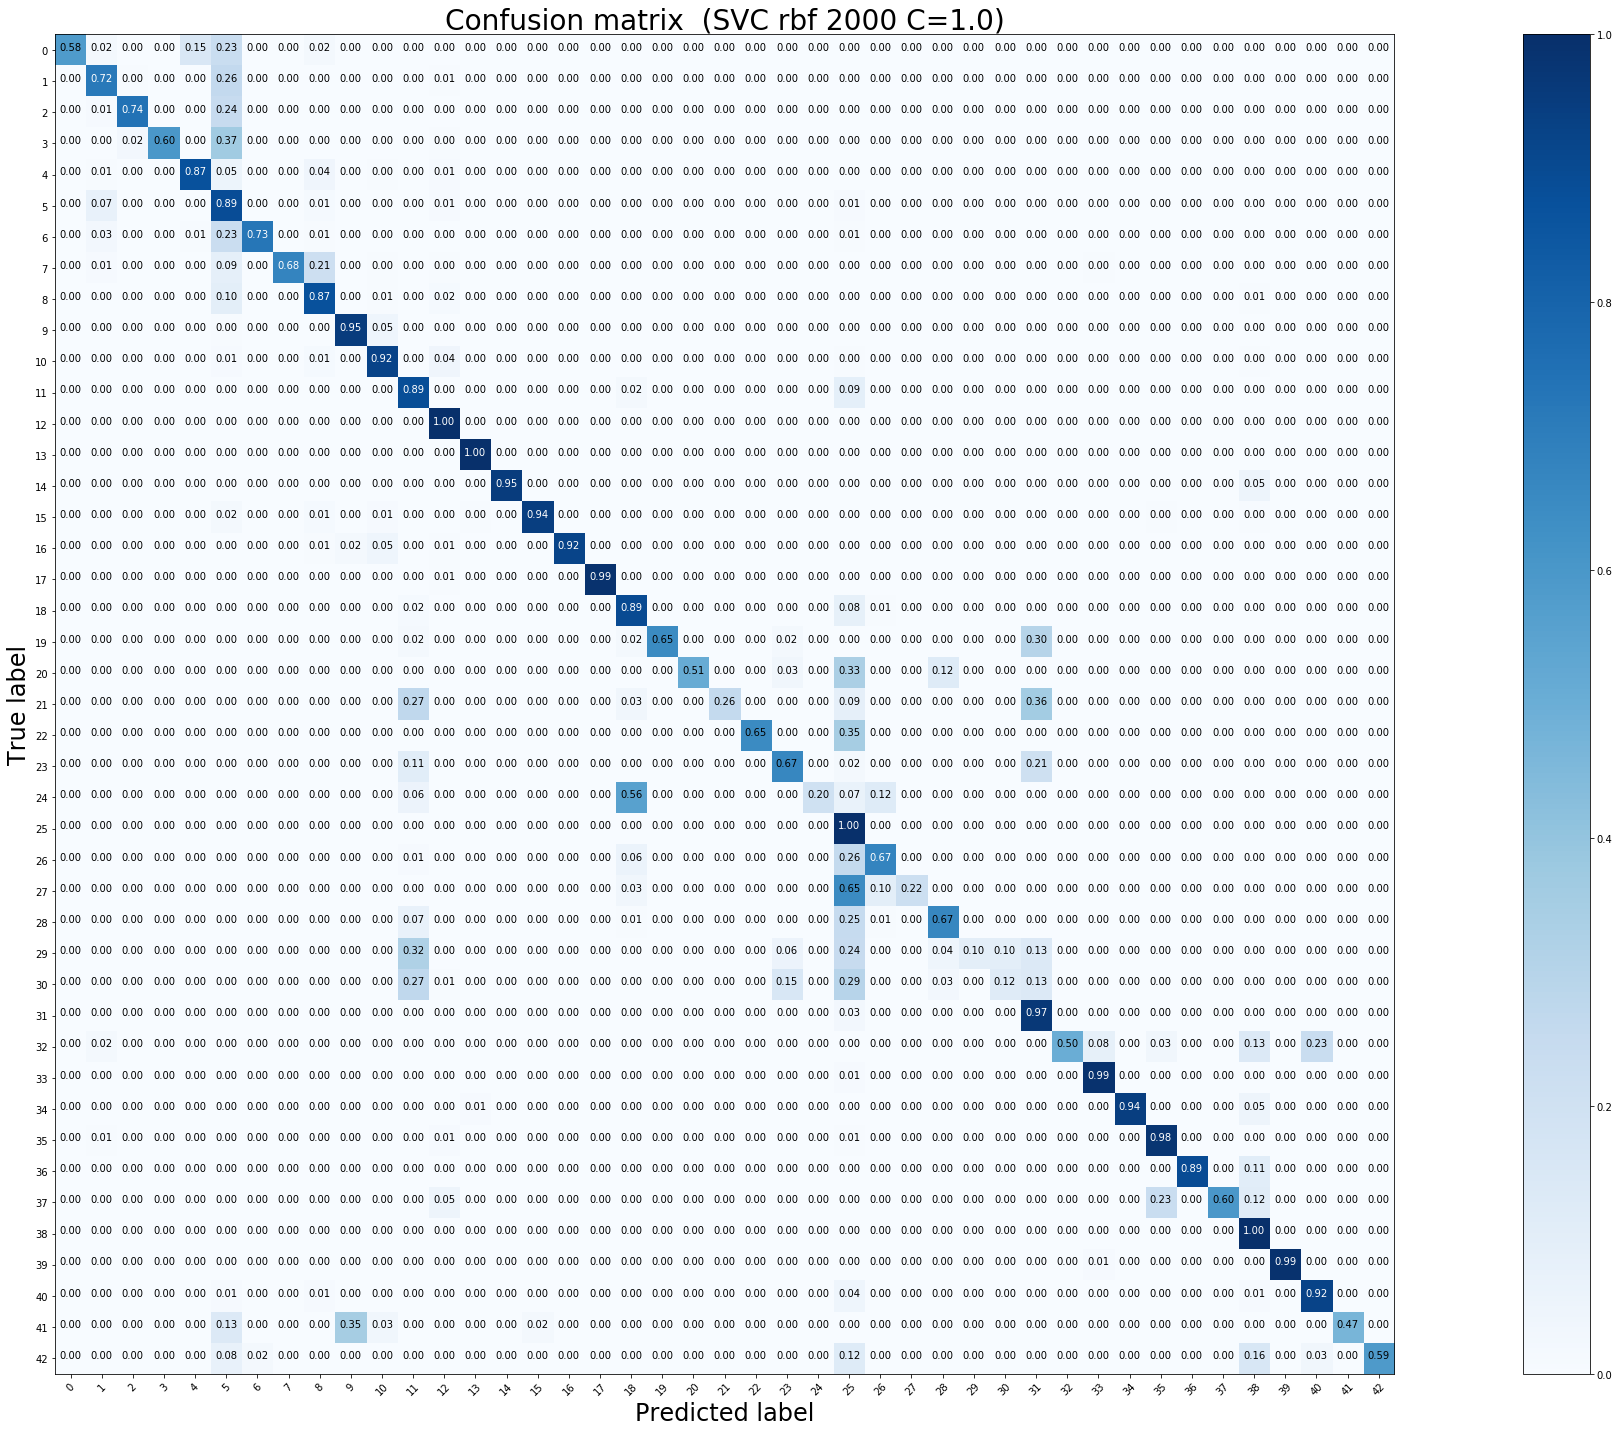

Test accuracy:  0.8386381631037213 

              precision    recall  f1-score   support

           0       1.00      0.58      0.74        60
           1       0.88      0.72      0.79       720
           2       0.97      0.74      0.84       750
           3       1.00      0.60      0.75       450
           4       0.98      0.87      0.92       660
           5       0.43      0.89      0.58       630
           6       0.98      0.73      0.84       150
           7       1.00      0.68      0.81       450
           8       0.72      0.87      0.79       450
           9       0.95      0.95      0.95       480
          10       0.94      0.92      0.93       660
          11       0.73      0.89      0.80       420
          12       0.91      1.00      0.95       690
          13       1.00      1.00      1.00       720
          14       1.00      0.95      0.98       270
          15       0.99      0.94      0.97       210
          16       1.00      0.92      0.96 

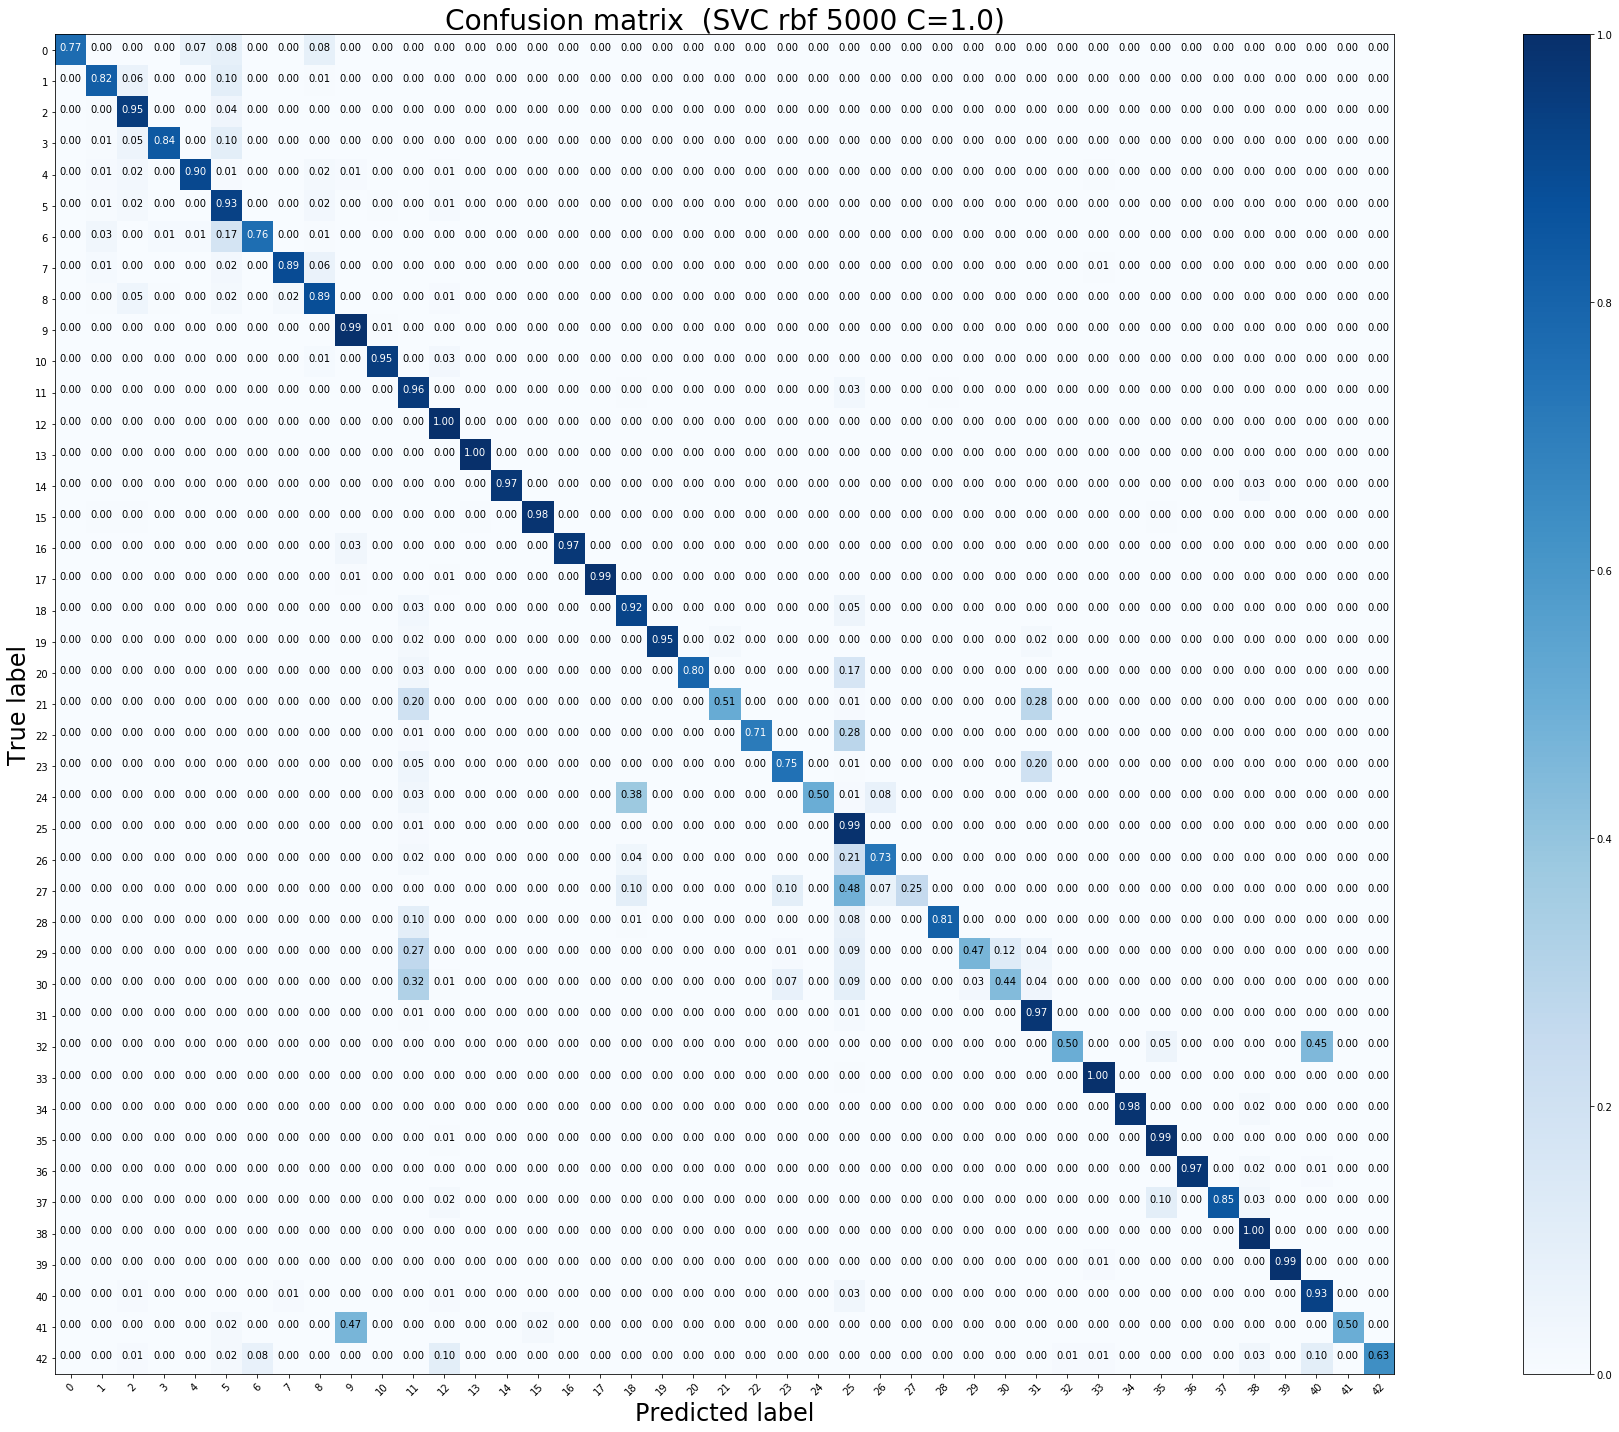

Test accuracy:  0.9073634204275535 

              precision    recall  f1-score   support

           0       1.00      0.77      0.87        60
           1       0.95      0.82      0.88       720
           2       0.86      0.95      0.90       750
           3       0.99      0.84      0.91       450
           4       0.99      0.90      0.94       660
           5       0.74      0.93      0.82       630
           6       0.94      0.76      0.84       150
           7       0.97      0.89      0.93       450
           8       0.83      0.89      0.86       450
           9       0.91      0.99      0.95       480
          10       0.99      0.95      0.97       660
          11       0.74      0.96      0.83       420
          12       0.93      1.00      0.96       690
          13       1.00      1.00      1.00       720
          14       1.00      0.97      0.98       270
          15       1.00      0.98      0.99       210
          16       1.00      0.97      0.98 

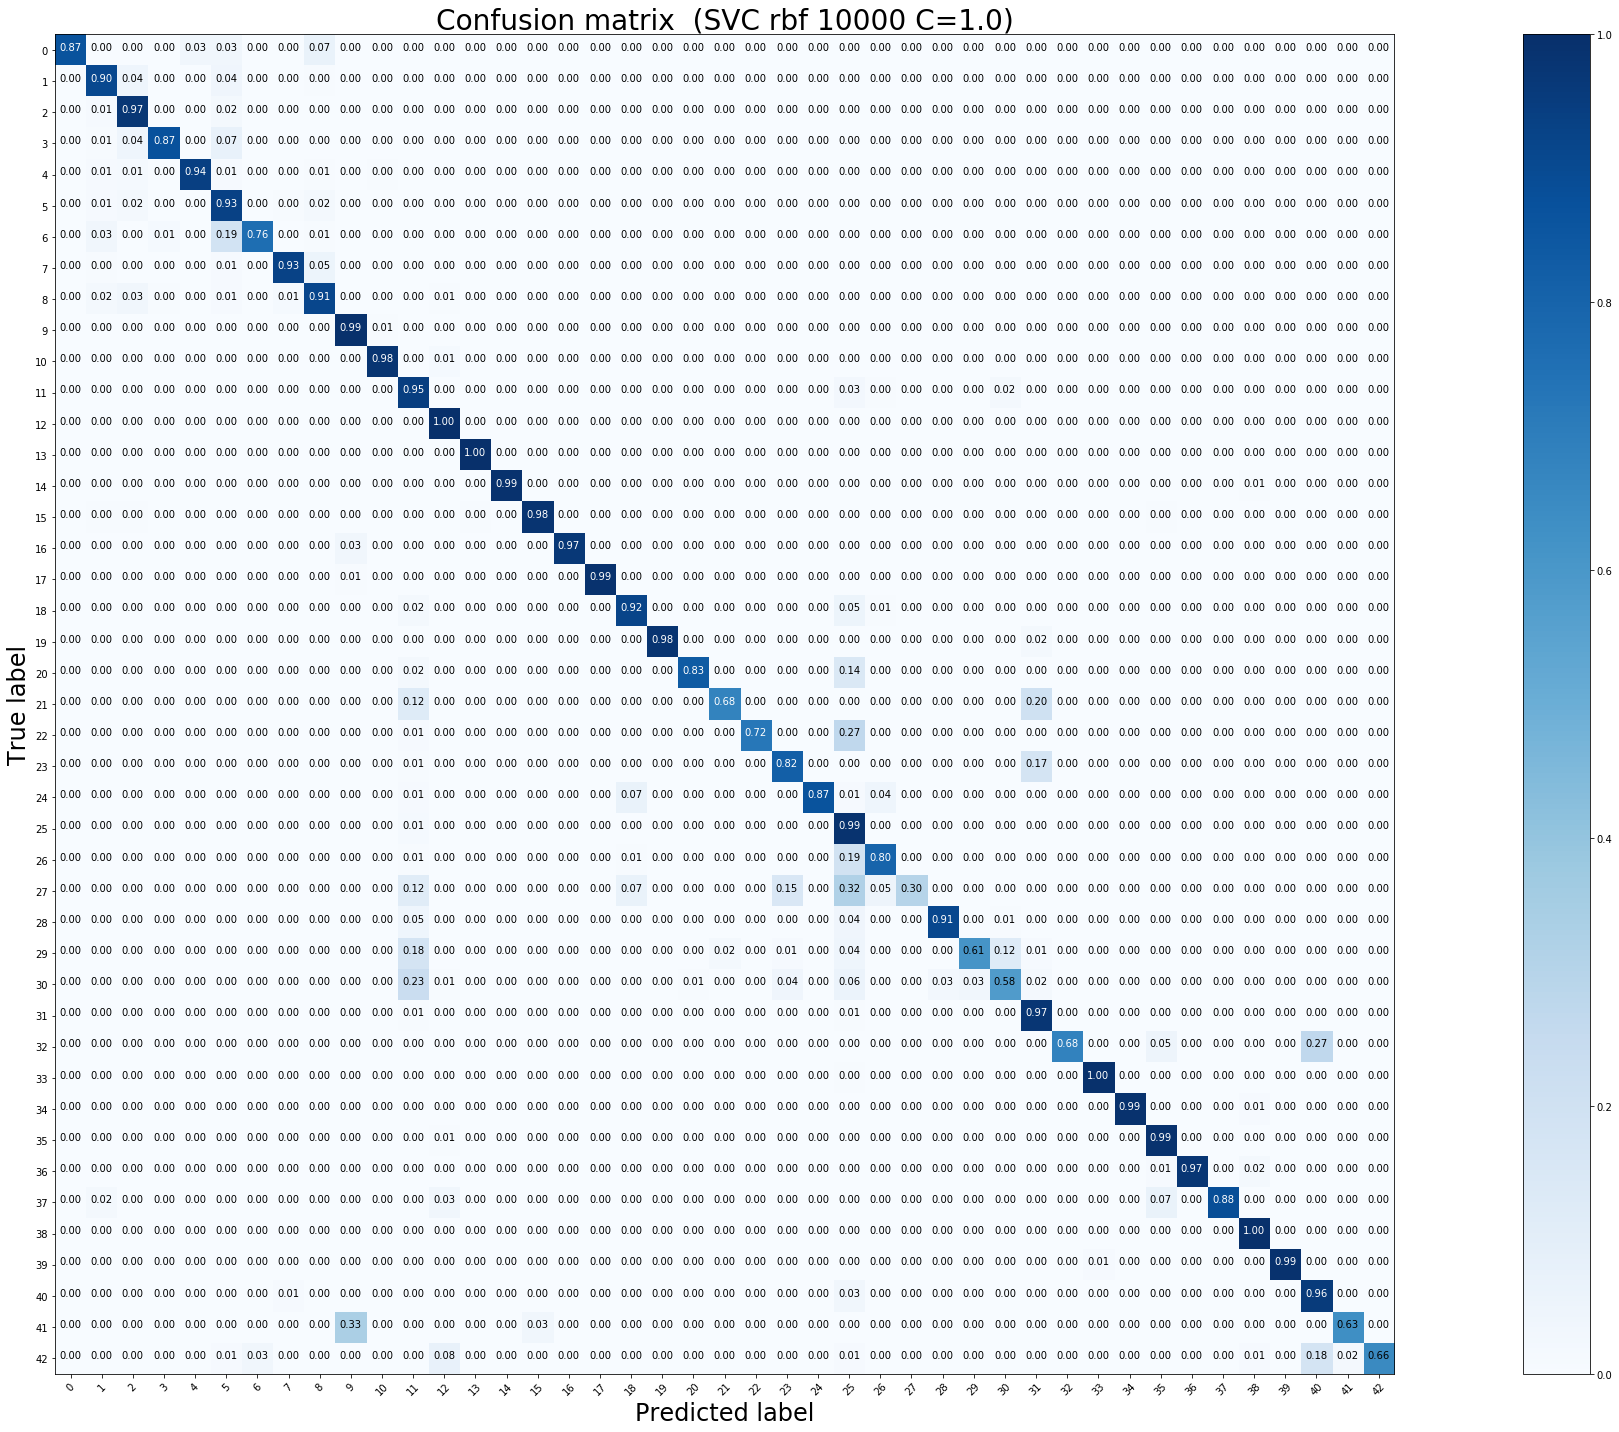

Test accuracy:  0.9326207442596991 

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        60
           1       0.94      0.90      0.92       720
           2       0.89      0.97      0.93       750
           3       0.98      0.87      0.93       450
           4       1.00      0.94      0.97       660
           5       0.83      0.93      0.88       630
           6       0.97      0.76      0.85       150
           7       0.97      0.93      0.95       450
           8       0.89      0.91      0.90       450
           9       0.94      0.99      0.96       480
          10       0.99      0.98      0.98       660
          11       0.80      0.95      0.87       420
          12       0.96      1.00      0.98       690
          13       1.00      1.00      1.00       720
          14       0.99      0.99      0.99       270
          15       0.99      0.98      0.99       210
          16       1.00      0.97      0.98 

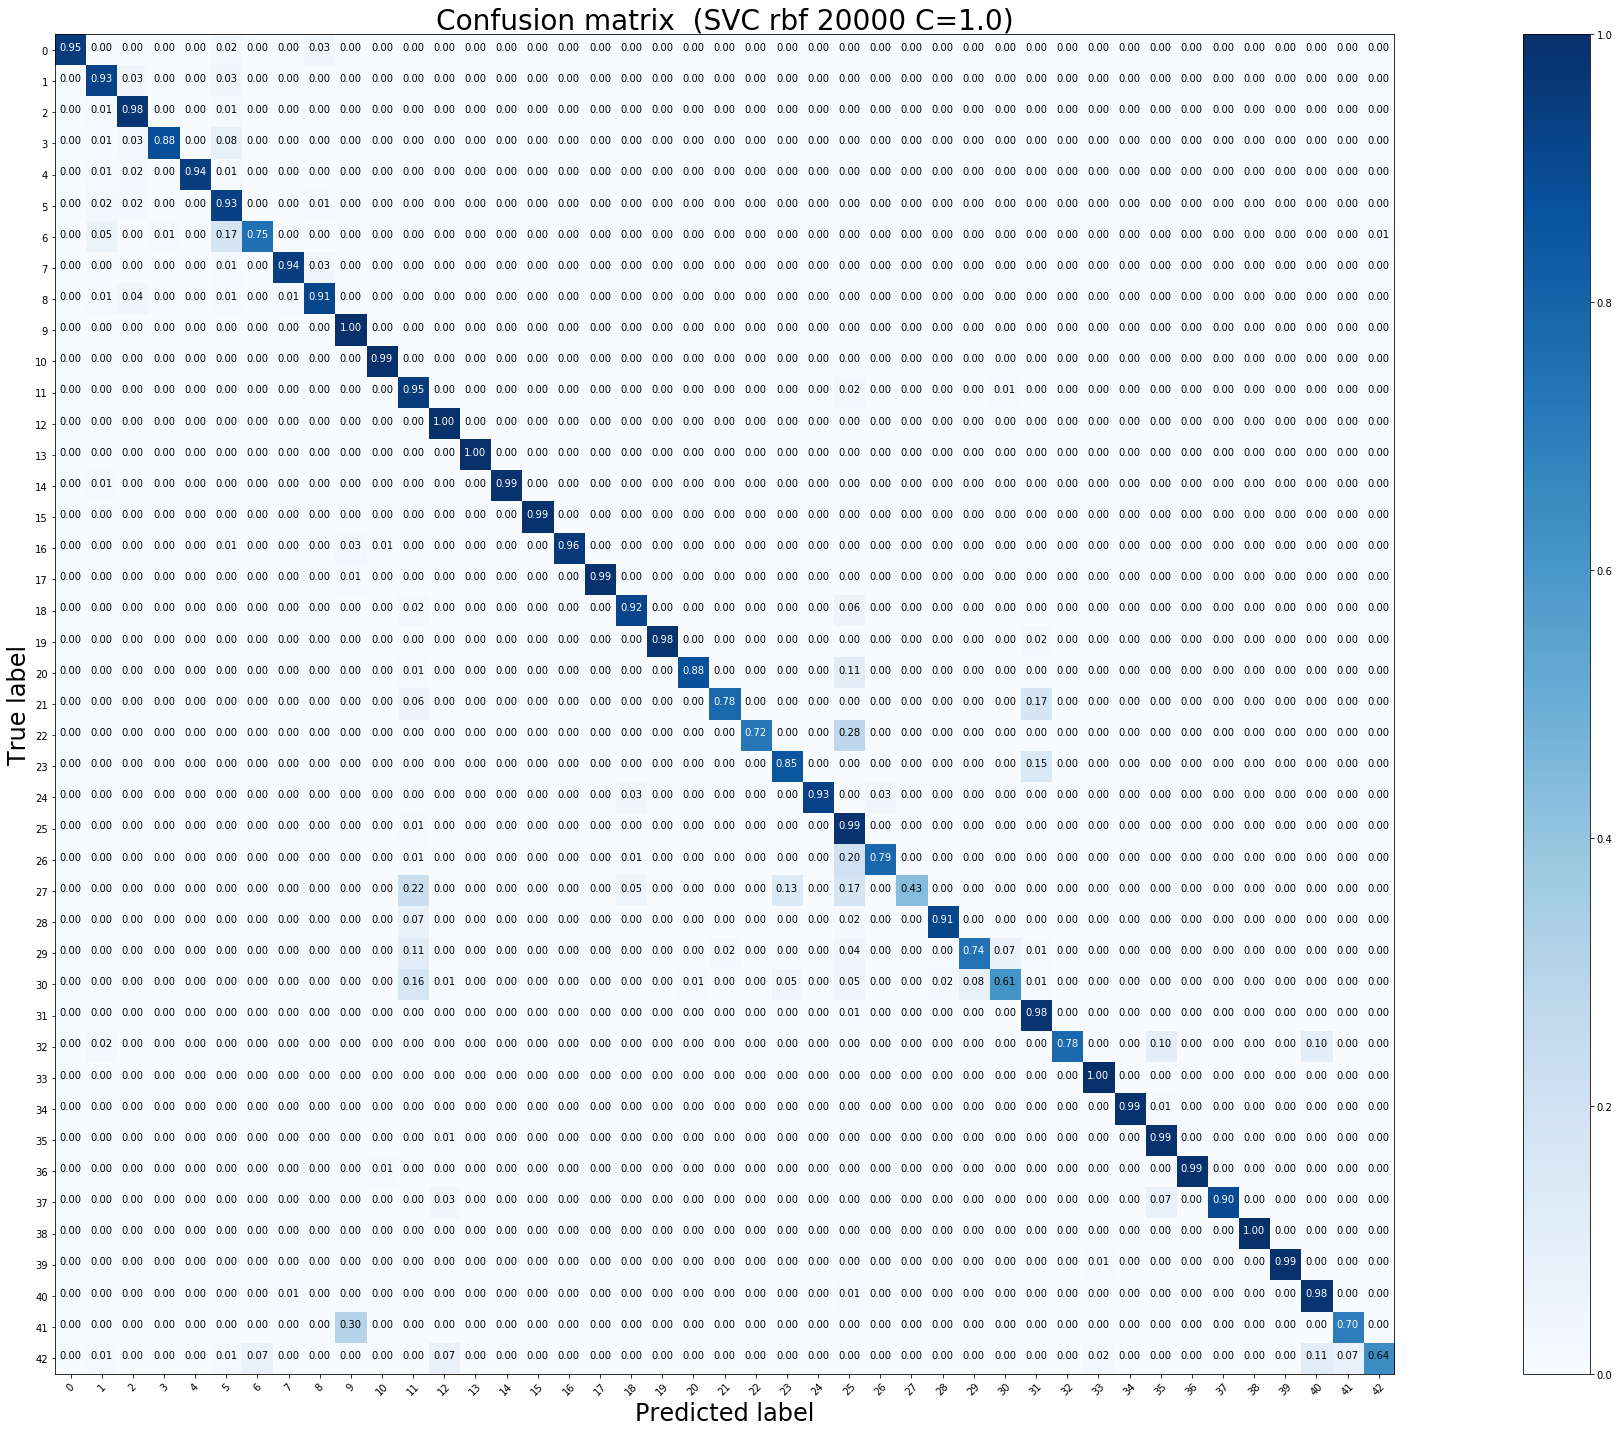

Test accuracy:  0.9420427553444181 

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        60
           1       0.93      0.93      0.93       720
           2       0.90      0.98      0.94       750
           3       0.99      0.88      0.93       450
           4       1.00      0.94      0.97       660
           5       0.84      0.93      0.88       630
           6       0.95      0.75      0.84       150
           7       0.98      0.94      0.96       450
           8       0.94      0.91      0.92       450
           9       0.94      1.00      0.97       480
          10       0.99      0.99      0.99       660
          11       0.84      0.95      0.89       420
          12       0.97      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.99      0.99      0.99       270
          15       1.00      0.99      1.00       210
          16       1.00      0.96      0.98 

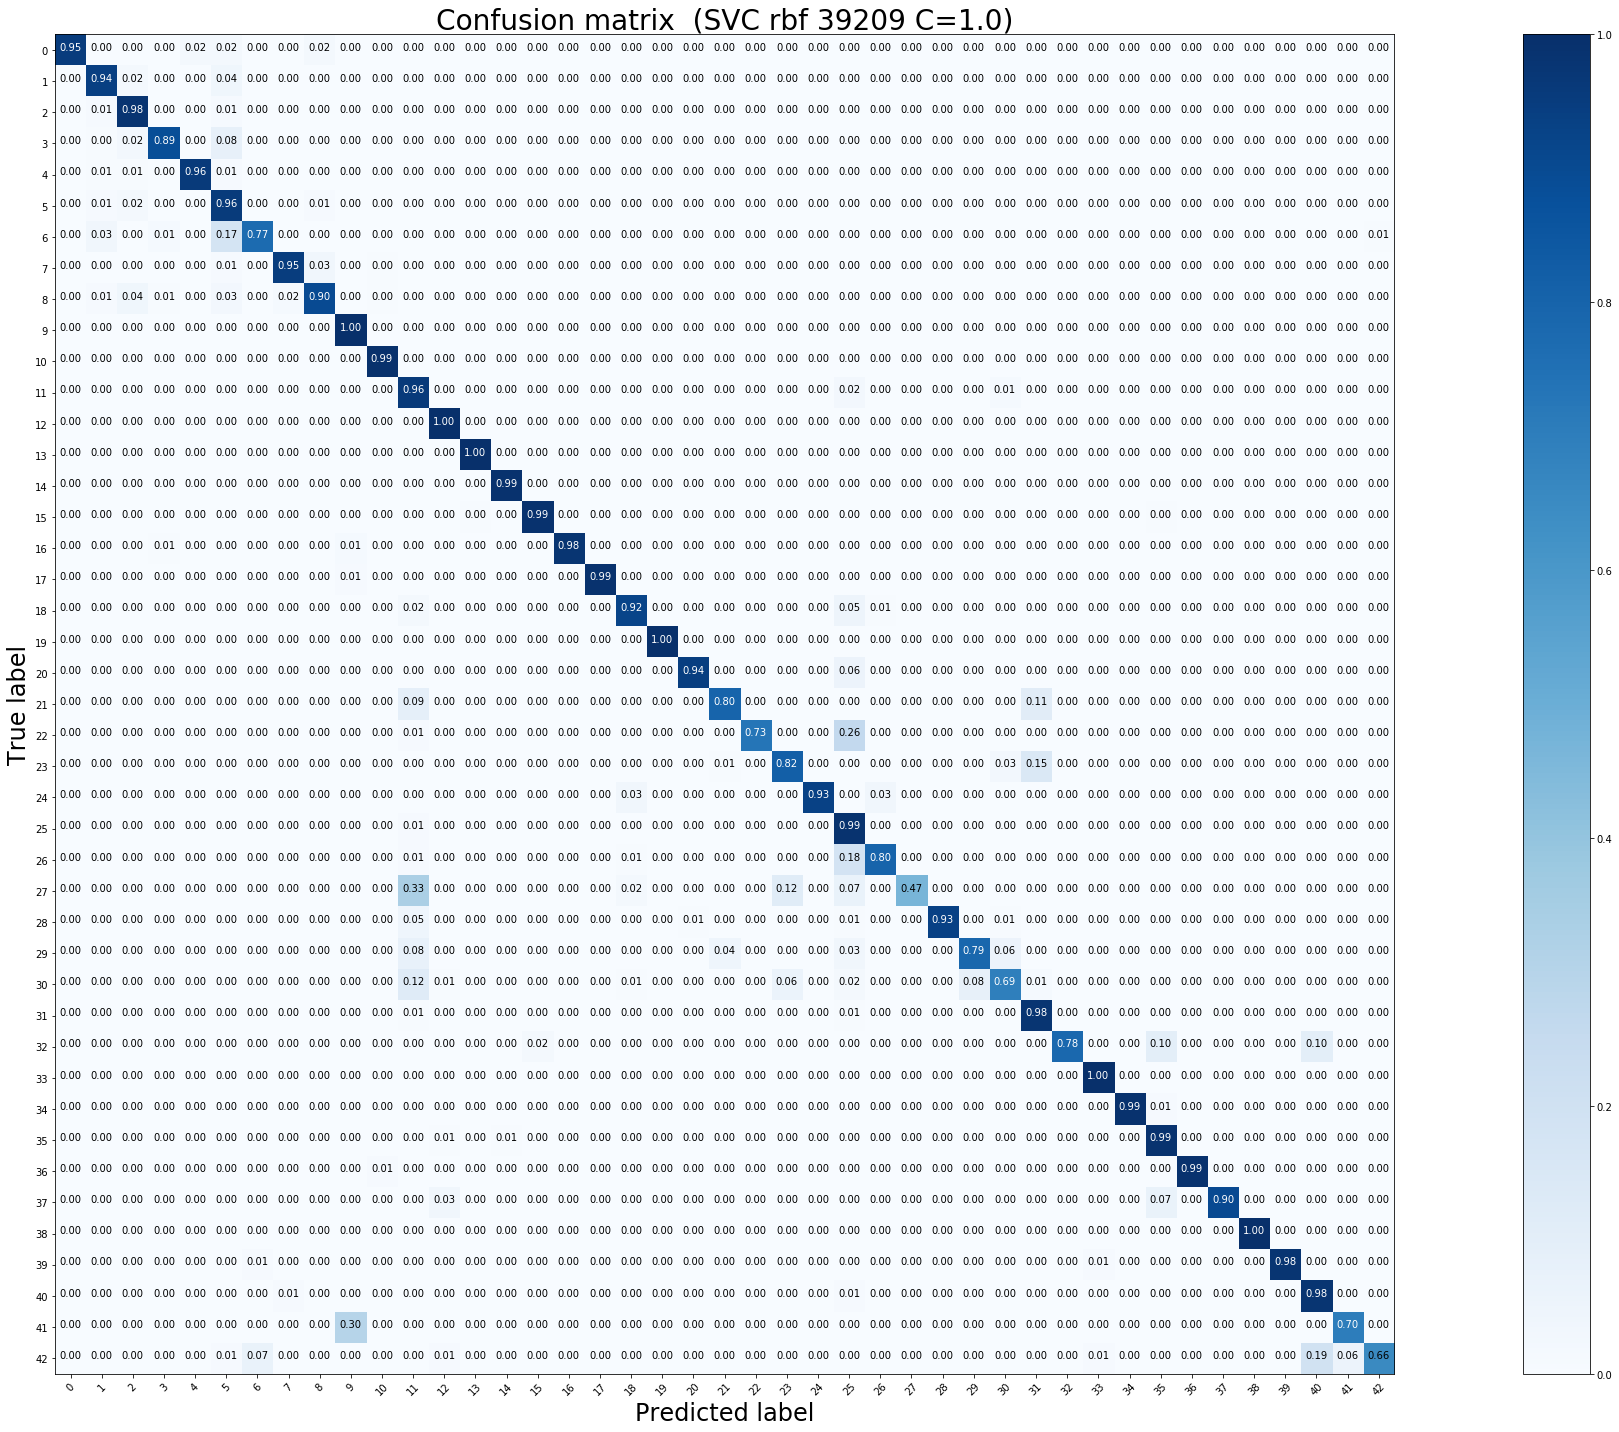

Test accuracy:  0.9477434679334917 

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        60
           1       0.96      0.94      0.95       720
           2       0.93      0.98      0.95       750
           3       0.98      0.89      0.93       450
           4       0.99      0.96      0.98       660
           5       0.83      0.96      0.89       630
           6       0.94      0.77      0.85       150
           7       0.98      0.95      0.96       450
           8       0.94      0.90      0.92       450
           9       0.95      1.00      0.97       480
          10       0.98      0.99      0.99       660
          11       0.84      0.96      0.89       420
          12       0.98      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.99      0.99      0.99       270
          15       1.00      0.99      0.99       210
          16       1.00      0.98      0.99 

In [8]:
##############################################################################
###########   SVC RBF, HOG, seed=1, random_A, with_scaler ####################
###########   Training mit Defaultwerten
##############################################################################

train_RBF_SVC(X_tr_500, X_test_9_4_2, y_tr_500, y_test, 1, '500',1.0, 'auto', 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "HOG_942_balanced.pkl")
train_RBF_SVC(X_tr_1000, X_test_9_4_2, y_tr_1000, y_test, 1, '1000',1.0, 'auto', 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "HOG_942_balanced.pkl")
train_RBF_SVC(X_tr_2000, X_test_9_4_2, y_tr_2000, y_test, 1, '2000',1.0, 'auto', 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "HOG_942_balanced.pkl")
train_RBF_SVC(X_tr_5000, X_test_9_4_2, y_tr_5000, y_test, 1, '5000',1.0, 'auto', 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "HOG_942_balanced.pkl")
train_RBF_SVC(X_tr_10000, X_test_9_4_2, y_tr_10000, y_test, 1, '10000',1.0, 'auto', 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "HOG_942_balanced.pkl")
train_RBF_SVC(X_tr_20000, X_test_9_4_2, y_tr_20000, y_test, 1, '20000',1.0, 'auto', 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "HOG_942_balanced.pkl")
train_RBF_SVC(X_tr, X_test_9_4_2, y_tr, y_test, 1, '39209',1.0, 'auto', 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/Hog_default_ski_l2_hys/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "HOG_942_balanced.pkl")

In [12]:
##################################################################################################
################ GridSearch, RBF-Kernel, mit StandardScaler ###############################################
################ 1. Durchlauf      #########################################################
###################################################################################

print("Trainingsmenge 500")
clf_500_RBF, time_500_RBF = tuning_hyper_params(X_tr_500, y_tr_500, X_test_9_4_2, y_test, 'rbf', 10, 2, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'hinge', 1)
save_trained_model_as_pkl(clf_500_RBF, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/rbf/Neue Mengen/500/seed_1_random_A_with_scaler/GridSearch_1DL.pkl")
save_as_csv(time_500_RBF, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/rbf/Neue Mengen/500/seed_1_random_A_with_scaler/", 'Suchzeiten_GridSearch_1_DL.csv')
print("*********************************************")
print("Trainingsmenge 1000")
clf_1000_RBF, time_1000_RBF = tuning_hyper_params(X_tr_1000, y_tr_1000, X_test_9_4_2, y_test, 'rbf', 10, 2, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'hinge', 1)
save_trained_model_as_pkl(clf_1000_RBF, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/rbf/Neue Mengen/1000/seed_1_random_A_with_scaler/GridSearch_1DL.pkl")
save_as_csv(time_1000_RBF, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/rbf/Neue Mengen/1000/seed_1_random_A_with_scaler/", 'Suchzeiten_GridSearch_1_DL.csv')


Trainingsmenge 500


C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range:  [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01 6.400e+01 2.560e+02 1.024e+03]

 gamma_range: [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01]

 Beste Score:  0.7248414612884878

 Besten Parameter:  {'svm__C': 256.0, 'svm__gamma': 1.52587890625e-05}
Precision-Score: 0.031212 (0.029853) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 1.52587890625e-05}
Precision-Score: 0.031570 (0.028356) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 6.103515625e-05}
Precision-Score: 0.029383 (0.034064) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.000244140625}
Precision-Score: 0.034638 (0.031835) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.0009765625}
Precision-Score: 0.023980 (0.026800) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.00390625}
Precision-Score: 0.011403 (0.011908) mit Parameter: 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range:  [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01 6.400e+01 2.560e+02 1.024e+03]

 gamma_range: [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01]

 Beste Score:  0.8569984128662035

 Besten Parameter:  {'svm__C': 256.0, 'svm__gamma': 1.52587890625e-05}
Precision-Score: 0.015731 (0.015444) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 1.52587890625e-05}
Precision-Score: 0.014862 (0.016190) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 6.103515625e-05}
Precision-Score: 0.012512 (0.007593) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.000244140625}
Precision-Score: 0.010676 (0.012352) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.0009765625}
Precision-Score: 0.005096 (0.007780) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.00390625}
Precision-Score: 0.003586 (0.008377) mit Parameter: 

F1-Score: 0.003310 (0.004246) mit Parameter: {'svm__C': 0.0009765625, 'svm__gamma': 0.015625}
F1-Score: 0.004171 (0.002844) mit Parameter: {'svm__C': 0.0009765625, 'svm__gamma': 0.0625}
F1-Score: 0.004728 (0.003609) mit Parameter: {'svm__C': 0.0009765625, 'svm__gamma': 0.25}
F1-Score: 0.002051 (0.000581) mit Parameter: {'svm__C': 0.0009765625, 'svm__gamma': 1.0}
F1-Score: 0.002051 (0.000581) mit Parameter: {'svm__C': 0.0009765625, 'svm__gamma': 4.0}
F1-Score: 0.002051 (0.000581) mit Parameter: {'svm__C': 0.0009765625, 'svm__gamma': 16.0}
F1-Score: 0.023965 (0.021797) mit Parameter: {'svm__C': 0.00390625, 'svm__gamma': 1.52587890625e-05}
F1-Score: 0.021678 (0.019946) mit Parameter: {'svm__C': 0.00390625, 'svm__gamma': 6.103515625e-05}
F1-Score: 0.020338 (0.011563) mit Parameter: {'svm__C': 0.00390625, 'svm__gamma': 0.000244140625}
F1-Score: 0.013265 (0.012364) mit Parameter: {'svm__C': 0.00390625, 'svm__gamma': 0.0009765625}
F1-Score: 0.007561 (0.008043) mit Parameter: {'svm__C': 0.0039

In [5]:
##################################################################################################
################ GridSearch, RBF-Kernel, mit StandardScaler ###############################################
################ 2. Durchlauf      #########################################################
###################################################################################

print("Trainingsmenge 500")
clf_500_RBF, time_500_RBF = tuning_hyper_params(X_tr_500, y_tr_500, X_test_9_4_2, y_test, 'rbf', 10, 2, 0, 
                                                get_finer_range(256.0), get_finer_range(1.52587890625e-05),'l2', 'hinge', 1)
save_trained_model_as_pkl(clf_500_RBF, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/rbf/Neue Mengen/500/seed_1_random_A_with_scaler/GridSearch_2DL.pkl")
save_as_csv(time_500_RBF, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/rbf/Neue Mengen/500/seed_1_random_A_with_scaler/", 'Suchzeiten_GridSearch_2_DL.csv')
print("*********************************************")
print("Trainingsmenge 1000")
clf_1000_RBF, time_1000_RBF = tuning_hyper_params(X_tr_1000, y_tr_1000, X_test_9_4_2, y_test, 'rbf', 10, 2, 0, 
                                                get_finer_range(256.0), get_finer_range(1.52587890625e-05),'l2', 'hinge', 1)
save_trained_model_as_pkl(clf_1000_RBF, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/rbf/Neue Mengen/1000/seed_1_random_A_with_scaler/GridSearch_2DL.pkl")
save_as_csv(time_1000_RBF, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/rbf/Neue Mengen/1000/seed_1_random_A_with_scaler/", 'Suchzeiten_GridSearch_2_DL.csv')


Trainingsmenge 500


C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range:  [  64.           76.10925536   90.50966799  107.63474115  128.
  152.21851072  181.01933598  215.2694823   256.          304.43702144
  362.03867197  430.53896461  512.          608.87404288  724.07734394
  861.07792922 1024.        ]

 gamma_range: [3.81469727e-06 4.53646513e-06 5.39479661e-06 6.41553051e-06
 7.62939453e-06 9.07293026e-06 1.07895932e-05 1.28310610e-05
 1.52587891e-05 1.81458605e-05 2.15791864e-05 2.56621220e-05
 3.05175781e-05 3.62917210e-05 4.31583729e-05 5.13242441e-05
 6.10351562e-05]

 Beste Score:  0.7328072876190201

 Besten Parameter:  {'svm__C': 256.0, 'svm__gamma': 4.536465129862675e-06}
Precision-Score: 0.720072 (0.135616) mit Parameter: {'svm__C': 64.0, 'svm__gamma': 3.814697265625e-06}
Precision-Score: 0.724003 (0.137052) mit Parameter: {'svm__C': 64.0, 'svm__gamma': 4.536465129862675e-06}
Precision-Score: 0.721021 (0.132159) mit Parameter: {'svm__C': 64.0, 'svm__gamma': 5.3947966093944364e-06}
Precision-Score: 0.721371 (0.135321) mit Parameter

Roc-Score: 0.873895 (0.059738) mit Parameter: {'svm__C': 1024.0, 'svm__gamma': 7.62939453125e-06}
Roc-Score: 0.873895 (0.059738) mit Parameter: {'svm__C': 1024.0, 'svm__gamma': 9.07293025972535e-06}
Roc-Score: 0.873895 (0.059738) mit Parameter: {'svm__C': 1024.0, 'svm__gamma': 1.0789593218788873e-05}
Roc-Score: 0.872129 (0.059969) mit Parameter: {'svm__C': 1024.0, 'svm__gamma': 1.2831061023768837e-05}
Roc-Score: 0.872129 (0.059969) mit Parameter: {'svm__C': 1024.0, 'svm__gamma': 1.52587890625e-05}
Roc-Score: 0.872129 (0.059969) mit Parameter: {'svm__C': 1024.0, 'svm__gamma': 1.81458605194507e-05}
Roc-Score: 0.870281 (0.058639) mit Parameter: {'svm__C': 1024.0, 'svm__gamma': 2.1579186437577746e-05}
Roc-Score: 0.868631 (0.059206) mit Parameter: {'svm__C': 1024.0, 'svm__gamma': 2.5662122047537674e-05}
Roc-Score: 0.867025 (0.061209) mit Parameter: {'svm__C': 1024.0, 'svm__gamma': 3.0517578125e-05}
Roc-Score: 0.867024 (0.061210) mit Parameter: {'svm__C': 1024.0, 'svm__gamma': 3.629172103890

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range:  [  64.           76.10925536   90.50966799  107.63474115  128.
  152.21851072  181.01933598  215.2694823   256.          304.43702144
  362.03867197  430.53896461  512.          608.87404288  724.07734394
  861.07792922 1024.        ]

 gamma_range: [3.81469727e-06 4.53646513e-06 5.39479661e-06 6.41553051e-06
 7.62939453e-06 9.07293026e-06 1.07895932e-05 1.28310610e-05
 1.52587891e-05 1.81458605e-05 2.15791864e-05 2.56621220e-05
 3.05175781e-05 3.62917210e-05 4.31583729e-05 5.13242441e-05
 6.10351562e-05]

 Beste Score:  0.8589978507668041

 Besten Parameter:  {'svm__C': 181.01933598375618, 'svm__gamma': 7.62939453125e-06}
Precision-Score: 0.842481 (0.049097) mit Parameter: {'svm__C': 64.0, 'svm__gamma': 3.814697265625e-06}
Precision-Score: 0.843501 (0.053842) mit Parameter: {'svm__C': 64.0, 'svm__gamma': 4.536465129862675e-06}
Precision-Score: 0.848411 (0.054734) mit Parameter: {'svm__C': 64.0, 'svm__gamma': 5.3947966093944364e-06}
Precision-Score: 0.852341 (0.051702) mit 

Roc-Score: 0.933781 (0.026000) mit Parameter: {'svm__C': 861.0779292198037, 'svm__gamma': 1.2831061023768837e-05}
Roc-Score: 0.933780 (0.025999) mit Parameter: {'svm__C': 861.0779292198037, 'svm__gamma': 1.52587890625e-05}
Roc-Score: 0.933781 (0.025999) mit Parameter: {'svm__C': 861.0779292198037, 'svm__gamma': 1.81458605194507e-05}
Roc-Score: 0.933781 (0.025999) mit Parameter: {'svm__C': 861.0779292198037, 'svm__gamma': 2.1579186437577746e-05}
Roc-Score: 0.933781 (0.025999) mit Parameter: {'svm__C': 861.0779292198037, 'svm__gamma': 2.5662122047537674e-05}
Roc-Score: 0.932408 (0.027359) mit Parameter: {'svm__C': 861.0779292198037, 'svm__gamma': 3.0517578125e-05}
Roc-Score: 0.933653 (0.025446) mit Parameter: {'svm__C': 861.0779292198037, 'svm__gamma': 3.62917210389014e-05}
Roc-Score: 0.929486 (0.023037) mit Parameter: {'svm__C': 861.0779292198037, 'svm__gamma': 4.315837287515549e-05}
Roc-Score: 0.927973 (0.024954) mit Parameter: {'svm__C': 861.0779292198037, 'svm__gamma': 5.132424409507

In [ ]:
train_RBF_SVC(X_tr_500, X_test_9_4_2_hue, y_tr_500, y_test, 1, '500',256.0, 4.536465129862675e-06, 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "HOG_942_balanced.pkl")
train_RBF_SVC(X_tr_1000, X_test_9_4_2_hue, y_tr_1000, y_test, 1, '1000',152.2185107203483, 7.62939453125e-06, 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "HOG_942_balanced.pkl")


In [ ]:
##################################################################################################
################ GridSearch, RBF-Kernel, mit StandardScaler ###############################################
################ 1. Durchlauf      #########################################################
###################################################################################

print("Trainingsmenge 2000")
clf_2000_RBF, time_2000_RBF = tuning_hyper_params(X_tr_2000, y_tr_2000, X_test_9_4_2, y_test, 'rbf', 10, 2, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'hinge', 1)
save_trained_model_as_pkl(clf_2000_RBF, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/rbf/Neue Mengen/2000/seed_1_random_A_with_scaler/GridSearch_1DL.pkl")
save_as_csv(time_2000_RBF, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/rbf/Neue Mengen/2000/seed_1_random_A_with_scaler/", 'Suchzeiten_GridSearch_1_DL.csv')
print("*********************************************")
print("Trainingsmenge 5000")
clf_5000_RBF, time_5000_RBF = tuning_hyper_params(X_tr_5000, y_tr_5000, X_test_9_4_2, y_test, 'rbf', 10, 2, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'hinge', 1)
save_trained_model_as_pkl(clf_1000_RBF, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/rbf/Neue Mengen/5000/seed_1_random_A_with_scaler/GridSearch_1DL.pkl")
save_as_csv(time_5000_RBF, "SVM_Modelle_GTSRB/Hog_opt_ski_l2_hys/rbf/Neue Mengen/5000/seed_1_random_A_with_scaler/", 'Suchzeiten_GridSearch_1_DL.csv')


Trainingsmenge 2000
